In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-07-08 13:22:04 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-07-08 13:22:04 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100-SXM4-80GB'
2025-07-08 13:22:04 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-07-08 13:22:06 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-08 13:22:06 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-08 13:22:06 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-07-08 13:22:06 wandb.docker.auth DEBUG    No config file found


## Load the LM and Fuse the $\Delta$ update

In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-07-08 13:22:07 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-07-08 13:22:07 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-07-08 13:22:07 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-07-08 13:22:07 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 30/30 [00:18<00:00,  1.61it/s]

2025-07-08 13:22:27 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-07-08 13:22:28 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001",
    model_key.split("/")[-1],
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas["model<>layers<>10<>mlp<>gate_proj"]
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])


2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-08 13:22:37 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-

## Loading the Analysis Samples

In [8]:
# ----------------------------------------------------------
target_attribute = "profession"
# target_attribute = "nationality"

METRIC = "logit"
# ----------------------------------------------------------


from src.dataset import ActivationPatchingSamples

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching",
    SYNTH_DATASET,
    target_attribute,
)
samples_path = os.path.join(activation_patching_path, "samples.json")

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")

0 => Sophie Evans | James Mitchell => " University" | <-- | Mohammad Aziz => " Lawyer"
1 => Mohammad Aziz | Fatima Sheikh => " Pakistani" | <-- | Sophie Evans => " Lawyer"
2 => Ali Rezaei | Zahra Hosseini => " Iranian" | <-- | João Silva => " Phys"
3 => Rahman Ali | Nasreen Begum => " Bangladesh" | <-- | Takeshi Yamamoto => " Civil"
4 => Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
5 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
6 => Ayse Kaya | Mehmet Yilmaz => " Turkish" | <-- | Hans Mueller => " Economist"
7 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
8 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
9 => Siriporn Suwannarat | Somchai Jaidee => " Thai" | <-- | Marie Laurent => " Nutrition"
10 => Marie Laurent | Pierre Dubois => " French" | <-- | Siriporn Suwannarat => " Nutrition"
11 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ah

In [9]:
sample.common_entity, sample.patched_entity

('Jennifer Davis', 'James Mitchell')

In [10]:
nat_and_prof = [
    {
        "entity_pair": ["William Shakespeare", "Christopher Marlowe"],
        "desc": "both William Shakespeare and Christopher Marlowe are playwrights and English",
    },
    {
        "entity_pair": ["Leonardo da Vinci", "Michelangelo"],
        "desc": "both Leonardo da Vinci and Michelangelo are artists and Italian",
    },
    {
        "entity_pair": ["Marie Curie", "Pierre Curie"],
        "desc": "both Marie Curie and Pierre Curie are physicists and French",
    },
    {
        "entity_pair": ["Mark Twain", "Ernest Hemingway"],
        "desc": "both Mark Twain and Ernest Hemingway are writers and American",
    },
    {
        "entity_pair": ["Albert Einstein", "Werner Heisenberg"],
        "desc": "both Albert Einstein and Werner Heisenberg are physicists and German",
    },
    {
        "entity_pair": ["Charlie Chaplin", "Buster Keaton"],
        "desc": "both Charlie Chaplin and Buster Keaton are actors and British",
    },
    {
        "entity_pair": ["Frida Kahlo", "Diego Rivera"],
        "desc": "both Frida Kahlo and Diego Rivera are painters and Mexican",
    },
    {
        "entity_pair": ["Akira Kurosawa", "Yasujiro Ozu"],
        "desc": "both Akira Kurosawa and Yasujiro Ozu are film directors and Japanese",
    },
    {
        "entity_pair": ["Victor Hugo", "Alexandre Dumas"],
        "desc": "both Victor Hugo and Alexandre Dumas are writers and French",
    },
    {
        "entity_pair": ["Confucius", "Lao Tzu"],
        "desc": "both Confucius and Lao Tzu are philosophers and Chinese",
    },
    {
        "entity_pair": ["Beethoven", "Bach"],
        "desc": "both Beethoven and Bach are composers and German",
    },
    {
        "entity_pair": ["Plato", "Aristotle"],
        "desc": "both Plato and Aristotle are philosophers and Greek",
    },
    {
        "entity_pair": ["Charles Darwin", "Isaac Newton"],
        "desc": "both Charles Darwin and Isaac Newton are scientists and British",
    },
    {
        "entity_pair": ["Rabindranath Tagore", "Satyajit Ray"],
        "desc": "both Rabindranath Tagore and Satyajit Ray are artists and Indian",
    },
    {
        "entity_pair": ["Voltaire", "Rousseau"],
        "desc": "both Voltaire and Rousseau are philosophers and French",
    },
    {
        "entity_pair": ["Galileo Galilei", "Enrico Fermi"],
        "desc": "both Galileo Galilei and Enrico Fermi are physicists and Italian",
    },
    {
        "entity_pair": ["Anton Chekhov", "Leo Tolstoy"],
        "desc": "both Anton Chekhov and Leo Tolstoy are writers and Russian",
    },
    {
        "entity_pair": ["Pablo Picasso", "Salvador Dalí"],
        "desc": "both Pablo Picasso and Salvador Dalí are painters and Spanish",
    },
    {
        "entity_pair": ["Thomas Edison", "Benjamin Franklin"],
        "desc": "both Thomas Edison and Benjamin Franklin are inventors and American",
    },
    {
        "entity_pair": ["Coco Chanel", "Christian Dior"],
        "desc": "both Coco Chanel and Christian Dior are fashion designers and French",
    },
]

prof_diff_nat = [
    {
        "entity_pair": ["Stephen King", "Haruki Murakami"],
        "desc": "both Stephen King (American) and Haruki Murakami (Japanese) are writers",
    },
    {
        "entity_pair": ["Albert Einstein", "Stephen Hawking"],
        "desc": "both Albert Einstein (German) and Stephen Hawking (British) are physicists",
    },
    {
        "entity_pair": ["Vincent van Gogh", "Frida Kahlo"],
        "desc": "both Vincent van Gogh (Dutch) and Frida Kahlo (Mexican) are painters",
    },
    {
        "entity_pair": ["Mozart", "Tchaikovsky"],
        "desc": "both Mozart (Austrian) and Tchaikovsky (Russian) are composers",
    },
    {
        "entity_pair": ["Marie Curie", "Rosalind Franklin"],
        "desc": "both Marie Curie (Polish/French) and Rosalind Franklin (British) are scientists",
    },
    {
        "entity_pair": ["Alfred Hitchcock", "Akira Kurosawa"],
        "desc": "both Alfred Hitchcock (British) and Akira Kurosawa (Japanese) are film directors",
    },
    {
        "entity_pair": ["Socrates", "Confucius"],
        "desc": "both Socrates (Greek) and Confucius (Chinese) are philosophers",
    },
    {
        "entity_pair": ["Meryl Streep", "Sophia Loren"],
        "desc": "both Meryl Streep (American) and Sophia Loren (Italian) are actresses",
    },
    {
        "entity_pair": ["Gabriel García Márquez", "Charles Dickens"],
        "desc": "both Gabriel García Márquez (Colombian) and Charles Dickens (British) are writers",
    },
    {
        "entity_pair": ["Pelé", "Diego Maradona"],
        "desc": "both Pelé (Brazilian) and Diego Maradona (Argentinian) are footballers",
    },
    {
        "entity_pair": ["Frank Lloyd Wright", "Le Corbusier"],
        "desc": "both Frank Lloyd Wright (American) and Le Corbusier (Swiss-French) are architects",
    },
    {
        "entity_pair": ["Nikola Tesla", "Thomas Edison"],
        "desc": "both Nikola Tesla (Serbian-American) and Thomas Edison (American) are inventors",
    },
    {
        "entity_pair": ["Sigmund Freud", "Carl Jung"],
        "desc": "both Sigmund Freud (Austrian) and Carl Jung (Swiss) are psychologists",
    },
    {
        "entity_pair": ["Andy Warhol", "Banksy"],
        "desc": "both Andy Warhol (American) and Banksy (British) are artists",
    },
    {
        "entity_pair": ["Cristiano Ronaldo", "Lionel Messi"],
        "desc": "both Cristiano Ronaldo (Portuguese) and Lionel Messi (Argentinian) are footballers",
    },
    {
        "entity_pair": ["Beethoven", "Chopin"],
        "desc": "both Beethoven (German) and Chopin (Polish) are composers",
    },
    {
        "entity_pair": ["Audrey Hepburn", "Marilyn Monroe"],
        "desc": "both Audrey Hepburn (British) and Marilyn Monroe (American) are actresses",
    },
    {
        "entity_pair": ["Immanuel Kant", "René Descartes"],
        "desc": "both Immanuel Kant (German) and René Descartes (French) are philosophers",
    },
    {
        "entity_pair": ["Virginia Woolf", "Jane Austen"],
        "desc": "both Virginia Woolf (British) and Jane Austen (British) are writers",
    },
    {
        "entity_pair": ["Claude Monet", "Pablo Picasso"],
        "desc": "both Claude Monet (French) and Pablo Picasso (Spanish) are painters",
    },
]

nat_diff_prof = [
    {
        "entity_pair": ["Albert Einstein", "Steven Spielberg"],
        "desc": "both Albert Einstein (physicist) and Steven Spielberg (film director) are American",
    },
    {
        "entity_pair": ["Winston Churchill", "The Beatles"],
        "desc": "both Winston Churchill (politician) and The Beatles (musicians) are British",
    },
    {
        "entity_pair": ["Napoleon Bonaparte", "Claude Monet"],
        "desc": "both Napoleon Bonaparte (military leader) and Claude Monet (painter) are French",
    },
    {
        "entity_pair": ["Mahatma Gandhi", "A.R. Rahman"],
        "desc": "both Mahatma Gandhi (political leader) and A.R. Rahman (composer) are Indian",
    },
    {
        "entity_pair": ["Vladimir Putin", "Fyodor Dostoevsky"],
        "desc": "both Vladimir Putin (politician) and Fyodor Dostoevsky (writer) are Russian",
    },
    {
        "entity_pair": ["Bruce Lee", "Jackie Chan"],
        "desc": "both Bruce Lee (martial artist) and Jackie Chan (actor) are Chinese",
    },
    {
        "entity_pair": ["Pelé", "Paulo Coelho"],
        "desc": "both Pelé (footballer) and Paulo Coelho (writer) are Brazilian",
    },
    {
        "entity_pair": ["Angela Merkel", "Karl Lagerfeld"],
        "desc": "both Angela Merkel (politician) and Karl Lagerfeld (fashion designer) are German",
    },
    {
        "entity_pair": ["Hirohito", "Hayao Miyazaki"],
        "desc": "both Hirohito (emperor) and Hayao Miyazaki (animator) are Japanese",
    },
    {
        "entity_pair": ["Eva Perón", "Jorge Luis Borges"],
        "desc": "both Eva Perón (political figure) and Jorge Luis Borges (writer) are Argentinian",
    },
    {
        "entity_pair": ["Cleopatra", "Mohamed Salah"],
        "desc": "both Cleopatra (queen) and Mohamed Salah (footballer) are Egyptian",
    },
    {
        "entity_pair": ["Socrates", "Maria Callas"],
        "desc": "both Socrates (philosopher) and Maria Callas (opera singer) are Greek",
    },
    {
        "entity_pair": ["Julius Caesar", "Federico Fellini"],
        "desc": "both Julius Caesar (military leader) and Federico Fellini (film director) are Italian",
    },
    {
        "entity_pair": ["Queen Elizabeth II", "Stephen Hawking"],
        "desc": "both Queen Elizabeth II (monarch) and Stephen Hawking (physicist) are British",
    },
    {
        "entity_pair": ["Abraham Lincoln", "Michael Jordan"],
        "desc": "both Abraham Lincoln (president) and Michael Jordan (basketball player) are American",
    },
    {
        "entity_pair": ["Charles de Gaulle", "Coco Chanel"],
        "desc": "both Charles de Gaulle (president) and Coco Chanel (fashion designer) are French",
    },
    {
        "entity_pair": ["Mao Zedong", "Yao Ming"],
        "desc": "both Mao Zedong (political leader) and Yao Ming (basketball player) are Chinese",
    },
    {
        "entity_pair": ["Nelson Mandela", "Charlize Theron"],
        "desc": "both Nelson Mandela (political leader) and Charlize Theron (actress) are South African",
    },
    {
        "entity_pair": ["Simón Bolívar", "Shakira"],
        "desc": "both Simón Bolívar (military leader) and Shakira (singer) are Colombian",
    },
    {
        "entity_pair": ["King Juan Carlos I", "Rafael Nadal"],
        "desc": "both King Juan Carlos I (monarch) and Rafael Nadal (tennis player) are Spanish",
    },
]

In [11]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed

prefix_generator_cls = BiAssociationPrefix

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[
        "profession",
        "nationality",
        # "school",
        # "hobby",
        # "pet",
        # "car",
        # "allergy",
        # "food",
        # "drink",
        # "color",
        # "fear"
    ],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-07-08 13:22:39 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same profession → "Yes - [profession] - they are both [profession]"
2. Same nationality → "Yes - [nationality] - they are both [nationality]"

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person C and Person D
A: Yes - Carpenter - they are both carpenters.

## Your turn, give your answer in a single line.


In [27]:
from src.probing.prompt import prepare_probing_input
from src.functional import predict_next_token, interpret_logits
from src.utils.typing import TokenizerOutput
from src.functional import get_hs
import itertools
from src.functional import generate_with_patch
from src.functional import PatchSpec


###############################################################################
METRIC = "logit"
###############################################################################

# Real Entities
# query_entities = ["Taylor Swift", "Bill Gates"]
# query_entities = ["Issac Newton", "Charles Darwin"]
# query_entities = ["Jon Stewart", "Rowan Atkinson"]
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ["Elton John", "John Lennon"]
# query_entities = ["David Bowie", "Elvis Presley"]
# query_entities = ["Christiano Ronaldo", "Rowan Atkinson"]
# query_entities = ["Jack Ma", "Hayao Miyazaki"] #! interesting failure case. the model changes the rep of "Miyazaki" to pull out enterpreneur.
# query_entities = ["Claude Monet", "Leonardo da Vinci"]
# query_entities = ["Claude Monet", "Zinedine Zidane"]
# query_entities = ["Zinedine Zidane", "Claude Monet"]
# query_entities = ["Zinedine Zidane", "Thierry Henry"]
# query_entities = ["Richard Feynman", "J. Robert Oppenheimer"]
# query_entities = ["Victor Hugo", "Alexandre Dumas"]
# query_entities = ["Marie Curie", "Issac Newton"]
# query_entities = ["Alfred Hitchcock", "Akira Kurosawa"]
# query_entities = ["William Shakespeare", "Christopher Marlowe"]
# query_entities = ["Antonio Vivaldi", "Chopin"]
# query_entities = ["Masayoshi Son", "Jack Ma"]
# query_entities = ["John F. Kennedy", "Indira Gandhi"]
# query_entities = ["Michael Jordan", "Sachin Tendulkar"]
# query_entities = ["John F. Kennedy", "Natalie Portman"]
# query_entities = ["Pelé", "Paulo Coelho"]
# query_entities = ["Abraham Lincoln", "Michael Jordan"]
# query_entities = ["Thomas Edison", "Benjamin Franklin"]

##! Real entities with same salient attribute
# query_entities = ["Coco Chanel", "Christian Dior"] # {french, fashion designer}
# query_entities = ["Albert Einstein", "Issac Newton"] # {physicist}
# query_entities = ["Hugh Jackman", "Ryan Reynolds"] # {actor}
# query_entities = ["Cristiano Ronaldo", "Lionel Messi"] # {footballer}
# query_entities = ["Sachin Tendulkar", "Rickie Ponting"] # {cricketer}
# query_entities = ["Pablo Picasso", "Frida Kahlo"] # {artist}
# query_entities = ["Taylor Swift", "Bruno Mars"] # {singer, American}
# query_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"] # {actor, Danish}
# query_entities = ["Sachin Tendulkar", "Rahul Dravid"] # {cricketer, Indian}
# query_entities = ["Bill Gates", "Steve Jobs"] # {entrepreneur, American}
# query_entities = ["Beethoven", "Chopin"] # {composer}
# query_entities = ["Zinedine Zidane", "Thierry Henry"] # {footballer, French}
# query_entities = ["Abraham Lincoln", "George Washington"] # {politician, American}
# query_entities = ["Eric Schmidt", "Bill Bradley"] # {princeton}
# query_entities = ["Jason Garrett", "Steve Forbes"] # {princeton, American}
# query_entities = ["Issac Newton", "Emma Watson"] # {British => physicist | actress}
# query_entities = ["J. K. Rowling", "Jimmy Carr"]    # {British => author | comedian}
# query_entities = ["Bruno Mars", "Kobe Bryant"]
# query_entities = ["Issac Newton", "Thierry Henry"]  # {physicist, footballer, French}
# query_entities = ["James Cameron", "Quentin Tarantino"]
# query_entities = ["James Cameron", "Jeff Bezos"]


# query_entities = ["Michelangelo", "Vincent van Gogh"]
# query_entities = ["Pablo Picasso", "Claude Monet"]
# query_entities = ["Pablo Picasso", "Francisco Goya"]
# query_entities = ["Pablo Picasso", "Javier Bardem"]
# query_entities = ["Claude Monet", "Zinedine Zidane"]  # {French => artist | footballer}
# query_entities = ["Claude Monet", "Pablo Picasso"]  # {Artist => French | Spanish}
# query_entities = ["Taylor Swift", "Celine Dion"]  # {singer => American | Canadian}
# query_entities = ["Celine Dion", "Rachel McAdams"]  # {Canadian => singer | actress}
query_entities = ["Rowan Atkinson", "Steve Martin"]  # {comedian => British | American}
# query_entities = ["Rowan Atkinson", "David Beckham"]  # {British => comedian | soccer player}
# query_entities = ["Celine Dion", "Taylor Swift"]  # {singer, Canadian | American}

# query_entities = ["Francisco Goya", "Salvador Dalí"] # {artist, Spanish}
# query_entities = ["Celine Dion", "Justin Bieber"]  # {singer, Canadian}
# query_entities = ["Robin Williams", "Jon Stewart"]  # {comedian, American}
# query_entities = ["Ian McKellen", "Patrick Stewart"] # {actor, British}

# query_entities = ['Gong Li', 'Omar Sharif']
# query_entities = ['Lars von Trier', 'Andrei Tarkovsky']

##! Superset
# query_entities = ["Albert Einstein", "Marie Curie"]          #! {physicist, chemist} => scientist
# query_entities = ["Cristiano Ronaldo", "Sachin Tendulkar"] #! {football, cricket} => athelete
# query_entities = ["Leonardo da Vinci", "Benjamin Franklin"] #! superset => inventor
# query_entities = ["Maya Angelou", "George Orwell"]  #! {poet, novelist} => writer
# query_entities = ["Ansel Adams", "Auguste Rodin"] #! {photographer, sculptor} => artist
# query_entities = ["Tico Torres", "Ludwig van Beethoven"] #! {drummer, classical composer} => musician
# query_entities = ["Neil Armstrong", "Edmund Hillary"]   #! {astronaut, mountaineer} => explorer
# query_entities = ["Charles Darwin", "Isaac Newton"] #! {biologist, physicist} => scientist

##! Synthetic Entities
# sample = samples[17]
# print(f"{sample}")
# query_entities = (sample.common_entity, sample.patched_entity)
# query_entities = ["Pierre Dubois", "Amara Adeyemi"] # {author, French | Nigerian}
# query_entities = ["Ji-woo Kim", "David Cohen"] # {actor, South Korean | Israeli}
# query_entities = ["Ahmed Hassan", "Layla Mahmoud"] # {Egyptian => pilot | aerospace engineer}
# query_entities = ["Jack Wilson", "Emma Taylor"] # {Australian => software engineer | professor}


#! Real Entity + Synthetic Entity
# query_entities = ("Lionel Messi", sample.patched_entity)
# query_entities = ("William Shakespeare", sample.common_entity)
# query_entities = ("Sofia Hernandez", "Sofia Hernandez")
# query_entities = ("Marco Rossi", "Marco Rossi")
# query_entities = ("Marco Rossi", "X")
# query_entities = ["Pierre Dubois", "Marco Rossi"]

##! Real Entities(different salient attributes)
# query_entities = ("William Shakespeare", "Leonardo da Vinci")
# query_entities = ("Marie Curie", "Cristiano Ronaldo")
# query_entities = ("Jack Ma", "Johnny Depp")
# query_entities = ("Albert Einstein", "Emma Watson")
# query_entities = ("Michael Jackson", "Marie Curie")
# query_entities = ["Cristiano Ronaldo", "Benjamin Franklin"]
# query_entities = ["Lionel Messi", "Benjamin Franklin"]

##! 1 salient attribute, 1 non-salient attribute
# query_entities = ("Issac Newton", "Thierry Henry")
# query_entities = ("Issac Newton", "Elara Vance")
# query_entities = ("Sachin Tendulkar", "Declan Rivers")
# query_entities = ("Barack Obama", "Declan Rivers")
# query_entities = ("Barack Obama", "Briony Shaw")



# query_entities = (query_entities[1], query_entities[0])

probing_input = prepare_probing_input(
    mt=mt,
    entities=query_entities,
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)

patches = []
# patches += [
#     PatchSpec(
#         location=(mt.attn_module_name_format.format(layer_idx), -1),
#         patch = torch.zeros(mt.n_embd, dtype=torch.bfloat16, device=mt.device),
#     ) for layer_idx in range(10, 40)
# ]
# patches += [
#     PatchSpec(
#         location=(mt.mlp_module_name_format.format(layer_idx), -1),
#         patch = torch.zeros(mt.n_embd, dtype=torch.bfloat16, device=mt.device),
#     ) for layer_idx in range(25, 40)
# ]

answer = generate_with_patch(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    n_gen_per_prompt=1,
    max_new_tokens=30,
    do_sample=False,
    patches=patches,
    patch_strategy="replace",
    remove_prefix=True,
    patch_at_all_generations=False,  # don't need to
    # patch_at_all_generations=True,    # will give the same result
    # use_cache = False,
)
print(f'"{answer[0]}"')

resid_layers = mt.layer_names
token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
locations = list(itertools.product(resid_layers, token_positions))
locations += [(mt.lm_head_name, -1)]

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations,
    patches=patches
)
logits = hs[(mt.lm_head_name, -1)]
next_probs = interpret_logits(
    tokenizer=mt,
    logits=logits,
    k=15,
)

print(f"{query_entities} | => {next_probs[0]}")

next_probs

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


" Comedian - they are both comedians."
['Rowan Atkinson', 'Steve Martin'] | => " Com"[1219] (p=0.562, logit=22.875)


[PredictedToken(token=' Com', prob=0.5625, logit=22.875, token_id=1219, metadata=None),
 PredictedToken(token=' Actor', prob=0.341796875, logit=22.375, token_id=25749, metadata=None),
 PredictedToken(token=' actor', prob=0.046142578125, logit=20.375, token_id=12360, metadata=None),
 PredictedToken(token=' comedian', prob=0.028076171875, logit=19.875, token_id=51912, metadata=None),
 PredictedToken(token=' Comedy', prob=0.005523681640625, logit=18.25, token_id=44851, metadata=None),
 PredictedToken(token=' Actors', prob=0.0037994384765625, logit=17.875, token_id=82461, metadata=None),
 PredictedToken(token=' English', prob=0.002960205078125, logit=17.625, token_id=6498, metadata=None),
 PredictedToken(token=' British', prob=0.00179290771484375, logit=17.125, token_id=8013, metadata=None),
 PredictedToken(token=' American', prob=0.00139617919921875, logit=16.875, token_id=3778, metadata=None),
 PredictedToken(token=' Comic', prob=0.000957489013671875, logit=16.5, token_id=41063, metadata

In [17]:
context_prof = """Name of a person -> their profession
Albert Einstein -> Physicist
Michael Jordan -> Basketball Player
Jack Ma -> Entrepreneur
placeholder ->"""

context_nat = """Name of a person -> their nationality
Hugh Jackman -> Australian
Michael Jackson -> American
Imran Khan -> Pakistani
placeholder ->"""

contexts = {
    "profession": context_prof,
    "nationality": context_nat,
}

track_toks = {}

for attribute, context in contexts.items():
    track_toks[attribute] = []
    for entity in query_entities:
        context_subj = context.replace("placeholder", entity)
        top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
        print(f"{entity} => {top_pred}")
        track_toks[attribute].append(top_pred)

print("=" * 50)

interested_tokens = []
for attr, attr_track in track_toks.items():
    attr_track = [p.token_id for p in attr_track]
    attr_track = list(set(attr_track))  # remove duplicates
    print(attr, " > ", [mt.tokenizer.decode(t) for t in attr_track])
    interested_tokens.extend(attr_track)

_ , track_toks = interpret_logits(
    tokenizer=mt,
    logits=logits,
    k=5,
    interested_tokens=interested_tokens,
)

track_toks

Issac Newton => " Phys"[13101] (p=0.754, logit=22.375)
Emma Watson => " Actress"[79539] (p=0.949, logit=24.250)
Issac Newton => " English"[6498] (p=0.555, logit=22.125)
Emma Watson => " British"[8013] (p=0.910, logit=23.875)
profession  >  [' Actress', ' Phys']
nationality  >  [' English', ' British']


{8013: (1,
  PredictedToken(token=' British', prob=0.7421875, logit=21.0, token_id=8013, metadata=None)),
 6498: (2,
  PredictedToken(token=' English', prob=0.240234375, logit=19.875, token_id=6498, metadata=None)),
 13101: (10,
  PredictedToken(token=' Phys', prob=0.0004634857177734375, logit=13.625, token_id=13101, metadata=None)),
 79539: (118,
  PredictedToken(token=' Actress', prob=1.1622905731201172e-05, logit=9.9375, token_id=79539, metadata=None))}

## Checking presence of information

In [14]:
from src.functional import get_hs
import itertools

resid_layers = mt.layer_names
token_positions = (
    list(range(*probing_input.entity_ranges[0]))
    + list(range(*probing_input.entity_ranges[1]))
    + [-1]
)
locations = list(itertools.product(resid_layers, token_positions))

hs = get_hs(
    mt=mt,
    input=TokenizerOutput(data=probing_input.tokenized),
    locations=locations,
)

#### Projection + Logit Lens

In [15]:
from src.operators.operators import BasisOperator, Basis
import baukit

nationalities = [
    "Afghan",
    "Albanian",
    "Algerian",
    "American",
    "Andorran",
    "Angolan",
    "Argentine",
    "Armenian",
    "Australian",
    "Austrian",
    "Azerbaijani",
    "Bahamian",
    "Bahraini",
    "Bangladeshi",
    "Barbadian",
    "Belarusian",
    "Belgian",
    "Belizean",
    "Beninese",
    "Bhutanese",
    "Bolivian",
    "Bosnian",
    "Brazilian",
    "British",
    "Bruneian",
    "Bulgarian",
    "Burkinabe",
    "Burmese",
    "Burundian",
    "Cambodian",
    "Cameroonian",
    "Canadian",
    "Cape Verdean",
    "Central African",
    "Chadian",
    "Chilean",
    "Chinese",
    "Colombian",
    "Comorian",
    "Congolese",
    "Costa Rican",
    "Croatian",
    "Cuban",
    "Cypriot",
    "Czech",
    "Danish",
    "Djiboutian",
    "Dominican",
    "Dutch",
    "East Timorese",
    "Ecuadorian",
    "Egyptian",
    "Emirati",
    "Equatorial Guinean",
    "Eritrean",
    "Estonian",
    "Ethiopian",
    "Fijian",
    "Filipino",
    "Finnish",
    "French",
    "Gabonese",
    "Gambian",
    "Georgian",
    "German",
    "Ghanaian",
    "Greek",
    "Grenadian",
    "Guatemalan",
    "Guinean",
    "Guinea-Bissauan",
    "Guyanese",
    "Haitian",
    "Honduran",
    "Hungarian",
    "Icelandic",
    "Indian",
    "Indonesian",
    "Iranian",
    "Iraqi",
    "Irish",
    "Israeli",
    "Italian",
    "Ivorian",
    "Jamaican",
    "Japanese",
    "Jordanian",
    "Kazakh",
    "Kenyan",
    "Kiribati",
    "Korean",
    "Kosovar",
    "Kuwaiti",
    "Kyrgyz",
    "Laotian",
    "Latvian",
    "Lebanese",
    "Liberian",
    "Libyan",
    "Liechtensteiner",
    "Lithuanian",
    "Luxembourger",
    "Macedonian",
    "Malagasy",
    "Malawian",
    "Malaysian",
    "Maldivian",
    "Malian",
    "Maltese",
    "Marshallese",
    "Mauritanian",
    "Mauritian",
    "Mexican",
    "Micronesian",
    "Moldovan",
    "Monacan",
    "Mongolian",
    "Montenegrin",
    "Moroccan",
    "Mozambican",
    "Namibian",
    "Nauruan",
    "Nepalese",
    "New Zealander",
    "Nicaraguan",
    "Nigerian",
    "Nigerien",
    "Norwegian",
    "Omani",
    "Pakistani",
    "Palauan",
    "Palestinian",
    "Panamanian",
    "Papua New Guinean",
    "Paraguayan",
    "Peruvian",
    "Polish",
    "Portuguese",
    "Qatari",
    "Romanian",
    "Russian",
    "Rwandan",
    "Saint Lucian",
    "Salvadoran",
    "Samoan",
    "San Marinese",
    "Sao Tomean",
    "Saudi",
    "Senegalese",
    "Serbian",
    "Seychellois",
    "Sierra Leonean",
    "Singaporean",
    "Slovak",
    "Slovenian",
    "Solomon Islander",
    "Somali",
    "South African",
    "South Sudanese",
    "Spanish",
    "Sri Lankan",
    "Sudanese",
    "Surinamese",
    "Swazi",
    "Swedish",
    "Swiss",
    "Syrian",
    "Taiwanese",
    "Tajik",
    "Tanzanian",
    "Thai",
    "Togolese",
    "Tongan",
    "Trinidadian",
    "Tunisian",
    "Turkish",
    "Turkmen",
    "Tuvaluan",
    "Ugandan",
    "Ukrainian",
    "Uruguayan",
    "Uzbek",
    "Vanuatuan",
    "Vatican",
    "Venezuelan",
    "Vietnamese",
    "Yemeni",
    "Zambian",
    "Zimbabwean"
]
professions = [
    "Doctor",
    "Engineer",
    "Teacher",
    "Lawyer",
    "Nurse",
    "Architect",
    "Accountant",
    "Scientist",
    "Artist",
    "Writer",
    "Musician",
    "Actor",
    "Chef",
    "Photographer",
    "Journalist",
    "Police Officer",
    "Firefighter",
    "Pilot",
    "Software Developer",
    "Dentist",
    "Psychologist",
    "Veterinarian",
    "Pharmacist",
    "Designer",
    "Entrepreneur",
    "Consultant",
    "Banker",
    "Real Estate Agent",
    "Marketing Manager",
    "Data Analyst",
    "Electrician",
    "Plumber",
    "Mechanic",
    "Carpenter",
    "Surgeon",
    "Professor",
    "Social Worker",
    "Therapist",
    "Translator",
    "Film Director",
    "Athlete",
    "Coach",
    "Librarian",
    "Flight Attendant",
    "Barista",
    "Hairdresser",
    "Fashion Designer",
    "Interior Designer",
    "Judge",
    "Paramedic",
    "Composer",
]

professions += ["Footballer", "Writer", "President", "Lawer", "Athlete", "Basketball"]
professions = set(professions)  # remove duplicates
professions = [p.lower() for p in professions]

# concept_zs = [f" {z}" for z in professions]
concept_zs = [f" {z}" for z in nationalities]

z_tokens = [mt.tokenizer.encode(c, add_special_tokens=False)[0] for c in concept_zs]
lm_head = baukit.get_module(mt._model, "lm_head")

basis_directions: list[Basis] = []

for z_tok in z_tokens:
    direction = lm_head.weight[z_tok]
    direction = direction / direction.norm()
    basis_directions.append(
        Basis(
            direction=direction,
            z=mt.tokenizer.decode(z_tok),
            token_idx=z_tok,
        )
    )

basis_operator = BasisOperator(
    mt=mt,
    concept_directions=basis_directions,
)

In [16]:
token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 15

basis_operator(
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)], project_to_subspace=True
)

2025-06-27 14:37:04 src.operators.operators DEBUG    h.device=device(type='cuda', index=0), self.projection_matrix.device=device(type='cuda', index=0)


[{'sim': 0.1567627191543579, 'basis': '" East" (6460)'},
 {'sim': 0.1538037657737732, 'basis': '" Iv" (34583)'},
 {'sim': 0.14742010831832886, 'basis': '" South" (4987)'},
 {'sim': 0.14742010831832886, 'basis': '" South" (4987)'},
 {'sim': 0.14189541339874268, 'basis': '" Gab" (24664)'},
 {'sim': 0.13787102699279785, 'basis': '" San" (5960)'},
 {'sim': 0.13636240363121033, 'basis': '" Spanish" (15506)'},
 {'sim': 0.1210923120379448, 'basis': '" Ang" (7568)'},
 {'sim': 0.11937787383794785, 'basis': '" Palestinian" (22596)'},
 {'sim': 0.11629419028759003, 'basis': '" Vietnamese" (49577)'},
 {'sim': 0.11396732926368713, 'basis': '" Per" (3700)'},
 {'sim': 0.1082175076007843, 'basis': '" Pal" (11165)'},
 {'sim': 0.10808061063289642, 'basis': '" Egyptian" (33589)'},
 {'sim': 0.09048319607973099, 'basis': '" Georgian" (87542)'},
 {'sim': 0.0878901481628418, 'basis': '" Marsh" (40163)'},
 {'sim': 0.08564356714487076, 'basis': '" Ken" (14594)'},
 {'sim': 0.0837920606136322, 'basis': '" And" (1

In [17]:
from src.functional import logit_lens

h_proj = basis_operator.project_to_subspace(
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)]
)
logit_lens(mt=mt, h=h_proj.to(mt.dtype).to(mt.device), k=15)

[PredictedToken(token=' Iv', prob=0.44140625, logit=13.4375, token_id=34583, metadata=None),
 PredictedToken(token=' Gab', prob=0.1728515625, logit=12.5, token_id=24664, metadata=None),
 PredictedToken(token=' East', prob=0.1728515625, logit=12.5, token_id=6460, metadata=None),
 PredictedToken(token=' South', prob=0.0264892578125, logit=10.625, token_id=4987, metadata=None),
 PredictedToken(token=' San', prob=0.02197265625, logit=10.4375, token_id=5960, metadata=None),
 PredictedToken(token=' Ang', prob=0.0206298828125, logit=10.375, token_id=7568, metadata=None),
 PredictedToken(token=' Spanish', prob=0.01251220703125, logit=9.875, token_id=15506, metadata=None),
 PredictedToken(token=' Pal', prob=0.006683349609375, logit=9.25, token_id=11165, metadata=None),
 PredictedToken(token=' Per', prob=0.005218505859375, logit=9.0, token_id=3700, metadata=None),
 PredictedToken(token='East', prob=0.00433349609375, logit=8.8125, token_id=37440, metadata=None),
 PredictedToken(token=' Marsh', pr

#### Patchscope

In [18]:
# context = """
# <Name of a famous person> <their profession>
# Hugh Jackman actor
# Michael Jackson singer
# Barack Obama politician
# Elon Musk entrepreneur
# placeholder"""

# context = """Name of a famous person -> their profession
# Hugh Jackman -> actor
# Michael Jackson -> singer
# Barack Obama -> politician
# Elon Musk -> entrepreneur
# placeholder ->"""

# context = """Name of a person -> their profession
# Albert Einstein -> physicist
# Michael Jordan -> basketball player
# Jack Ma -> entrepreneur
# Toni Morrison -> writer
# placeholder ->"""

context = """Name of a person -> their nationality
Hugh Jackman -> Australian
Michael Jackson -> American
Marie Curie -> Polish
Imran Khan -> Pakistani
placeholder ->"""

In [19]:
from src.tokens import prepare_input, find_token_range

# subj = "Albert Einstein"
# subj = "Sachin Tendulkar"
subj = query_entities[1]
context_subj = context.replace("placeholder", subj)

subj_inputs = prepare_input(
    prompts=context_subj, tokenizer=mt, return_offsets_mapping=True
)
offset_mapping = subj_inputs.pop("offset_mapping")[0]

subj_range = find_token_range(
    string=context_subj,
    substring=subj,
    tokenizer=mt.tokenizer,
    offset_mapping=offset_mapping,
)

locations = [
    (mt.layer_name_format.format(l), subj_range[1] - 1) for l in range(mt.n_layer)
]

locations += [(mt.layer_names[-1], -1)]

subj_hs = get_hs(mt=mt, input=subj_inputs, locations=locations, return_dict=True)

ps_pred = logit_lens(mt=mt, h=subj_hs[(mt.layer_names[-1], -1)], k=15)

print(ps_pred[0])

ps_pred

" Spanish"[15506] (p=0.992, logit=25.000)


[PredictedToken(token=' Spanish', prob=0.9921875, logit=25.0, token_id=15506, metadata=None),
 PredictedToken(token=' Catalan', prob=0.005218505859375, logit=19.75, token_id=81944, metadata=None),
 PredictedToken(token=' Span', prob=0.000904083251953125, logit=18.0, token_id=12168, metadata=None),
 PredictedToken(token=' spanish', prob=0.00042724609375, logit=17.25, token_id=78132, metadata=None),
 PredictedToken(token=' Spain', prob=0.0002593994140625, logit=16.75, token_id=18157, metadata=None),
 PredictedToken(token='Spanish', prob=0.000202178955078125, logit=16.5, token_id=62897, metadata=None),
 PredictedToken(token=' ', prob=8.96453857421875e-05, logit=15.6875, token_id=220, metadata=None),
 PredictedToken(token=' Catal', prob=6.961822509765625e-05, logit=15.4375, token_id=32544, metadata=None),
 PredictedToken(token=' (', prob=5.793571472167969e-05, logit=15.25, token_id=320, metadata=None),
 PredictedToken(token=' \n', prob=5.435943603515625e-05, logit=15.1875, token_id=720, me

In [20]:
track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
[mt.tokenizer.decode(t) for t in track_toks]

Pablo Picasso => " Spanish"[15506] (p=0.996, logit=24.375)
Salvador Dalí => " Spanish"[15506] (p=0.992, logit=24.875)


[' Spanish']

In [21]:
from src.functional import patchscope

token_idx = probing_input.entity_ranges[0][1] - 1
# token_idx = probing_input.entity_ranges[1][1] - 1
# token_idx = -1
layer_idx = 5
patch_layers = [5]
# patch_layers = list(range(5, 16))

patchscope(
    mt=mt,
    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
    context=context,
    placeholder="placeholder",
    patch_layers=[mt.layer_name_format.format(l) for l in patch_layers],
    k=15,
)

[PredictedToken(token=' Spanish', prob=0.9921875, logit=24.125, token_id=15506, metadata=None),
 PredictedToken(token=' Span', prob=0.0027923583984375, logit=18.25, token_id=12168, metadata=None),
 PredictedToken(token=' French', prob=0.00115966796875, logit=17.375, token_id=8753, metadata=None),
 PredictedToken(token=' spanish', prob=0.000904083251953125, logit=17.125, token_id=78132, metadata=None),
 PredictedToken(token=' Spain', prob=0.000484466552734375, logit=16.5, token_id=18157, metadata=None),
 PredictedToken(token='Spanish', prob=0.0002593994140625, logit=15.875, token_id=62897, metadata=None),
 PredictedToken(token=' ', prob=0.00012302398681640625, logit=15.125, token_id=220, metadata=None),
 PredictedToken(token=' (', prob=0.00010824203491210938, logit=15.0, token_id=320, metadata=None),
 PredictedToken(token=' Italian', prob=8.440017700195312e-05, logit=14.75, token_id=15155, metadata=None),
 PredictedToken(token=' \n', prob=7.43865966796875e-05, logit=14.625, token_id=720

In [36]:
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
layer_indices = list(range(mt.n_layer))
# layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 16))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)
print(f"{[mt.tokenizer.decode(t) for t in track_toks]}")

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:
            # z = patch_check(
            #     mt=mt,
            #     h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
            #     inp_layer=mt.layer_name_format.format(5),
            #     # out_layer=mt.layer_names[-1],
            #     out_layer=mt.lm_head_name,
            #     context=context_tok,
            #     h_idx=h_idx,
            # )
            # # ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            # ll_pred, ll_track = interpret_logits(
            #     tokenizer=mt, logits=z, k=15, interested_tokens=track_toks
            # )
            ll_pred, ll_track = patchscope(
                mt=mt,
                h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
                interested_tokens=track_toks,
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            if token_idx not in score_track[key]:
                score_track[key][token_idx] = []
            score_track[key][token_idx].append((ll_pred, ll_track))
            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"] => {ll_fmt[:5]}'
            )

        print()

    print("-" * 50)

[' Spanish']
layer_idx=0 (model.layers.0)
"last_tok" [-1] => " -"
token_idx=-1 [" -"] => ['"?\n"[p=0.14, l=14.00]', '" \n"[p=0.08, l=13.50]', '"?\n\n"[p=0.08, l=13.44]', '" Indian"[p=0.05, l=13.06]', '"?"[p=0.05, l=12.94]']

"Pablo Picasso" [245, 246] => " Pablo Picasso"
token_idx=245 [" Pablo"] => ['" Spanish"[p=0.53, l=16.88]', '" Mexican"[p=0.08, l=14.94]', '"?\n"[p=0.05, l=14.50]', '" Argentine"[p=0.04, l=14.25]', '" Chile"[p=0.04, l=14.19]']
token_idx=246 [" Picasso"] => ['" Spanish"[p=0.46, l=18.25]', '" Argentine"[p=0.17, l=17.25]', '" Italian"[p=0.15, l=17.12]', '" French"[p=0.10, l=16.75]', '" Arg"[p=0.03, l=15.62]']

"Salvador Dalí" [248, 249, 250] => " Salvador Dalí"
token_idx=248 [" Salvador"] => ['" Salvador"[p=0.40, l=17.38]', '" Spanish"[p=0.15, l=16.38]', '" Mexican"[p=0.09, l=15.94]', '" Brazilian"[p=0.03, l=14.81]', '" Venezuelan"[p=0.03, l=14.75]']
token_idx=249 [" Dal"] => ['" Indian"[p=0.25, l=14.50]', '" Korean"[p=0.06, l=13.06]', '" Norwegian"[p=0.04, l=12.75]', 

(0.0, 1.5608628138411422)

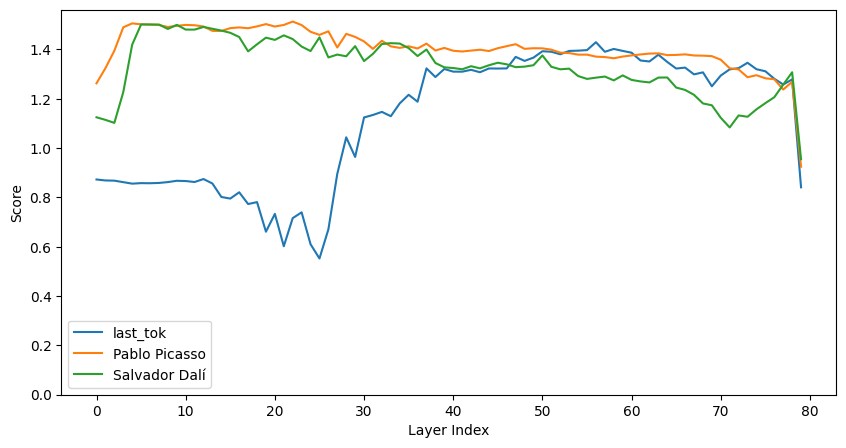

In [38]:
from src.trace import rank_reward
from matplotlib import pyplot as plt
import numpy as np

# METRIC = "prob"
METRIC = "logit"

category_scores = {category: [] for category in token_ranges.keys()}

for layer_idx in layer_indices:
    for key, token_range in token_ranges.items():
        cur_score = None
        for patch_from in token_range:
            # print(key, patch_from, layer_idx)
            ll_pred, ll_track = score_track[key][patch_from][layer_idx]
            score = getattr(ll_track[track_toks[0]][1], METRIC)
            denom = sum([getattr(pred, METRIC) for pred in ll_pred]) / len(ll_pred)
            score = score / denom
            # rank = ll_track[track_tok][0]
            # score = rank_reward(rank, k=20)
            cur_score = score if cur_score is None else max(cur_score, score)
        category_scores[key].append(cur_score)


plt.figure(figsize=(10, 5))
for key, scores in category_scores.items():
    # scores = np.array(scores) #/ getattr(ps_pred[0], METRIC)
    scores = np.array(scores)  # / max(scores)  # Normalize scores
    plt.plot(layer_indices, scores, label=key)

plt.legend()
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.ylim(bottom=0)

In [39]:
ll_track

{15506: (10,
  PredictedToken(token=' Spanish', prob=0.0135498046875, logit=8.5, token_id=15506, metadata=None))}

## Utility

In [15]:
from src.functional import interpret_logits, get_hs
from src.trace import get_score
from src.utils.typing import TokenizerOutput
from typing import Literal
from src.functional import generate_with_patch, PatchSpec


@torch.inference_mode()
def patched_run(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    ans_tokens: list[int],
    metric: Literal["logit", "prob"] = "logit",
    generate_full_ans: bool = False,
    **next_tok_kwargs,
):
    if generate_full_ans:
        answer = generate_with_patch(
            mt=mt,
            inputs=inputs,
            n_gen_per_prompt=1,
            do_sample=False,
            patches=patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=False,  # don't need to
            # patch_at_all_generations=True,    # will give the same result
            # use_cache = False,
        )
        print(f'"{answer[0]}"')

    logits = get_hs(
        mt=mt,
        input=inputs,
        locations=[(mt.lm_head_name, -1)],
        patches=patches,
        return_dict=False,
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt, logits=logits, interested_tokens=ans_tokens, **next_tok_kwargs
    )

    score = get_score(logits=logits, token_id=ans_tokens, metric=metric)

    return score, pred, track


gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    patches=[],
    ans_tokens=[next_probs[0].token_id],
    generate_full_ans=False,
    metric=METRIC,
    k=15,
)

print(f"{gold_score=}")
gold_pred

gold_score=21.0


[PredictedToken(token=' British', prob=0.7421875, logit=21.0, token_id=8013, metadata=None),
 PredictedToken(token=' English', prob=0.240234375, logit=19.875, token_id=6498, metadata=None),
 PredictedToken(token=' Scientist', prob=0.00439453125, logit=15.875, token_id=68409, metadata=None),
 PredictedToken(token=' nationality', prob=0.0020751953125, logit=15.125, token_id=59343, metadata=None),
 PredictedToken(token=' National', prob=0.00104522705078125, logit=14.4375, token_id=5165, metadata=None),
 PredictedToken(token=' ', prob=0.000675201416015625, logit=14.0, token_id=220, metadata=None),
 PredictedToken(token=' Professor', prob=0.000675201416015625, logit=14.0, token_id=17054, metadata=None),
 PredictedToken(token=' England', prob=0.0005950927734375, logit=13.875, token_id=9635, metadata=None),
 PredictedToken(token=' Mathematic', prob=0.0004634857177734375, logit=13.625, token_id=72140, metadata=None),
 PredictedToken(token=' Brit', prob=0.0004634857177734375, logit=13.625, toke

## independent enrichment vs countring

In [53]:
from src.functional import get_hs
from src.tokens import find_token_range, prepare_input
from itertools import product

entity_idx = 1
entity = probing_input.entities[entity_idx]
patch_prompt = " " + entity

patch_inputs = prepare_input(
    prompts=patch_prompt, tokenizer=mt, return_offsets_mapping=True
)

offset_mapping = patch_inputs.pop("offset_mapping")[0]
patch_from_range = find_token_range(
    string=patch_prompt,
    substring=entity,
    tokenizer=mt.tokenizer,
    offset_mapping=offset_mapping,
)

logger.debug(
    f'{patch_from_range=} | "{mt.tokenizer.decode(patch_inputs.input_ids[0][range(*patch_from_range)])}"'
)

patch_hs = get_hs(
    mt=mt,
    input=patch_inputs,
    locations=list(product(mt.layer_names, list(range(*patch_from_range)))),
    return_dict=True,
)


patchs = []

patch_to_range = probing_input.entity_ranges[entity_idx]
for patch_to in range(*patch_to_range):
    patch_from = (
        patch_to - patch_to_range[0] + patch_from_range[0]
    )  # adjust to patch_inputs range
    logger.debug(
        f'patch_from="{mt.tokenizer.decode(patch_inputs.input_ids[0][patch_from])}" | patch_to="{mt.tokenizer.decode(probing_input.tokenized["input_ids"][0][patch_to])}"'
    )
    for layer in mt.layer_names:
        patchs.append(
            PatchSpec(
                location=[layer, patch_to],
                patch=patch_hs[(layer, patch_from)],
            )
        )

patch_score, patch_pred, patch_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    patches=patchs,
    ans_tokens=[next_probs[0].token_id],
    metric=METRIC,
    k=15,
)

print(f"{patch_score=}")
indirect_effect = patch_score / gold_score
print(f"{indirect_effect=}")

patch_pred

2025-06-30 13:44:04 __main__ DEBUG    patch_from_range=(1, 3) | " Chopin"


2025-06-30 13:44:05 __main__ DEBUG    patch_from=" Chop" | patch_to=" Chop"
2025-06-30 13:44:05 __main__ DEBUG    patch_from="in" | patch_to="in"
patch_score=23.75
indirect_effect=0.9547738693467337


[PredictedToken(token=' Yes', prob=0.84375, logit=23.75, token_id=7566, metadata=None),
 PredictedToken(token=' No', prob=0.146484375, logit=22.0, token_id=2360, metadata=None),
 PredictedToken(token=' "', prob=0.0030517578125, logit=18.125, token_id=330, metadata=None),
 PredictedToken(token=' (', prob=0.0003643035888671875, logit=16.0, token_id=320, metadata=None),
 PredictedToken(token=' ', prob=0.0003643035888671875, logit=16.0, token_id=220, metadata=None),
 PredictedToken(token=' They', prob=0.0003643035888671875, logit=16.0, token_id=2435, metadata=None),
 PredictedToken(token=' Both', prob=0.00026702880859375, logit=15.6875, token_id=11995, metadata=None),
 PredictedToken(token=' \n', prob=0.00026702880859375, logit=15.6875, token_id=720, metadata=None),
 PredictedToken(token=' \n\n', prob=0.00018310546875, logit=15.3125, token_id=4815, metadata=None),
 PredictedToken(token=' yes', prob=0.000171661376953125, logit=15.25, token_id=10035, metadata=None),
 PredictedToken(token=' T

In [48]:
from src.functional import patchscope

context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

context_nat = """Name of a person -> their nationality
Hugh Jackman -> Australian
Michael Jackson -> American
Imran Khan -> Pakistani
placeholder ->"""

layer_idx = 15
patch_layers = [5]
# patch_layers = list(range(5, 16))

token_idx = patch_from_range[1] - 1
h = patch_hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5

# token_idx = patch_to_range[1] - 1
# # token_idx = -1
# h = hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5

patchscope(
    mt=mt,
    h=h,
    context=context_prof,
    placeholder="placeholder",
    patch_layers=[mt.layer_name_format.format(l) for l in patch_layers],
    add_orig_latent_to=mt.layer_name_format.format(layer_idx),
    k=15,
)

[PredictedToken(token=' artist', prob=0.796875, logit=21.625, token_id=10255, metadata=None),
 PredictedToken(token=' painter', prob=0.1572265625, logit=20.0, token_id=30581, metadata=None),
 PredictedToken(token=' surre', prob=0.034912109375, logit=18.5, token_id=25139, metadata=None),
 PredictedToken(token=' Surre', prob=0.0013580322265625, logit=15.25, token_id=55166, metadata=None),
 PredictedToken(token=' Artist', prob=0.00127410888671875, logit=15.1875, token_id=29459, metadata=None),
 PredictedToken(token=' visual', prob=0.0009918212890625, logit=14.9375, token_id=9302, metadata=None),
 PredictedToken(token=' (', prob=0.0009918212890625, logit=14.9375, token_id=320, metadata=None),
 PredictedToken(token='artist', prob=0.000774383544921875, logit=14.6875, token_id=19135, metadata=None),
 PredictedToken(token=' ', prob=0.0005645751953125, logit=14.375, token_id=220, metadata=None),
 PredictedToken(token=' Painter', prob=0.0004138946533203125, logit=14.0625, token_id=97864, metadat

In [43]:
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

track_toks = []

for entity in query_entities:
    context_subj = context.replace("placeholder", entity)
    top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
    print(f"{entity} => {top_pred}")
    track_toks.append(top_pred)
print("=" * 50)

track_toks = [p.token_id for p in track_toks]
track_toks = list(set(track_toks))  # remove duplicates
print([mt.tokenizer.decode(t) for t in track_toks])


context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
# layer_indices = list(range(mt.n_layer))
layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 6))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}

context_dict = {
    "profession": context_prof,
    "nationality": context_nat,
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)

score_track = {k: {} for k in token_ranges.keys()}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:

            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"]'
            )

            # z = patch_check(
            #     mt=mt,
            #     h=hs[(mt.layer_name_format.format(layer_idx), token_idx)] * 5,
            #     inp_layer=mt.layer_name_format.format(5),
            #     # out_layer=mt.layer_names[-1],
            #     out_layer=mt.lm_head_name,
            #     context=context_tok,
            #     h_idx=h_idx,
            # )
            # # ll_pred, ll_track = logit_lens(mt=mt, h=z, k=15, interested_tokens=track_toks)
            # ll_pred, ll_track = interpret_logits(
            #     tokenizer=mt, logits=z, k=15, interested_tokens=track_toks
            # )
            for attr, context in context_dict.items():
                ll_pred, ll_track = patchscope(
                    mt=mt,
                    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)],
                    context=context,
                    placeholder="placeholder",
                    # context_tokenized=context_tok,
                    # placeholder_idx=h_idx,
                    patch_layers=patch_layers,
                    # add_orig_latent_to=mt.layer_names[-1], # logit lens
                    # add_orig_latent_to=mt.layer_name_format.format(layer_idx),
                    k=15,
                    interested_tokens=track_toks,
                )
                ll_fmt = [
                    f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                    for pred in ll_pred
                ]
                if token_idx not in score_track[key]:
                    score_track[key][token_idx] = []
                score_track[key][token_idx].append((ll_pred, ll_track))
                print(f"{attr} => {ll_fmt}")

        print()

    print("-" * 50)

Pablo Picasso => " Spanish"[15506] (p=0.996, logit=24.375)
Salvador Dalí => " Spanish"[15506] (p=0.992, logit=24.875)
[' Spanish']
layer_idx=5 (model.layers.5)
"last_tok" [-1] => " -"
token_idx=-1 [" -"]
profession => ['"?\n"[p=0.20, l=13.25]', '"?\n\n"[p=0.11, l=12.69]', '"?"[p=0.06, l=12.06]', '" -\n"[p=0.04, l=11.69]', '" \n"[p=0.02, l=11.19]', '" -"[p=0.02, l=11.06]', '" -\n\n"[p=0.02, l=11.00]', '" ("[p=0.02, l=10.88]', '"??"[p=0.02, l=10.81]', '" lawyer"[p=0.02, l=10.69]', '" computer"[p=0.01, l=10.50]', '" artist"[p=0.01, l=10.50]', '" software"[p=0.01, l=10.38]', '" politician"[p=0.01, l=10.31]', '" "[p=0.01, l=10.31]']
nationality => ['"?\n"[p=0.22, l=15.19]', '"?"[p=0.11, l=14.50]', '"?\n\n"[p=0.08, l=14.12]', '" -\n"[p=0.05, l=13.62]', '" -"[p=0.04, l=13.44]', '" ("[p=0.04, l=13.38]', '" Indian"[p=0.03, l=13.31]', '"??"[p=0.03, l=13.31]', '" British"[p=0.03, l=13.19]', '" \n"[p=0.02, l=13.00]', '" French"[p=0.02, l=12.69]', '" -\n\n"[p=0.01, l=12.44]', '" Russian"[p=0.01, l=

In [51]:
patch_layers

[5]

In [114]:
layer_idx = 35

h1 = torch.stack(
    [
        hs[(mt.layer_name_format.format(layer_idx), token_idx)]
        for token_idx in range(*probing_input.entity_ranges[0])
        # for token_idx in [probing_input.entity_ranges[0][1] - 1]
    ]
).mean(dim=0)

h2 = torch.stack(
    [
        hs[(mt.layer_name_format.format(layer_idx), token_idx)]
        for token_idx in range(*probing_input.entity_ranges[1])
        # for token_idx in [probing_input.entity_ranges[1][1] - 1]
    ]
).mean(dim=0)

h_norm_mean = ((h1 + h2) / 2).norm()
h1 = (h1 / h1.norm()) * h_norm_mean
h2 = (h2 / h2.norm()) * h_norm_mean

patchscope(
    mt=mt,
    h=h1 + h2,
    # h = h2,
    # context=context_prof,
    context=context_nat,
    placeholder="placeholder",
    # context_tokenized=context_tok,
    # placeholder_idx=h_idx,
    patch_layers= [
        mt.layer_name_format.format(layer_idx) for layer_idx in patch_layers
    ],
    # add_orig_latent_to=mt.layer_names[-1], # logit lens
    # add_orig_latent_to=mt.layer_name_format.format(layer_idx),
    k=15,
    interested_tokens=track_toks,
)

([PredictedToken(token=' French', prob=0.37890625, logit=17.75, token_id=8753, metadata=None),
  PredictedToken(token=' Polish', prob=0.333984375, logit=17.625, token_id=33084, metadata=None),
  PredictedToken(token=' Swiss', prob=0.045166015625, logit=15.625, token_id=30791, metadata=None),
  PredictedToken(token=' German', prob=0.045166015625, logit=15.625, token_id=6063, metadata=None),
  PredictedToken(token='?\n', prob=0.032958984375, logit=15.3125, token_id=18072, metadata=None),
  PredictedToken(token='??', prob=0.015625, logit=14.5625, token_id=9602, metadata=None),
  PredictedToken(token='?', prob=0.0146484375, logit=14.5, token_id=949, metadata=None),
  PredictedToken(token=' (', prob=0.0137939453125, logit=14.4375, token_id=320, metadata=None),
  PredictedToken(token=' Austrian', prob=0.00787353515625, logit=13.875, token_id=58069, metadata=None),
  PredictedToken(token=' Not', prob=0.00421142578125, logit=13.25, token_id=2876, metadata=None),
  PredictedToken(token=' \n', p

In [55]:
from src.probing.prompt import ProbingPrompt


def patch_entity_from_different_run(
    mt: ModelandTokenizer,
    probing_input: ProbingPrompt,
    patch_entity_idx: int = 1,
    different_context: str = " {}",
    answer_token: int = None,
    track_tokens: list[int] = [],
    metric: Literal["logit", "prob"] = "logit",
) -> float:
    """
    Patches the entity in the connection setting with latents cached from a different context.
    Returns the indirect effect on the original output.
    """
    from src.functional import get_hs, PatchSpec
    from src.utils.typing import TokenizerOutput
    from src.tokens import prepare_input, find_token_range

    if answer_token is None:
        pred = predict_next_token(
            mt=mt,
            inputs=TokenizerOutput(data=probing_input.tokenized),
        )
        answer_token = pred[0][0].token_id  # take the first token prediction

    logger.debug(
        f'Answer token: {answer_token} ["{mt.tokenizer.decode(answer_token)}"]'
    )
    track_tokens = list(
        set(track_tokens + [answer_token])
    )  # ensure answer token is in track tokens

    # Run the clean probing input to get the gold score
    gold_score, gold_pred, gold_track = patched_run(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
        patches=[],
        ans_tokens=track_tokens,
        metric=metric,
    )

    pred_fmt = [
        f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]' for pred in gold_pred
    ]
    logger.debug(f"Gold score: {gold_score} | Predicted: {pred_fmt[:5]}")

    # Cache the latents for the patch entity from a different context
    entity = probing_input.entities[patch_entity_idx]
    patch_prompt = different_context.format(entity)
    patch_inputs = prepare_input(
        prompts=patch_prompt, tokenizer=mt, return_offsets_mapping=True
    )

    offset_mapping = patch_inputs.pop("offset_mapping")[0]
    patch_from_range = find_token_range(
        string=patch_prompt,
        substring=entity,
        tokenizer=mt.tokenizer,
        offset_mapping=offset_mapping,
    )

    # Cache latents from different context
    patch_hs = get_hs(
        mt=mt,
        input=patch_inputs,
        locations=[
            (layer, token_idx)
            for layer in mt.layer_names
            for token_idx in range(*patch_from_range)
        ],
        return_dict=True,
    )

    # Patch the entity in the probing input with the cached latents
    patches = []
    patch_to_range = probing_input.entity_ranges[patch_entity_idx]

    for patch_to in range(*patch_to_range):
        patch_from = (
            patch_to - patch_to_range[0] + patch_from_range[0]
        )  # adjust indices
        for layer in mt.layer_names:
            patches.append(
                PatchSpec(
                    location=[layer, patch_to],
                    patch=patch_hs[(layer, patch_from)],
                )
            )

    # Run the patched probing input to get the patched score
    patch_score, patch_pred, patch_track = patched_run(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
        patches=patches,
        ans_tokens=track_tokens,
        metric=metric,
    )

    patch_pred_fmt = [
        f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]' for pred in patch_pred
    ]
    logger.debug(f"Patched score: {patch_score} | Predicted: {patch_pred_fmt[:5]}")

    indirect_effect = patch_score / gold_score

    return indirect_effect, patch_pred, patch_track


patch_entity_from_different_run(
    mt=mt,
    probing_input=probing_input,
    patch_entity_idx=1,
    different_context=" {}",
    metric="logit",
)

2025-06-27 15:07:39 __main__ DEBUG    Answer token: 7566 [" Yes"]
2025-06-27 15:07:39 __main__ DEBUG    Gold score: 20.875 | Predicted: ['" Yes"[p=0.83, l=20.88]', '" No"[p=0.13, l=19.00]', '"?"[p=0.00, l=15.75]', '"??"[p=0.00, l=15.69]', '" ("[p=0.00, l=15.62]']
2025-06-27 15:07:39 __main__ DEBUG    Patched score: 20.75 | Predicted: ['" Yes"[p=0.87, l=20.75]', '" No"[p=0.09, l=18.50]', '"?"[p=0.00, l=15.56]', '" ""[p=0.00, l=15.44]', '"??"[p=0.00, l=15.38]']


(0.9940119760479041,
 [PredictedToken(token=' Yes', prob=0.8671875, logit=20.75, token_id=7566, metadata=None),
  PredictedToken(token=' No', prob=0.09130859375, logit=18.5, token_id=2360, metadata=None),
  PredictedToken(token='?', prob=0.00482177734375, logit=15.5625, token_id=949, metadata=None),
  PredictedToken(token=' "', prob=0.0042724609375, logit=15.4375, token_id=330, metadata=None),
  PredictedToken(token='??', prob=0.003997802734375, logit=15.375, token_id=9602, metadata=None)],
 {7566: (1,
   PredictedToken(token=' Yes', prob=0.8671875, logit=20.75, token_id=7566, metadata=None))})

In [46]:
import numpy as np

indirect_effects = []

yes_token = 7566
no_token = 2360

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")
    query_sample = sample.common_entity, sample.patched_entity
    probing_input = prepare_probing_input(
        mt=mt,
        entities=query_sample,
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        # answer_prefix=" Yes -",
    )

    gold_pred = predict_next_token(
        mt=mt,
        inputs=TokenizerOutput(data=probing_input.tokenized),
    )[0]
    answer_token = gold_pred[0].token_id  # take the first token prediction
    if answer_token != yes_token:
        pred_fmt = [
            f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
            for pred in gold_pred
        ]
        logger.warning(f"Skipping - didn't predict `\" Yes\"`: {pred_fmt[:5]}")
        print("x" * 50)
        continue

    indirect_effect, patch_pred, patch_track = patch_entity_from_different_run(
        mt=mt,
        probing_input=probing_input,
        patch_entity_idx=1,         #! entity index
        different_context=" {}",
        answer_token=sample.patched_answer_toks[0],
        track_tokens=[yes_token, no_token],
        metric="logit",
    )

    print(f"{query_sample} => {indirect_effect}")
    print("-" * 50)

    indirect_effects.append(indirect_effect)


np.mean(indirect_effects), np.std(indirect_effects)

0 => Grace Wanjiru | James Mwangi => " Ken" | <-- | Fatima Sheikh => " Urban"
2025-06-27 14:58:21 __main__ DEBUG    Answer token: 29422 [" Urban"]
2025-06-27 14:58:21 __main__ DEBUG    Gold score: 14.1875 | Predicted: ['" Yes"[p=0.89, l=21.25]', '" No"[p=0.06, l=18.62]', '"??"[p=0.00, l=16.00]', '"?"[p=0.00, l=15.94]', '" ""[p=0.00, l=15.81]']
2025-06-27 14:58:22 __main__ DEBUG    Patched score: 13.9375 | Predicted: ['" Yes"[p=0.91, l=21.12]', '" No"[p=0.05, l=18.25]', '"??"[p=0.01, l=16.00]', '" \n"[p=0.00, l=15.81]', '" ""[p=0.00, l=15.81]']
('Grace Wanjiru', 'Fatima Sheikh') => 0.9823788546255506
--------------------------------------------------
1 => Rahman Ali | Nasreen Begum => " Bang" | <-- | Takeshi Yamamoto => " Civil"
2025-06-27 14:58:23 __main__ DEBUG    Answer token: 16803 [" Civil"]
2025-06-27 14:58:23 __main__ DEBUG    Gold score: 14.5 | Predicted: ['" Yes"[p=0.95, l=21.38]', '" No"[p=0.03, l=17.88]', '" ""[p=0.00, l=15.56]', '"??"[p=0.00, l=15.25]', '"?"[p=0.00, l=15.25]

(np.float64(0.9821998144296827), np.float64(0.01307399470861126))

## Fuse SAE

In [65]:
from huggingface_hub import snapshot_download

sae_key = "Goodfire/Llama-3.3-70B-Instruct-SAE-l50"
sae_dir = os.path.join(env_utils.DEFAULT_MODELS_DIR, "sae", sae_key)

# snapshot_download(
#     repo_id=sae_key,
#     local_dir=sae_dir,
#     revision="main",
# )

! ls -lh {sae_dir}

total 4.1G
-rw-r--r-- 1 arnab research  480 Jun 27 15:08 config.yaml
-rw-r--r-- 1 arnab research 4.1G Jun 27 15:08 Llama-3.3-70B-Instruct-SAE-l50.pt
-rw-r--r-- 1 arnab research 3.3K Jun 27 15:08 README.md


In [66]:
class SparseAutoEncoder(torch.nn.Module):
    def __init__(
        self,
        d_in: int,
        d_hidden: int,
        device: torch.device,
        dtype: torch.dtype = torch.bfloat16,
    ):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.device = device
        self.encoder_linear = torch.nn.Linear(d_in, d_hidden)
        self.decoder_linear = torch.nn.Linear(d_hidden, d_in)
        self.dtype = dtype
        self.to(self.device, self.dtype)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode a batch of data using a linear, followed by a ReLU."""
        return torch.nn.functional.relu(self.encoder_linear(x))

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """Decode a batch of data using a linear."""
        return self.decoder_linear(x)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """SAE forward pass. Returns the reconstruction and the encoded features."""
        f = self.encode(x)
        return self.decode(f), f


def load_sae(
    path: str,
    device: torch.device = torch.device("cpu"),
    dtype: torch.dtype = torch.bfloat16,
):
    sae_dict = torch.load(path, weights_only=True, map_location=device)
    sae = SparseAutoEncoder(
        d_in=sae_dict["encoder_linear.weight"].shape[1],
        d_hidden=sae_dict["encoder_linear.weight"].shape[0],
        device=device,
        dtype=dtype,
    )
    sae.load_state_dict(sae_dict)

    return sae


sae = load_sae(
    path = os.path.join(sae_dir, "Llama-3.3-70B-Instruct-SAE-l50.pt"),
    device="cuda:7",
    dtype=mt.dtype,
)

In [83]:
from src.functional import get_module_nnsight
from dataclasses import dataclass

@dataclass(frozen=False)
class SAE_Intervention:
    basis_idx: int
    token_idx: int
    set_value: float = 1.0

@torch.inference_mode()
def forward_with_sae(
    mt: ModelandTokenizer,
    sae: SparseAutoEncoder,
    input: str | TokenizerOutput,
    hook_point: str = mt.layer_name_format.format(50),
    sae_interventions: list[SAE_Intervention] = [],
    return_orig_activations: bool = False,
):
    if isinstance(input, str):
        input = prepare_input(prompts=input, tokenizer=mt)
    elif isinstance(input, TokenizerOutput):
        if "offset_mapping" in input:
            input.pop("offset_mapping")
    else:
        raise ValueError("Input must be a string or TokenizerOutput.")

    internvention_token_indices = list(set([it.token_idx for it in sae_interventions]))
    if -1 not in internvention_token_indices:
        internvention_token_indices.append(-1)
    sae_latents = {tok_idx: None for tok_idx in internvention_token_indices}
    orig_sae_latents = {tok_idx: None for tok_idx in internvention_token_indices}

    with mt.trace(input) as trace:
        module = get_module_nnsight(mt, hook_point)
        sae_input = module.output[0]

        for token_idx in internvention_token_indices:
            sae_latents[token_idx] = sae.encode(sae_input[:, token_idx, :]).save()
            orig_sae_latents[token_idx] = sae_latents[token_idx].clone().save()

        for intervention in sae_interventions:
            sae_latents[intervention.token_idx][
                :, intervention.basis_idx
            ] = intervention.set_value

        for token_idx, sae_latent in sae_latents.items():
            sae_output = sae.decode(sae_latent)
            module.output[0][:, token_idx, :] = sae_output

        # sae_output = sae.decode(sae_latent)
        # module.output[0][...] = sae_output

        output = mt.output.save()

    free_gpu_cache()

    if return_orig_activations:
        return output, sae_latents, orig_sae_latents
    return output


output = forward_with_sae(
    mt=mt,
    sae=sae,
    # input = input
    input=TokenizerOutput(data=probing_input.tokenized),
    hook_point=mt.layer_name_format.format(60),
)

interpret_logits(tokenizer=mt, logits=output.logits[:, -1], k=15)

[PredictedToken(token=' Spanish', prob=0.40625, logit=17.625, token_id=15506, metadata=None),
 PredictedToken(token=' Artist', prob=0.1318359375, logit=16.5, token_id=29459, metadata=None),
 PredictedToken(token=' Art', prob=0.10302734375, logit=16.25, token_id=5277, metadata=None),
 PredictedToken(token=' Painter', prob=0.0908203125, logit=16.125, token_id=97864, metadata=None),
 PredictedToken(token=' Spain', prob=0.037841796875, logit=15.25, token_id=18157, metadata=None),
 PredictedToken(token=' nationality', prob=0.03564453125, logit=15.1875, token_id=59343, metadata=None),
 PredictedToken(token=' National', prob=0.0260009765625, logit=14.875, token_id=5165, metadata=None),
 PredictedToken(token=' profession', prob=0.016845703125, logit=14.4375, token_id=4913, metadata=None),
 PredictedToken(token=' Barcelona', prob=0.01483154296875, logit=14.3125, token_id=28035, metadata=None),
 PredictedToken(token=' artist', prob=0.01226806640625, logit=14.125, token_id=10255, metadata=None),


In [68]:
from src.utils.env_utils import load_env_var
import goodfire

gf_client = goodfire.Client(load_env_var("GOODFIRE_KEY"))

In [69]:
nationality_features = gf_client.features.search('nationality of a person', model=model_key, top_k=30)
profession_features = gf_client.features.search('profession of a person', model=model_key, top_k=30)

2025-06-30 14:04:34 asyncio DEBUG    Using selector: EpollSelector
2025-06-30 14:04:34 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-06-30 14:04:34 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'
2025-06-30 14:04:34 httpcore.connection DEBUG    connect_tcp.started host='api.goodfire.ai' port=443 local_address=None timeout=10 socket_options=None


2025-06-30 14:04:34 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f46701a2810>
2025-06-30 14:04:34 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7f4650194560> server_hostname='api.goodfire.ai' timeout=10
2025-06-30 14:04:34 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f465058cad0>
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'GET']>
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_headers.complete
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_body.started request=<Request [b'GET']>
2025-06-30 14:04:34 httpcore.http11 DEBUG    send_request_body.complete
2025-06-30 14:04:34 httpcore.http11 DEBUG    receive_response_headers.started request=<Request [b'GET']>
2025-06-30 14:04:34 httpcore.http11 DEBUG    receive_response_headers.complete return_value

In [70]:
nationality_features

FeatureGroup([
   0: "Nationality adjectives used as attributive descriptors",
   1: "Nationality and country name suffixes",
   2: "Nationality and ethnicity markers in cross-cultural contexts",
   3: "Discussions of nationalism and national identity across languages",
   4: "National cultural identity adjectives",
   5: "Biographical introductory phrases, especially nationality and profession",
   6: "Romance language suffixes indicating nationality or profession",
   7: "Cross-lingual detection of nationalism and national identity concepts",
   8: "Legal status and rights of non-citizens and residents",
   ...
   29: "Personal pronouns and informal speech markers across multiple languages"
])

In [71]:
profession_features

FeatureGroup([
   0: "Professional and creative occupations",
   1: "Professional qualification terms in job-related contexts",
   2: "Professional expressions of taking responsibility or commitment",
   3: "Listing professional qualifications or job responsibilities, especially in healthcare",
   4: "The assistant taking professional responsibility or making commitments",
   5: "Expressions of having moral or professional obligations",
   6: "Professional offering capabilities or services to clients",
   7: "Formal expressions of commitment or dedication in professional contexts",
   8: "Descriptions of someone's professional capabilities and achievements",
   ...
   29: "Professional and formal qualities in communication and performance"
])

In [72]:
probing_input.entity_ranges

((247, 249), (250, 252))

In [84]:
amplify_feature = profession_features
suppress_feature = nationality_features

# amplify_feature, suppress_feature = suppress_feature, amplify_feature

sae_interventions = []

for feature in suppress_feature:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature.index_in_sae,
            token_idx=-1,
            set_value=0,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

################################
set_val = 2.0
################################
for feature in amplify_feature:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature.index_in_sae,
            token_idx=-1,
            set_value=set_val,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

output, modified_latents, orig_latents = forward_with_sae(
    mt = mt, sae = sae, 
    input = TokenizerOutput(data=probing_input.tokenized),
    sae_interventions=sae_interventions,
    return_orig_activations=True,
    hook_point=mt.layer_name_format.format(50),
)

interpret_logits(
    tokenizer=mt,
    logits = output.logits[:, -1],
    k=15
)

[PredictedToken(token=' Spanish', prob=0.6015625, logit=18.625, token_id=15506, metadata=None),
 PredictedToken(token=' -', prob=0.07177734375, logit=16.5, token_id=482, metadata=None),
 PredictedToken(token=' in', prob=0.04345703125, logit=16.0, token_id=304, metadata=None),
 PredictedToken(token=' nationality', prob=0.0299072265625, logit=15.625, token_id=59343, metadata=None),
 PredictedToken(token=' artist', prob=0.0299072265625, logit=15.625, token_id=10255, metadata=None),
 PredictedToken(token=' and', prob=0.0263671875, logit=15.5, token_id=323, metadata=None),
 PredictedToken(token=' painter', prob=0.0263671875, logit=15.5, token_id=30581, metadata=None),
 PredictedToken(token=' Artist', prob=0.0263671875, logit=15.5, token_id=29459, metadata=None),
 PredictedToken(token=' Spain', prob=0.012451171875, logit=14.75, token_id=18157, metadata=None),
 PredictedToken(token=',', prob=0.012451171875, logit=14.75, token_id=11, metadata=None),
 PredictedToken(token=' Catalan', prob=0.010

In [85]:
# for feature in suppress_feature:
for feature in amplify_feature:
    sae_index = feature.index_in_sae
    print(f"{feature.label} | index={sae_index} | orig: {orig_latents[-1][0][sae_index]}, modified: {modified_latents[-1][0][sae_index]}")

Professional and creative occupations | index=10256 | orig: 0.0, modified: 2.0
Professional qualification terms in job-related contexts | index=55979 | orig: 0.0, modified: 2.0
Professional expressions of taking responsibility or commitment | index=57645 | orig: 0.0, modified: 2.0
Listing professional qualifications or job responsibilities, especially in healthcare | index=50025 | orig: 0.0, modified: 2.0
The assistant taking professional responsibility or making commitments | index=11114 | orig: 0.0, modified: 2.0
Expressions of having moral or professional obligations | index=30865 | orig: 0.0, modified: 2.0
Professional offering capabilities or services to clients | index=10457 | orig: 0.0, modified: 2.0
Formal expressions of commitment or dedication in professional contexts | index=26441 | orig: 0.0, modified: 2.0
Descriptions of someone's professional capabilities and achievements | index=21220 | orig: 0.0, modified: 2.0
The offering of professional services or skills | index=3661

In [86]:
amplify_indices = [feature.index_in_sae for feature in amplify_feature]
suppress_indices = [feature.index_in_sae for feature in suppress_feature]

common = set(amplify_indices) & set(suppress_indices)
print(f"Common indices: {common}")

Common indices: set()


In [87]:
profession_features[0].index_in_sae

10256

In [88]:
# lookup = gf_client.features.lookup(
#     indices = [profession_features[0].index_in_sae],
#     model=model_key,
# )

In [89]:
orig_topk = orig_latents[-1].topk(50, dim=-1)
indices = orig_topk.indices[0].tolist()
lookup = gf_client.features.lookup(
    indices = indices,
    model=model_key,
)

2025-06-30 14:07:31 asyncio DEBUG    Using selector: EpollSelector
2025-06-30 14:07:31 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-06-30 14:07:31 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'
2025-06-30 14:07:31 httpcore.connection DEBUG    connect_tcp.started host='api.goodfire.ai' port=443 local_address=None timeout=10 socket_options=None
2025-06-30 14:07:31 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f4650502410>
2025-06-30 14:07:31 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7f46501948c0> server_hostname='api.goodfire.ai' timeout=10
2025-06-30 14:07:31 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7f492d8c6710>
2025-06-30 14:07:31 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'POST']>
2025-06-30 14:07

In [90]:
for i, (value, index) in enumerate(zip(orig_topk.values[0], orig_topk.indices[0])):
    print(f"{index}={value:.2f} => {lookup[index.item()].label}")

14176=3.55 => Spanish historical transitions and periods of cultural change
54708=2.28 => Art historical explanations focusing on movements and their influence
36124=2.22 => Discussions of citizenship changes and naturalization processes
43285=2.12 => Character development and artistic growth narratives
13392=2.11 => The assistant is providing a list of options
2321=1.90 => Tourist itineraries and navigation instructions for Spanish cities
55137=1.84 => The assistant is providing a structured day-by-day travel itinerary
6769=1.77 => Data structure formatting elements in tables and lists
31343=1.77 => The assistant is providing a list of options
47163=1.67 => Biographical/definitional copula across languages ('was a'/'foi um'/etc)
9777=1.34 => Formal classifications and descriptions of occupations and professional roles
28822=1.34 => Traditional figure drawing and portraiture techniques, especially charcoal and pastels
41633=1.29 => Introductory phrases that precede descriptions or defi

In [107]:
# sae_latent = orig_latents[-1].squeeze()
# # for i in range(o)
# on_features = torch.nonzero(sae_latent > 0.5).squeeze().tolist()

# profession_direction = sae.decoder_linear.weight[:, profession_features[0].index_in_sae]
# nationality_direction = sae.decoder_linear.weight[:, nationality_features[0].index_in_sae]

# profession_cos_sim = []

# for idx in on_features:
#     current_direction = sae.decoder_linear.weight[:, idx]
#     cos_sim = torch.nn.functional.cosine_similarity(
#         profession_direction.unsqueeze(0), current_direction.unsqueeze(0)
#     )
#     profession_cos_sim.append((idx, cos_sim.item()))

# profession_cos_sim = sorted(profession_cos_sim, key=lambda x: x[1], reverse=True)

# # sae_basis_directions = [
# #     sae.decoder_linear.weight[:, idx] for idx in on_features
# # ]

In [113]:
nationality_indices = [
14176, 36124
]

profession_indices = [
54708, 43285, 9777, 48941
]

In [120]:
sae_interventions = []

for feature in nationality_indices:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature,
            token_idx=-1,
            set_value=0,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=0,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

################################
set_val = 10.0
################################
for feature in profession_indices:
    # last token
    sae_interventions.append(
        SAE_Intervention(
            basis_idx=feature,
            token_idx=-1,
            set_value=set_val,
        )
    )
    # # entity_1
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[0])
    # ]
    # # entity_2
    # sae_interventions += [
    #     SAE_Intervention(
    #         basis_idx=feature.index_in_sae,
    #         token_idx=token_idx, 
    #         set_value=set_val,
    #     )
    #     for token_idx in range(*probing_input.entity_ranges[1])
    # ]

output, modified_latents, orig_latents = forward_with_sae(
    mt = mt, sae = sae, 
    input = TokenizerOutput(data=probing_input.tokenized),
    sae_interventions=sae_interventions,
    return_orig_activations=True,
    hook_point=mt.layer_name_format.format(50),
)

interpret_logits(
    tokenizer=mt,
    logits = output.logits[:, -1],
    k=15
)

[PredictedToken(token=' Profession', prob=0.2109375, logit=19.125, token_id=50311, metadata=None),
 PredictedToken(token=' Painter', prob=0.2109375, logit=19.125, token_id=97864, metadata=None),
 PredictedToken(token=' Spanish', prob=0.1640625, logit=18.875, token_id=15506, metadata=None),
 PredictedToken(token=' Artist', prob=0.1640625, logit=18.875, token_id=29459, metadata=None),
 PredictedToken(token=' profession', prob=0.099609375, logit=18.375, token_id=4913, metadata=None),
 PredictedToken(token=' Art', prob=0.068359375, logit=18.0, token_id=5277, metadata=None),
 PredictedToken(token=' Cub', prob=0.00927734375, logit=16.0, token_id=18521, metadata=None),
 PredictedToken(token=' V', prob=0.006378173828125, logit=15.625, token_id=650, metadata=None),
 PredictedToken(token=' Painting', prob=0.004974365234375, logit=15.375, token_id=55143, metadata=None),
 PredictedToken(token=' Prof', prob=0.00439453125, logit=15.25, token_id=8626, metadata=None),
 PredictedToken(token=' Spain', p

In [ ]:
# entity_set = "[Albert Einstein, Issac Newton, Marie Curie, Michael Jordan]"
# entity_set = "[Albert Einstein, Issac Newton, Marie Curie, Alan Turing]"
# entity_set = "[Leonardo da Vinci, Pablo Picasso, Tiger Woods, Andy Warhol]"
# entity_set = "[Jon Stewart, Taylor Swift, Quentin Tarantino, Hugh Jackman]"

entity_set = "[Hugh Jackman, Tom Cruise, Brad Pitt, Scarlett Johansson]"
# entity_set = "[Hugh Jackman, Elton John, Danny DeVito, Scarlett Johansson]"

test_prompt = f"""
Find the odd one out in the following list of famous people:
{entity_set}
Ans: Elton John"""

test_prompt = f"""
Find if there is a person in the following list that does not fit the pattern of the others:
If there is no such person, answer "No". Else, answer "Yes - <name of the person> - <reason how this person doesn't fit the pattern>".
{entity_set}
Ans:"""

generate_with_patch(
    mt=mt,
    inputs=test_prompt,
    n_gen_per_prompt=1,
    do_sample=False,
    patches=[],
    patch_strategy="replace",
    remove_prefix=True,
    patch_at_all_generations=False,  # don't need to
    # patch_at_all_generations=True,    # will give the same result
)[0]

' Yes - Scarlett Johansson - The other three are male actors, while Scarlett Johansson is a female'

## Logit Lens w/o representation drift

In [16]:
from src.functional import patchscope
from src.tokens import prepare_input, find_token_range
from src.operators.utils import patch as patch_check
from src.functional import interpret_logits

context_prof = """Name of a person -> their profession
Albert Einstein -> Physicist
Michael Jordan -> Basketball Player
Jack Ma -> Entrepreneur
placeholder ->"""

context_nat = """Name of a person -> their nationality
Hugh Jackman -> Australian
Michael Jackson -> American
Imran Khan -> Pakistani
placeholder ->"""

contexts = {
    "profession": context_prof,
    "nationality": context_nat,
}

track_toks = {}

for attribute, context in contexts.items():
    track_toks[attribute] = []
    for entity in query_entities:
        context_subj = context.replace("placeholder", entity)
        top_pred = predict_next_token(mt=mt, inputs=context_subj)[0][0]
        print(f"{entity} => {top_pred}")
        track_toks[attribute].append(top_pred)

print("=" * 50)

for attr, attr_track in track_toks.items():
    attr_track = [p.token_id for p in attr_track]
    attr_track = list(set(attr_track))  # remove duplicates
    print(attr, " > ", [mt.tokenizer.decode(t) for t in attr_track])
    track_toks[attr] = attr_track


context_tok = prepare_input(prompts=context, tokenizer=mt, return_offsets_mapping=True)

offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

###########################################################################
layer_indices = list(range(mt.n_layer))[::5]
# layer_indices = [5, 15, 25, 31, 33, 35, 37, 39, 41, 45, 55, 65, 75]
# layer_indices = [5, 35, 75]
patch_layers = [
    mt.layer_name_format.format(layer_idx) for layer_idx in list(range(5, 6))
]

token_ranges = {
    "last_tok": [-1],
    probing_input.entities[0]: list(range(*probing_input.entity_ranges[0])),
    probing_input.entities[1]: list(range(*probing_input.entity_ranges[1])),
}

context_dict = {
    "profession": context_prof,
    "nationality": context_nat,
}
###########################################################################

inputs = TokenizerOutput(data=probing_input.tokenized)

score_track = {
    attr: {k: {} for k in token_ranges.keys()} for attr in context_dict.keys()
}

for layer_idx in layer_indices:
    print(f"layer_idx={layer_idx} ({mt.layer_name_format.format(layer_idx)})")
    for key, token_range in token_ranges.items():
        print(
            f'"{key}" {token_range} => "{mt.tokenizer.decode(inputs.input_ids[0][token_range], skip_special_tokens=False)}"'
        )
        for token_idx in token_range:

            print(
                f'{token_idx=} ["{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}"]'
            )

            for attr, context in context_dict.items():
                ll_pred, ll_track = patchscope(
                    mt=mt,
                    h=hs[(mt.layer_name_format.format(layer_idx), token_idx)],
                    context=context,
                    placeholder="placeholder",
                    # context_tokenized=context_tok,
                    # placeholder_idx=h_idx,
                    patch_layers=patch_layers,
                    # add_orig_latent_to=mt.layer_names[-1], # logit lens
                    # add_orig_latent_to=mt.layer_name_format.format(layer_idx),
                    k=15,
                    interested_tokens= track_toks[attr],
                )
                ll_fmt = [
                    f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                    for pred in ll_pred
                ]
                if token_idx not in score_track[attr][key]:
                    score_track[attr][key][token_idx] = {}
                score_track[attr][key][token_idx][layer_idx] = ((ll_pred, ll_track))
                print(f"{attr} => {ll_fmt}")

        print()

    print("-" * 50)

Issac Newton => " Phys"[13101] (p=0.754, logit=22.375)
Emma Watson => " Actress"[79539] (p=0.949, logit=24.250)
Issac Newton => " English"[6498] (p=0.555, logit=22.125)
Emma Watson => " British"[8013] (p=0.910, logit=23.875)
profession  >  [' Actress', ' Phys']
nationality  >  [' English', ' British']
layer_idx=0 (model.layers.0)
"last_tok" [-1] => " -"
token_idx=-1 [" -"]
profession => ['"??"[p=0.19, l=14.81]', '"?\n"[p=0.17, l=14.69]', '"???"[p=0.12, l=14.38]', '"?"[p=0.11, l=14.25]', '"?\n\n"[p=0.10, l=14.19]', '" Business"[p=0.03, l=12.81]', '" Lawyer"[p=0.02, l=12.44]', '" \n"[p=0.01, l=12.19]', '" Software"[p=0.01, l=11.88]', '" Programmer"[p=0.01, l=11.75]', '" Doctor"[p=0.01, l=11.56]', '" ("[p=0.01, l=11.56]', '"\n\n"[p=0.01, l=11.50]', '" "[p=0.01, l=11.25]', '" \n\n"[p=0.01, l=11.19]']
nationality => ['"??"[p=0.20, l=15.69]', '"?\n"[p=0.16, l=15.44]', '"?"[p=0.14, l=15.31]', '"?\n\n"[p=0.13, l=15.25]', '"???"[p=0.08, l=14.81]', '" Indian"[p=0.03, l=13.69]', '" French"[p=0.02

In [18]:
from src.trace import rank_reward
from matplotlib import pyplot as plt
import numpy as np

METRIC = "prob"
# METRIC = "logit"
plt.figure(figsize=(10, 5))


for attribute in track_toks.keys():
    for tok in track_toks[attribute]:
        scores = []
        for layer_idx in layer_indices:
            ll_pred, ll_track = score_track[attribute]["last_tok"][-1][layer_idx]
            # score = getattr(ll_track[tok][1], METRIC)
            # ll_pred = ll_pred[:5]
            # denom = sum([getattr(pred, METRIC) for pred in ll_pred]) / len(ll_pred)
            # score /= denom
            score = rank_reward(rank=ll_track[tok][0], k=30)
            scores.append(score)

        plt.plot(
            layer_indices,
            scores,
            label=f"{mt.tokenizer.decode(tok)} [{tok}]",
        )


# for key, scores in category_scores.items():
#     # scores = np.array(scores) #/ getattr(ps_pred[0], METRIC)
#     scores = np.array(scores)  # / max(scores)  # Normalize scores
#     plt.plot(layer_indices, scores, label=key)

plt.legend()
plt.xlabel("Layer Index")
plt.ylabel("Score")
plt.ylim(bottom=0)

2025-07-07 15:17:53 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-07-07 15:17:53 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib


2025-07-07 15:17:53 matplotlib DEBUG    interactive is False
2025-07-07 15:17:53 matplotlib DEBUG    platform is linux
2025-07-07 15:17:53 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-07-07 15:17:53 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-07-07 15:17:53 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-07 15:17:53 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.


KeyError: 8013

<Figure size 1000x500 with 0 Axes>

In [18]:
from src.functional import get_hs
import itertools
from src.utils.typing import ArrayLike, PredictedToken
from dataclasses_json import DataClassJsonMixin
from dataclasses import dataclass
import numpy as np


@dataclass(frozen=False)
class CachedStates(DataClassJsonMixin):
    query_entities: list[str]
    states: dict[tuple[str, int] | str, ArrayLike]
    model_predictions: list[str | PredictedToken]

    def detensorize(self):
        states_dten = {}
        for (layername, token_idx), value in self.states.items():
            key = f"{layername}__<>__{token_idx}"
            states_dten[key] = (
                value.tolist() if isinstance(value, torch.Tensor) else value
            )

        self.states = states_dten

    def retensorize(self):
        states_ten = {}
        for key, value in self.states.items():
            layername, token_idx = key.split("__<>__")
            states_ten[(layername, int(token_idx))] = (
                torch.tensor(value, dtype=torch.bfloat16)
                if isinstance(value, list)
                else value
            )


@dataclass(frozen=False)
class ProbeDirection(DataClassJsonMixin):
    directions: dict[str, ArrayLike]
    metadata: list[CachedStates] | None = None

    def detensorize(self):
        self.directions = {
            k: v.tolist() if isinstance(v, torch.Tensor) else v
            for k, v in self.directions.items()
        }
        if self.metadata is not None:
            for m in self.metadata:
                m.detensorize()

    def retensorize(self):
        self.directions = {
            k: (
                torch.tensor(v, dtype=torch.bfloat16)
                if isinstance(v, torch.Tensor) is False
                else v
            )
            for k, v in self.directions.items()
        }
        if self.metadata is not None:
            for m in self.metadata:
                m.retensorize()

    def from_dict(data: dict):
        """
        Convert a dictionary to a ProbeDirection object.
        """
        directions = {
            k: torch.tensor(v, dtype=torch.bfloat16) for k, v in data["directions"].items()
        }
        metadata = []
        for cached_state in data.get("metadata", []):
            cached_state = CachedStates(
                query_entities=cached_state["query_entities"],
                states={
                    tuple(k.split("__<>__")): torch.tensor(v, dtype=torch.bfloat16)
                    for k, v in cached_state["states"].items()
                },
                model_predictions=(
                    [PredictedToken(**pred) for pred in cached_state["model_predictions"]]
                    if isinstance(cached_state["model_predictions"], list)
                    else cached_state["model_predictions"]
                ),
            )
            metadata.append(cached_state)

        return ProbeDirection(directions=directions, metadata=metadata)
    
##################################################################
probe_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "probe")
##################################################################
os.makedirs(probe_dir, exist_ok=True)

In [19]:
probe_pairs = {
    "profession": {
        "actor": [
            "Scarlett Johansson",
            "Natalie Portman",
            "Meryl Streep",
            "Jennifer Lawrence",
            "Angelina Jolie",
            "Robert De Niro",
            "Tom Hanks",
            "Leonardo DiCaprio",
            "Brad Pitt",
            "Denzel Washington",
            "Julia Roberts",
            "Will Smith",
        ],
        "physicist": [
            "Albert Einstein",
            "Stephen Hawking",
            "Marie Curie",
            "Richard Feynman",
            "Niels Bohr",
            "Isaac Newton",
            "Galileo Galilei",
            "Werner Heisenberg",
            "Erwin Schrödinger",
            "Max Planck",
            "Enrico Fermi",
            "Robert Oppenheimer",
        ],
        "basketball player": [
            "Michael Jordan",
            "LeBron James",
            "Kobe Bryant",
            "Magic Johnson",
            "Larry Bird",
            "Shaquille O'Neal",
            "Tim Duncan",
            "Kareem Abdul-Jabbar",
            "Wilt Chamberlain",
            "Bill Russell",
            "Kevin Durant",
            "Stephen Curry",
        ],
        "entrepreneur": [
            "Jack Ma",
            "Elon Musk",
            "Bill Gates",
            "Steve Jobs",
            "Jeff Bezos",
            "Mark Zuckerberg",
            "Warren Buffett",
            "Richard Branson",
            "Larry Page",
            "Sergey Brin",
            "Oprah Winfrey",
            "Henry Ford",
        ],
        "singer": [
            "Taylor Swift",
            "Adele",
            "Beyoncé",
            "Whitney Houston",
            "Elvis Presley",
            "Michael Jackson",
            "Madonna",
            "Frank Sinatra",
            "Freddie Mercury",
            "Bob Dylan",
            "Aretha Franklin",
            "John Lennon",
        ],
        "director": [
            "Steven Spielberg",
            "Christopher Nolan",
            "Martin Scorsese",
            "Quentin Tarantino",
            "Alfred Hitchcock",
            "Stanley Kubrick",
            "Francis Ford Coppola",
            "James Cameron",
            "Woody Allen",
            "Ridley Scott",
            "Clint Eastwood",
            "Tim Burton",
        ],
        "chef": [
            "Gordon Ramsay",
            "Julia Child",
            "Anthony Bourdain",
            "Emeril Lagasse",
            "Wolfgang Puck",
            "Jamie Oliver",
            "Bobby Flay",
            "Rachael Ray",
            "Alain Ducasse",
            "Marco Pierre White",
            "Masaharu Morimoto",
            "Guy Fieri",
        ],
        "tennis player": [
            "Serena Williams",
            "Roger Federer",
            "Rafael Nadal",
            "Novak Djokovic",
            "Steffi Graf",
            "Pete Sampras",
            "Andre Agassi",
            "Martina Navratilova",
            "Björn Borg",
            "John McEnroe",
            "Venus Williams",
            "Andy Murray",
        ],
        "comedian": [
            "Dave Chappelle",
            "Jerry Seinfeld",
            "Robin Williams",
            "George Carlin",
            "Eddie Murphy",
            "Chris Rock",
            "Kevin Hart",
            "Ellen DeGeneres",
            "Louis C.K.",
            "Richard Pryor",
            "Jim Carrey",
            "Steve Martin",
        ],
        "author": [
            "Stephen King",
            "J.K. Rowling",
            "Ernest Hemingway",
            "Maya Angelou",
            "Mark Twain",
            "William Shakespeare",
            "Charles Dickens",
            "Agatha Christie",
            "George Orwell",
            "Jane Austen",
            "Gabriel García Márquez",
            "Leo Tolstoy",
        ],
        "american football": [
            "Tom Brady",
            "Peyton Manning",
            "Joe Montana",
            "Aaron Rodgers",
            "Brett Favre",
            "Jerry Rice",
            "Walter Payton",
            "Johnny Unitas",
            "Lawrence Taylor",
            "Jim Brown",
            "Barry Sanders",
            "Emmitt Smith",
        ],
        "soccer player": [
            "Lionel Messi",
            "Cristiano Ronaldo",
            "Pelé",
            "Diego Maradona",
            "Zinedine Zidane",
            "Ronaldinho",
            "Johan Cruyff",
            "Franz Beckenbauer",
            "Thierry Henry",
            "Ronaldo Nazário",
            "David Beckham",
            "Kylian Mbappé",
        ],
        "painter": [
            "Michelangelo",
            "Vincent van Gogh",
            "Pablo Picasso",
            "Leonardo da Vinci",
            "Claude Monet",
            "Rembrandt",
            "Salvador Dalí",
            "Andy Warhol",
            "Frida Kahlo",
            "Jackson Pollock",
            "Johannes Vermeer",
            "Henri Matisse",
        ],
    }
}

In [20]:
with open(
    "/disk/u/arnab/Codes/Projects/retrieval/data/synthetic_entities/test_72/profiles.json"
) as f:
    profiles = json.load(f)

occupations = [p["occupation"] for p in profiles]
nationalities = [p["country"] for p in profiles]

occupations = list(set(occupations))
nationalities = list(set(nationalities))

probe_pairs_synth = {
    # "profession": {occupation: [] for occupation in occupations},
    "nationality": {nationality: [] for nationality in nationalities}
}

probe_pairs_synth = {
    "profession": {
        "actor": [
            "Scarlett Johansson (American)",
            "Gérard Depardieu (French)",
            "Jackie Chan (Chinese)",
            "Amitabh Bachchan (Indian)",
            "Penélope Cruz (Spanish)",
            "Toshiro Mifune (Japanese)",
            "Sophia Loren (Italian)",
            "Gong Li (Chinese)",
            "Omar Sharif (Egyptian)",
            "Daniel Day-Lewis (British)",
            "Marion Cotillard (French)",
            "Javier Bardem (Spanish)",
        ],
        "physicist": [
            "Albert Einstein (German-American)",
            "Stephen Hawking (British)",
            "Marie Curie (Polish-French)",
            "C.V. Raman (Indian)",
            "Niels Bohr (Danish)",
            "Enrico Fermi (Italian)",
            "Hideki Yukawa (Japanese)",
            "Werner Heisenberg (German)",
            "Erwin Schrödinger (Austrian)",
            "Abdus Salam (Pakistani)",
            "Chen-Ning Yang (Chinese-American)",
            "Peter Higgs (British)",
        ],
        "basketball player": [
            "Michael Jordan (American)",
            "Yao Ming (Chinese)",
            "Dirk Nowitzki (German)",
            "Giannis Antetokounmpo (Greek)",
            "Manu Ginóbili (Argentinian)",
            "Tony Parker (French)",
            "Pau Gasol (Spanish)",
            "Hakeem Olajuwon (Nigerian-American)",
            "Steve Nash (Canadian)",
            "Dražen Petrović (Croatian)",
            "Arvydas Sabonis (Lithuanian)",
            "Oscar Schmidt (Brazilian)",
        ],
        "entrepreneur": [
            "Jack Ma (Chinese)",
            "Elon Musk (South African-American)",
            "Carlos Slim (Mexican)",
            "Mukesh Ambani (Indian)",
            "Richard Branson (British)",
            "Ingvar Kamprad (Swedish)",
            "Amancio Ortega (Spanish)",
            "Masayoshi Son (Japanese)",
            "Aliko Dangote (Nigerian)",
            "Johann Rupert (South African)",
            "Bernard Arnault (French)",
            "Dietrich Mateschitz (Austrian)",
        ],
        "singer": [
            "Shakira (Colombian)",
            "Edith Piaf (French)",
            "Andrea Bocelli (Italian)",
            "ABBA (Swedish)",
            "Julio Iglesias (Spanish)",
            "Miriam Makeba (South African)",
            "Ravi Shankar (Indian)",
            "Cesária Évora (Cape Verdean)",
            "Björk (Icelandic)",
            "Bob Marley (Jamaican)",
            "Umm Kulthum (Egyptian)",
            "Teresa Teng (Taiwanese)",
        ],
        "director": [
            "Akira Kurosawa (Japanese)",
            "Federico Fellini (Italian)",
            "Ingmar Bergman (Swedish)",
            "Pedro Almodóvar (Spanish)",
            "Bong Joon-ho (South Korean)",
            "Alejandro G. Iñárritu (Mexican)",
            "Satyajit Ray (Indian)",
            "Zhang Yimou (Chinese)",
            "Lars von Trier (Danish)",
            "Andrei Tarkovsky (Russian)",
            "Abbas Kiarostami (Iranian)",
            "Wim Wenders (German)",
        ],
        "chef": [
            "Joël Robuchon (French)",
            "Nobu Matsuhisa (Japanese)",
            "Ferran Adrià (Spanish)",
            "Massimo Bottura (Italian)",
            "René Redzepi (Danish)",
            "Alex Atala (Brazilian)",
            "Gaggan Anand (Indian)",
            "Virgilio Martínez (Peruvian)",
            "Heston Blumenthal (British)",
            "Paul Bocuse (French)",
            "Thomas Keller (American)",
            "Grant Achatz (American)",
        ],
        "tennis player": [
            "Roger Federer (Swiss)",
            "Rafael Nadal (Spanish)",
            "Novak Djokovic (Serbian)",
            "Björn Borg (Swedish)",
            "Rod Laver (Australian)",
            "Ivan Lendl (Czech-American)",
            "Boris Becker (German)",
            "Gustavo Kuerten (Brazilian)",
            "Lleyton Hewitt (Australian)",
            "Yannick Noah (French)",
            "Li Na (Chinese)",
            "Naomi Osaka (Japanese)",
        ],
        "comedian": [
            "Charlie Chaplin (British)",
            "Louis de Funès (French)",
            "Rowan Atkinson (British)",
            "Jim Carrey (Canadian)",
            "Russell Peters (Canadian)",
            "Trevor Noah (South African)",
            "Ricky Gervais (British)",
            "Gad Elmaleh (Moroccan-French)",
            "Cantinflas (Mexican)",
            "Roberto Benigni (Italian)",
            "Sacha Baron Cohen (British)",
            "Eddie Izzard (British)",
        ],
        "author": [
            "Gabriel García Márquez (Colombian)",
            "Haruki Murakami (Japanese)",
            "Chimamanda Ngozi Adichie (Nigerian)",
            "Isabel Allende (Chilean)",
            "Salman Rushdie (British-Indian)",
            "Umberto Eco (Italian)",
            "Milan Kundera (Czech-French)",
            "Orhan Pamuk (Turkish)",
            "Paulo Coelho (Brazilian)",
            "Aleksandr Solzhenitsyn (Russian)",
            "Naguib Mahfouz (Egyptian)",
            "Jorge Luis Borges (Argentinian)",
        ],
        "american football": [
            "Tom Brady (American)",
            "Peyton Manning (American)",
            "Joe Montana (American)",
            "Aaron Rodgers (American)",
            "Brett Favre (American)",
            "Jerry Rice (American)",
            "Walter Payton (American)",
            "Johnny Unitas (American)",
            "Lawrence Taylor (American)",
            "Jim Brown (American)",
            "Barry Sanders (American)",
            "Emmitt Smith (American)",
        ],
        "soccer player": [
            "Pelé (Brazilian)",
            "Diego Maradona (Argentinian)",
            "Johan Cruyff (Dutch)",
            "Franz Beckenbauer (German)",
            "Cristiano Ronaldo (Portuguese)",
            "Zinedine Zidane (French)",
            "Roberto Baggio (Italian)",
            "George Best (Northern Irish)",
            "Ferenc Puskás (Hungarian)",
            "Eusébio (Portuguese)",
            "Lev Yashin (Russian)",
            "Mohamed Salah (Egyptian)",
        ],
        "painter": [
            "Leonardo da Vinci (Italian)",
            "Vincent van Gogh (Dutch)",
            "Frida Kahlo (Mexican)",
            "Hokusai (Japanese)",
            "Wassily Kandinsky (Russian)",
            "Diego Rivera (Mexican)",
            "Gustav Klimt (Austrian)",
            "Edvard Munch (Norwegian)",
            "Francisco Goya (Spanish)",
            "William Turner (British)",
            "Zhang Daqian (Chinese)",
            "M.F. Husain (Indian)",
        ],
    },
    "nationality": {
        "Chilean": [
            "Pablo Neruda (poet)",
            "Isabel Allende (author)",
            "Gabriela Mistral (poet)",
            "Alexis Sánchez (footballer)",
            "Arturo Vidal (footballer)",
            "Michelle Bachelet (politician)",
            "Roberto Bolaño (author)",
            "Claudio Arrau (pianist)",
        ],
        "Indian": [
            "Mahatma Gandhi (activist)",
            "Sachin Tendulkar (cricketer)",
            "A.R. Rahman (composer)",
            "Amitabh Bachchan (actor)",
            "Priyanka Chopra (actress)",
            "Virat Kohli (cricketer)",
            "Ratan Tata (industrialist)",
            "Sundar Pichai (tech CEO)",
        ],
        "Greek": [
            "Giannis Antetokounmpo (basketball player)",
            "Maria Callas (opera singer)",
            "Aristotle Onassis (shipping magnate)",
            "Melina Mercouri (actress/politician)",
            "Vangelis (composer)",
            "Stefanos Tsitsipas (tennis player)",
            "Nikos Kazantzakis (author)",
            "Costa-Gavras (film director)",
        ],
        "Romanian": [
            "Nadia Comăneci (gymnast)",
            "Nicolae Ceaușescu (politician)",
            "Constantin Brâncuși (sculptor)",
            "Elie Wiesel (author)",
            "Simona Halep (tennis player)",
            "Eugene Ionesco (playwright)",
            "Mircea Eliade (historian)",
            "George Enescu (composer)",
        ],
        "Egyptian": [
            "Mohamed Salah (footballer)",
            "Omar Sharif (actor)",
            "Naguib Mahfouz (author)",
            "Anwar Sadat (president)",
            "Boutros Boutros-Ghali (UN Secretary-General)",
            "Umm Kulthum (singer)",
            "Ahmed Zewail (scientist)",
            "Mohamed ElBaradei (diplomat)",
        ],
        "Spanish": [
            "Pablo Picasso (artist)",
            "Rafael Nadal (tennis player)",
            "Penélope Cruz (actress)",
            "Antoni Gaudí (architect)",
            "Salvador Dalí (artist)",
            "Pau Gasol (basketball player)",
            "Pedro Almodóvar (film director)",
            "Plácido Domingo (opera singer)",
        ],
        "German": [
            "Albert Einstein (physicist)",
            "Angela Merkel (politician)",
            "Ludwig van Beethoven (composer)",
            "Michael Schumacher (F1 driver)",
            "Heidi Klum (model)",
            "Dirk Nowitzki (basketball player)",
            "Boris Becker (tennis player)",
            "Claudia Schiffer (model)",
        ],
        "Bangladeshi": [
            "Sheikh Mujibur Rahman (politician)",
            "Muhammad Yunus (economist)",
            "Fazlur Rahman Khan (engineer)",
            "Shakib Al Hasan (cricketer)",
            "Taslima Nasrin (author)",
            "Kazi Nazrul Islam (poet)",
            "Begum Rokeya (feminist writer)",
            "Tamim Iqbal (cricketer)",
        ],
        "Brazilian": [
            "Pelé (footballer)",
            "Gisele Bündchen (model)",
            "Ayrton Senna (F1 driver)",
            "Neymar (footballer)",
            "Paulo Coelho (author)",
            "Ronaldinho (footballer)",
            "Adriana Lima (model)",
            "Oscar Niemeyer (architect)",
        ],
        "Polish": [
            "Marie Curie (scientist)",
            "Pope John Paul II (religious leader)",
            "Frédéric Chopin (composer)",
            "Robert Lewandowski (footballer)",
            "Lech Wałęsa (politician)",
            "Roman Polanski (film director)",
            "Andrzej Wajda (film director)",
            "Wisława Szymborska (poet)",
        ],
        "Kenyan": [
            "Eliud Kipchoge (marathoner)",
            "Wangari Maathai (environmentalist)",
            "Lupita Nyong'o (actress)",
            "David Rudisha (runner)",
            "Ngugi wa Thiong'o (author)",
            "Catherine Ndereba (marathoner)",
            "Barack Obama Sr. (economist)",
            "Jomo Kenyatta (president)",
        ],
        "French": [
            "Napoleon Bonaparte (emperor)",
            "Coco Chanel (fashion designer)",
            "Marie Curie (scientist)",
            "Édith Piaf (singer)",
            "Zinedine Zidane (footballer)",
            "Brigitte Bardot (actress)",
            "Louis Pasteur (scientist)",
            "Victor Hugo (author)",
        ],
        "South Korean": [
            "BTS (musicians)",
            "Bong Joon-ho (film director)",
            "Park Chan-wook (film director)",
            "Son Heung-min (footballer)",
            "Ban Ki-moon (UN Secretary-General)",
            "Kim Yuna (figure skater)",
            "PSY (musician)",
            "BlackPink (musicians)",
        ],
        "American": [
            "Michael Jordan (basketball player)",
            "Oprah Winfrey (media mogul)",
            "Barack Obama (president)",
            "Beyoncé (singer)",
            "Elon Musk (entrepreneur)",
            "Taylor Swift (singer)",
            "LeBron James (basketball player)",
            "Serena Williams (tennis player)",
        ],
        "Nigerian": [
            "Chinua Achebe (author)",
            "Wole Soyinka (author)",
            "Fela Kuti (musician)",
            "Chimamanda Ngozi Adichie (author)",
            "Burna Boy (musician)",
            "Wizkid (musician)",
            "Hakeem Olajuwon (basketball player)",
            "Anthony Joshua (boxer)",
        ],
        "Moroccan": [
            "Achraf Hakimi (footballer)",
            "French Montana (rapper)",
            "Saad Lamjarred (singer)",
            "Leila Slimani (author)",
            "Hicham El Guerrouj (runner)",
            "Gad Elmaleh (comedian)",
            "RedOne (music producer)",
            "Nawal El Moutawakel (athlete)",
        ],
        "Filipino": [
            "Manny Pacquiao (boxer)",
            "Lea Salonga (singer/actress)",
            "José Rizal (national hero)",
            "Rodrigo Duterte (president)",
            "Imelda Marcos (first lady)",
            "Arnel Pineda (singer)",
            "Bruno Mars (singer)",
            "Charice (singer)",
        ],
        "Vietnamese": [
            "Ho Chi Minh (revolutionary leader)",
            "Nguyen Phu Trong (politician)",
            "Thich Nhat Hanh (monk)",
            "Nguyen Xuan Phuc (politician)",
            "Doan Thi Diem (poet)",
            "Trinh Cong Son (musician)",
            "Nguyen Du (poet)",
            "Pham Tuan (astronaut)",
        ],
        "Portuguese": [
            "Cristiano Ronaldo (footballer)",
            "José Mourinho (football manager)",
            "Luís de Camões (poet)",
            "Fernando Pessoa (poet)",
            "Amália Rodrigues (fado singer)",
            "José Saramago (author)",
            "Vasco da Gama (explorer)",
            "António Guterres (UN Secretary-General)",
        ],
        "Ghanaian": [
            "Kofi Annan (UN Secretary-General)",
            "Kwame Nkrumah (president)",
            "Michael Essien (footballer)",
            "Abedi Pele (footballer)",
            "Azumah Nelson (boxer)",
            "Yaa Asantewaa (queen mother)",
            "Asamoah Gyan (footballer)",
            "Jerry Rawlings (president)",
        ],
        "Turkish": [
            "Mustafa Kemal Atatürk (founder of Turkey)",
            "Orhan Pamuk (author)",
            "Nuri Bilge Ceylan (film director)",
            "Hakan Şükür (footballer)",
            "Tarkan (singer)",
            "Sezen Aksu (singer)",
            "Elif Shafak (author)",
            "Mesut Özil (footballer)",
        ],
        "Dutch": [
            "Vincent van Gogh (artist)",
            "Johan Cruyff (footballer)",
            "Rembrandt (artist)",
            "Anne Frank (diarist)",
            "Max Verstappen (F1 driver)",
            "Armin van Buuren (DJ)",
            "Robin van Persie (footballer)",
            "Tiësto (DJ)",
        ],
        "Australian": [
            "Hugh Jackman (actor)",
            "Nicole Kidman (actress)",
            "Steve Irwin (conservationist)",
            "Cate Blanchett (actress)",
            "Russell Crowe (actor)",
            "Kylie Minogue (singer)",
            "Chris Hemsworth (actor)",
            "Margot Robbie (actress)",
        ],
        "British": [
            "Queen Elizabeth II (monarch)",
            "Winston Churchill (prime minister)",
            "The Beatles (musicians)",
            "David Beckham (footballer)",
            "Stephen Hawking (physicist)",
            "William Shakespeare (playwright)",
            "J.K. Rowling (author)",
            "David Attenborough (naturalist)",
        ],
        "Mexican": [
            "Frida Kahlo (artist)",
            "Diego Rivera (artist)",
            "Salma Hayek (actress)",
            "Carlos Slim (businessman)",
            "Guillermo del Toro (film director)",
            "Javier Hernández (footballer)",
            "Canelo Álvarez (boxer)",
            "Luis Miguel (singer)",
        ],
        "Russian": [
            "Vladimir Putin (president)",
            "Leo Tolstoy (author)",
            "Fyodor Dostoevsky (author)",
            "Maria Sharapova (tennis player)",
            "Rudolf Nureyev (ballet dancer)",
            "Yuri Gagarin (cosmonaut)",
            "Mikhail Baryshnikov (ballet dancer)",
            "Alexander Ovechkin (hockey player)",
        ],
        "Swedish": [
            "Alfred Nobel (inventor)",
            "Greta Thunberg (activist)",
            "ABBA (musicians)",
            "Zlatan Ibrahimović (footballer)",
            "Ingmar Bergman (film director)",
            "Björn Borg (tennis player)",
            "Astrid Lindgren (author)",
            "Max von Sydow (actor)",
        ],
        "Japanese": [
            "Akira Kurosawa (film director)",
            "Yoko Ono (artist)",
            "Hayao Miyazaki (animator)",
            "Naomi Osaka (tennis player)",
            "Haruki Murakami (author)",
            "Shohei Ohtani (baseball player)",
            "Ichiro Suzuki (baseball player)",
            "Akira Toriyama (manga artist)",
        ],
        "Norwegian": [
            "Magnus Carlsen (chess player)",
            "Edvard Munch (artist)",
            "Henrik Ibsen (playwright)",
            "A-ha (musicians)",
            "Edvard Grieg (composer)",
            "Roald Amundsen (explorer)",
            "Ole Gunnar Solskjær (footballer)",
            "Liv Ullmann (actress)",
        ],
        "Canadian": [
            "Justin Trudeau (prime minister)",
            "Drake (rapper)",
            "Justin Bieber (singer)",
            "Celine Dion (singer)",
            "Ryan Reynolds (actor)",
            "Wayne Gretzky (hockey player)",
            "Jim Carrey (actor)",
            "Margaret Atwood (author)",
        ],
        "Iranian": [
            "Cyrus the Great (emperor)",
            "Rumi (poet)",
            "Omar Khayyam (poet/mathematician)",
            "Abbas Kiarostami (film director)",
            "Shirin Ebadi (Nobel laureate)",
            "Asghar Farhadi (film director)",
            "Ali Daei (footballer)",
            "Googoosh (singer)",
        ],
        "Pakistani": [
            "Malala Yousafzai (activist)",
            "Imran Khan (cricketer/politician)",
            "Benazir Bhutto (prime minister)",
            "Abdul Sattar Edhi (philanthropist)",
            "Wasim Akram (cricketer)",
            "Nusrat Fateh Ali Khan (singer)",
            "Abdus Salam (physicist)",
            "Shahid Afridi (cricketer)",
        ],
        "Argentine": [
            "Lionel Messi (footballer)",
            "Pope Francis (religious leader)",
            "Diego Maradona (footballer)",
            "Che Guevara (revolutionary)",
            "Jorge Luis Borges (author)",
            "Eva Perón (first lady)",
            "Manu Ginóbili (basketball player)",
            "Mercedes Sosa (singer)",
        ],
        "Thai": [
            "Tony Jaa (actor/martial artist)",
            "King Bhumibol Adulyadej (monarch)",
            "Apichatpong Weerasethakul (film director)",
            "Buakaw Banchamek (kickboxer)",
            "Tata Young (singer)",
            "Khaosai Galaxy (boxer)",
            "Utt Panichkul (actor/model)",
            "Araya A. Hargate (actress)",
        ],
        "Israeli": [
            "Gal Gadot (actress)",
            "Natalie Portman (actress)",
            "Benjamin Netanyahu (prime minister)",
            "Golda Meir (prime minister)",
            "Daniel Kahneman (psychologist)",
            "Amos Oz (author)",
            "Bar Refaeli (model)",
            "Itzhak Perlman (violinist)",
        ],
        "Italian": [
            "Leonardo da Vinci (artist/inventor)",
            "Sophia Loren (actress)",
            "Roberto Benigni (actor/director)",
            "Luciano Pavarotti (opera singer)",
            "Giorgio Armani (fashion designer)",
            "Monica Bellucci (actress)",
            "Andrea Bocelli (singer)",
            "Valentino Rossi (motorcycle racer)",
        ],
    },
}


for attribute_type in probe_pairs_synth.keys():
    for attribute in probe_pairs_synth[attribute_type].keys():
        names = []
        for name in probe_pairs_synth[attribute_type][attribute]:
            names.append(name.split("(")[0].strip())
        probe_pairs_synth[attribute_type][attribute] = names

# probe_pairs["nationality"] = probe_pairs_synth["nationality"]
probe_pairs = probe_pairs_synth

In [21]:
for attr in probe_pairs.keys():
    print("-" * 50)
    print(attr)
    print("-" * 50)
    for key in sorted(probe_pairs[attr].keys()):
        values = probe_pairs[attr][key]
        print(f"    {key} ({len(values)}): {values}")

--------------------------------------------------
profession
--------------------------------------------------
    actor (12): ['Scarlett Johansson', 'Gérard Depardieu', 'Jackie Chan', 'Amitabh Bachchan', 'Penélope Cruz', 'Toshiro Mifune', 'Sophia Loren', 'Gong Li', 'Omar Sharif', 'Daniel Day-Lewis', 'Marion Cotillard', 'Javier Bardem']
    american football (12): ['Tom Brady', 'Peyton Manning', 'Joe Montana', 'Aaron Rodgers', 'Brett Favre', 'Jerry Rice', 'Walter Payton', 'Johnny Unitas', 'Lawrence Taylor', 'Jim Brown', 'Barry Sanders', 'Emmitt Smith']
    author (12): ['Gabriel García Márquez', 'Haruki Murakami', 'Chimamanda Ngozi Adichie', 'Isabel Allende', 'Salman Rushdie', 'Umberto Eco', 'Milan Kundera', 'Orhan Pamuk', 'Paulo Coelho', 'Aleksandr Solzhenitsyn', 'Naguib Mahfouz', 'Jorge Luis Borges']
    basketball player (12): ['Michael Jordan', 'Yao Ming', 'Dirk Nowitzki', 'Giannis Antetokounmpo', 'Manu Ginóbili', 'Tony Parker', 'Pau Gasol', 'Hakeem Olajuwon', 'Steve Nash', 'Draž

In [52]:
import random
for attribute in probe_pairs.keys():
    print("#" * 50)
    print(f"{attribute}")
    print("#" * 50)

    attr_prefix_generator = prefix_generator_cls(
        filter_attributes=[attribute],
        format="_3",
    )

    set_seed(142)
    attr_prefix = attr_prefix_generator.get_prefix(
        n_valid=10,
        n_none=1,
    )
    print(attr_prefix)

    locations = [(layer_name, -1) for layer_name in mt.layer_names]
    lm_head_state = (mt.lm_head_name, -1)
    locations += [lm_head_state]
    locations = list(set(locations))

    attribute_dir = os.path.join(probe_dir, attribute)
    os.makedirs(attribute_dir, exist_ok=True)


    for shared_attr, entities in probe_pairs[attribute].items():
        print("-" * 50)
        print(f"Shared attribute: {shared_attr}")
        print("-" * 50)

        cached_states: list[CachedStates] = []
        for current_query_pair in list(itertools.combinations(entities, 2)):
            # random swap
            if random.random() < 0.5:
                current_query_pair = (current_query_pair[1], current_query_pair[0])

            current_input = prepare_probing_input(
                mt=mt,
                entities=current_query_pair,
                prefix=prefix,
                answer_marker=attr_prefix_generator.answer_marker,
                question_marker=attr_prefix_generator.question_marker,
                block_separator=attr_prefix_generator.block_separator,
                is_a_reasoning_model=False,
                answer_prefix=" Yes -",
            )

            probe_hs = get_hs(
                mt=mt,
                input=TokenizerOutput(data=current_input.tokenized),
                locations=locations,
                return_dict=True,
            )

            logits = probe_hs[(mt.lm_head_name, -1)]
            cur_top_preds = interpret_logits(
                tokenizer=mt,
                logits=logits,
                k=15,
            )

            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in cur_top_preds
            ]
            print(f"{current_query_pair} => {ll_fmt[:5]}")

            cached_states.append(
                CachedStates(
                    query_entities=list(current_query_pair),
                    states=probe_hs,
                    model_predictions=cur_top_preds,
                )
            )
        
        probe_directions = {
            layer_name: [] for layer_name in mt.layer_names
        }
        for cached_state in cached_states:
            for layer_name in mt.layer_names:
                probe_directions[layer_name].append(
                    cached_state.states[(layer_name, -1)]
                )
        
        probe_directions = ProbeDirection(
            directions={
                layer_name: torch.stack(directions, dim=0).mean(dim=0)
                for layer_name, directions in probe_directions.items()
            },
            metadata=cached_states,
        )

        probe_directions.detensorize()
        probe_path = os.path.join(
            attribute_dir, f"{shared_attr}.json"
        )
        print("saving to >>", probe_path)
        with open(probe_path, "w") as f:
            f.write(probe_directions.to_json())
    
    print()

##################################################
profession
##################################################
2025-07-06 15:32:30 src.utils.experiment_utils INFO     setting all seeds to 142


# Task: Check if Two People Share the Same [attribute]
You will be given two people's names. Your job is to determine if they share the same [attribute].
# Response Format:
If you find a match: Yes - [profession] - they are both [profession]
If no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"

Q: Person C and Person D
A: Yes - Carpenter - they are both carpenters.

Q: Person C and Person D
A: No - Person C is a doctor while Person D is an engineer.

## Your turn, give your answer in a single line.
--------------------------------------------------
Shared attribute: actor
--------------------------------------------------
('Scarlett Johansson', 'Gérard Depardieu') => ['" Actor"[p=0.82, l=23.62]', '" actor"[p=0.13, l=21.75]', '" Actors"[p=0.02, l=19.62]', '" Actress"[p=0.01, l=19.50]', '" actors"[p=0.01, l=18.88]']
('Scarlett Johansson', 'Jackie Chan') => ['" Actor"[p=0.80, l=22.75]', '" actor"[p=0.14, l=21.00]', '" Actors"[p=0.01, l=18.62]', '" Actres

In [22]:
probe_directions = {}
attributes = list(probe_pairs.keys())

for attribute in attributes:
    attribute_path = os.path.join(probe_dir, attribute)
    print(attribute)
    probe_directions[attribute] = {}
    for file_name in os.listdir(attribute_path):
        if file_name.endswith(".json"):
            file_path = os.path.join(attribute_path, file_name)
            print(file_name, end=" ")
            with open(file_path, "r") as f:
                probe_directions[attribute][file_name[:-5]] = ProbeDirection.from_dict(
                    json.loads(f.read())
                )
    print()

profession
actor.json american football.json singer.json comedian.json painter.json director.json tennis player.json author.json basketball player.json physicist.json soccer player.json entrepreneur.json chef.json 
nationality
Vietnamese.json Italian.json Chilean.json Indian.json French.json American.json Portuguese.json Thai.json Iranian.json Norwegian.json German.json British.json Argentine.json Ghanaian.json Dutch.json Bangladeshi.json South Korean.json Pakistani.json Romanian.json Japanese.json Moroccan.json Brazilian.json Israeli.json Greek.json Canadian.json Kenyan.json Spanish.json Polish.json Filipino.json Australian.json Swedish.json Russian.json Nigerian.json Egyptian.json Mexican.json Turkish.json 


In [24]:
attributes = list(probe_pairs.keys())
# attributes = ["nationality"]

average_direction = {}
attribute_type_directions = {
    attr: {layername: [] for layername in mt.layer_names} for attr in attributes
}
for layer_name in mt.layer_names:
    average_direction[layer_name] = []
    for attribute in attributes:
        for shared_attr in probe_pairs[attribute].keys():
            cur_directions = probe_directions[attribute][shared_attr].directions[
                layer_name
            ]
            average_direction[layer_name].append(cur_directions)
            attribute_type_directions[attribute][layer_name].append(cur_directions)

    # average_direction[layer_name] = (
    #     torch.stack(average_direction[layer_name])
    #     .mean(dim=0)
    #     .to(mt.dtype)
    #     .to(mt.device)
    # )


for attribute in attributes:
    directions = {
        layer_name: torch.stack(attribute_type_directions[attribute][layer_name])
        .mean(dim=0)
        .to(mt.dtype)
        .to(mt.device)
        for layer_name in mt.layer_names
    }
    probe_directions[attribute][attribute] = ProbeDirection(
        directions=directions,
        metadata=None,
    )

for layer_name in mt.layer_names:
    avg_layer = []
    for attribute in attributes:
        avg_layer.append(probe_directions[attribute][attribute].directions[layer_name])

    average_direction[layer_name] = (
        torch.stack(avg_layer).mean(dim=0).to(mt.dtype).to(mt.device)
    )


# probe_directions[attribute]["average"] = average_direction

In [25]:
# list(probe_directions["nationality"].keys())

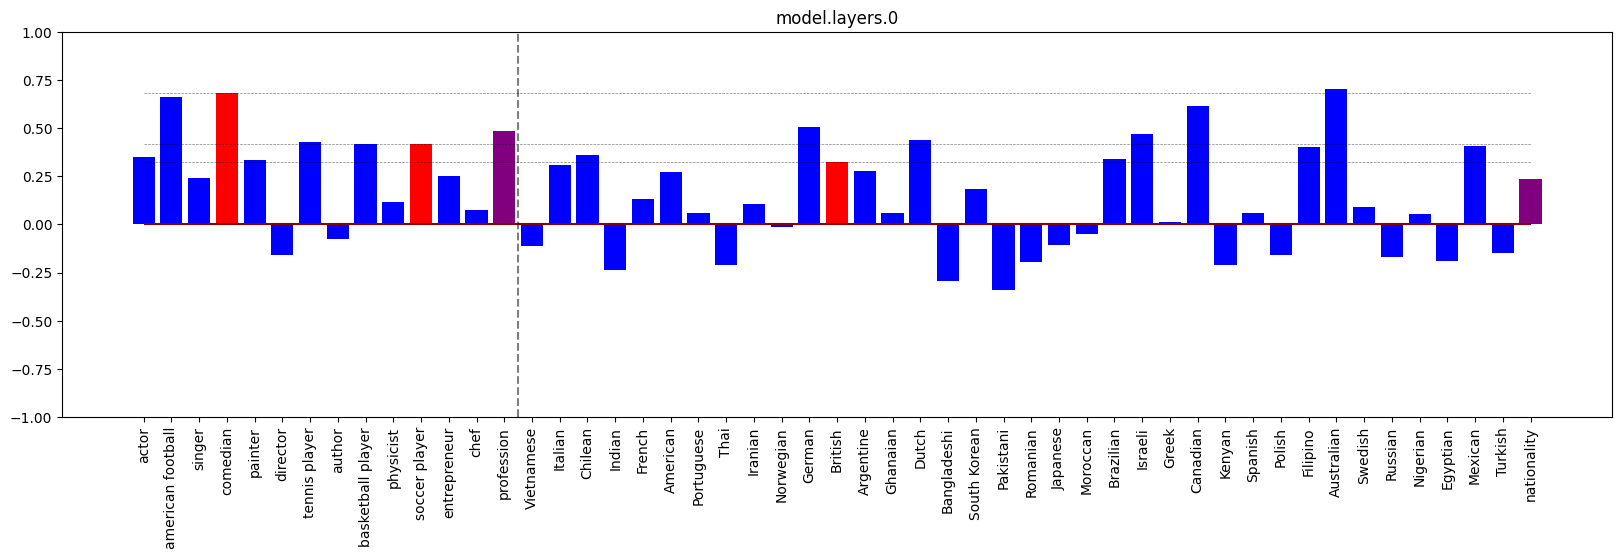

model.layers.0 => [('Australian', 0.703125), ('comedian', 0.68359375), ('american football', 0.6640625), ('Canadian', 0.6171875), ('German', 0.5078125), ('profession', 0.484375), ('Israeli', 0.470703125), ('Dutch', 0.439453125), ('tennis player', 0.42578125), ('basketball player', 0.419921875), ('soccer player', 0.416015625), ('Mexican', 0.40625), ('Filipino', 0.40234375), ('Chilean', 0.361328125), ('actor', 0.34765625), ('Brazilian', 0.341796875), ('painter', 0.33203125), ('British', 0.322265625), ('Italian', 0.30859375), ('Argentine', 0.275390625), ('American', 0.271484375), ('entrepreneur', 0.251953125), ('singer', 0.2421875), ('nationality', 0.23828125), ('South Korean', 0.185546875), ('French', 0.1328125), ('physicist', 0.115234375), ('Iranian', 0.10546875), ('Swedish', 0.087890625), ('chef', 0.07568359375), ('Spanish', 0.0615234375), ('Portuguese', 0.058349609375), ('Ghanaian', 0.0576171875), ('Nigerian', 0.052734375), ('Greek', 0.01300048828125), ('Norwegian', -0.0150146484375),

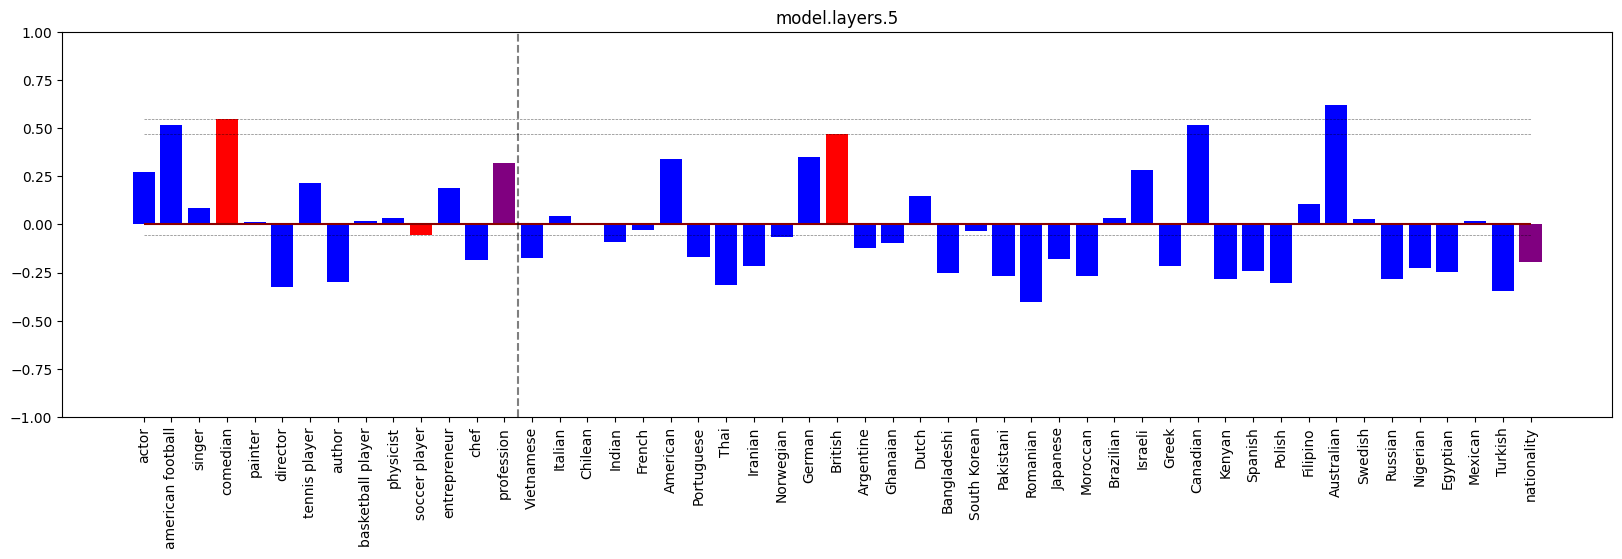

model.layers.5 => [('Australian', 0.62109375), ('comedian', 0.546875), ('american football', 0.515625), ('Canadian', 0.515625), ('British', 0.470703125), ('German', 0.349609375), ('American', 0.33984375), ('profession', 0.318359375), ('Israeli', 0.28515625), ('actor', 0.271484375), ('tennis player', 0.2138671875), ('entrepreneur', 0.1865234375), ('Dutch', 0.1484375), ('Filipino', 0.103515625), ('singer', 0.0859375), ('Italian', 0.04541015625), ('Brazilian', 0.0341796875), ('physicist', 0.031982421875), ('Swedish', 0.02685546875), ('basketball player', 0.01708984375), ('Mexican', 0.0169677734375), ('painter', 0.00994873046875), ('Chilean', 0.0081787109375), ('French', -0.031494140625), ('South Korean', -0.03271484375), ('soccer player', -0.05712890625), ('Norwegian', -0.06640625), ('Indian', -0.09130859375), ('Ghanaian', -0.09423828125), ('Argentine', -0.12109375), ('Portuguese', -0.171875), ('Vietnamese', -0.17578125), ('Japanese', -0.1806640625), ('chef', -0.1826171875), ('nationality

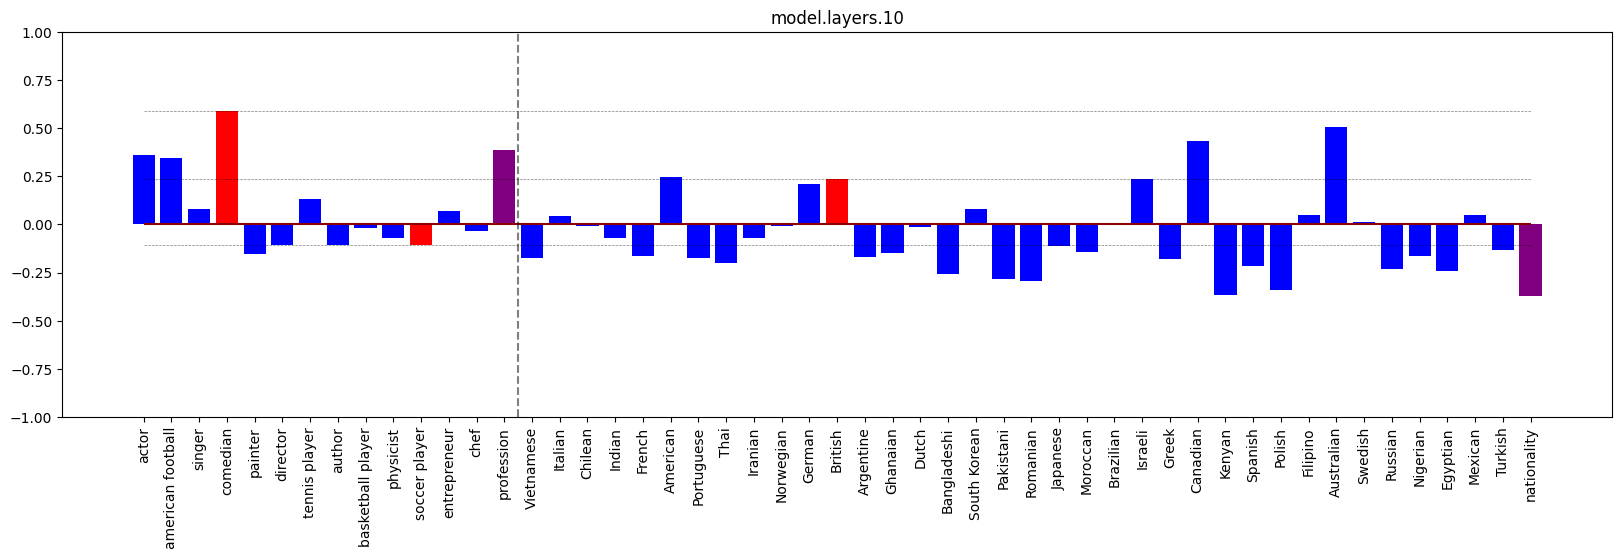

model.layers.10 => [('comedian', 0.58984375), ('Australian', 0.5078125), ('Canadian', 0.435546875), ('profession', 0.384765625), ('actor', 0.359375), ('american football', 0.34375), ('American', 0.2451171875), ('British', 0.2373046875), ('Israeli', 0.2353515625), ('German', 0.208984375), ('tennis player', 0.1337890625), ('South Korean', 0.0810546875), ('singer', 0.078125), ('entrepreneur', 0.0673828125), ('Mexican', 0.046875), ('Filipino', 0.046630859375), ('Italian', 0.044189453125), ('Swedish', 0.0133056640625), ('Brazilian', -0.0010833740234375), ('Chilean', -0.00762939453125), ('Norwegian', -0.0076904296875), ('Dutch', -0.01470947265625), ('basketball player', -0.0185546875), ('chef', -0.033447265625), ('Iranian', -0.06884765625), ('Indian', -0.06982421875), ('physicist', -0.072265625), ('soccer player', -0.10498046875), ('author', -0.10693359375), ('director', -0.10888671875), ('Japanese', -0.1142578125), ('Turkish', -0.1337890625), ('Moroccan', -0.14453125), ('Ghanaian', -0.14843

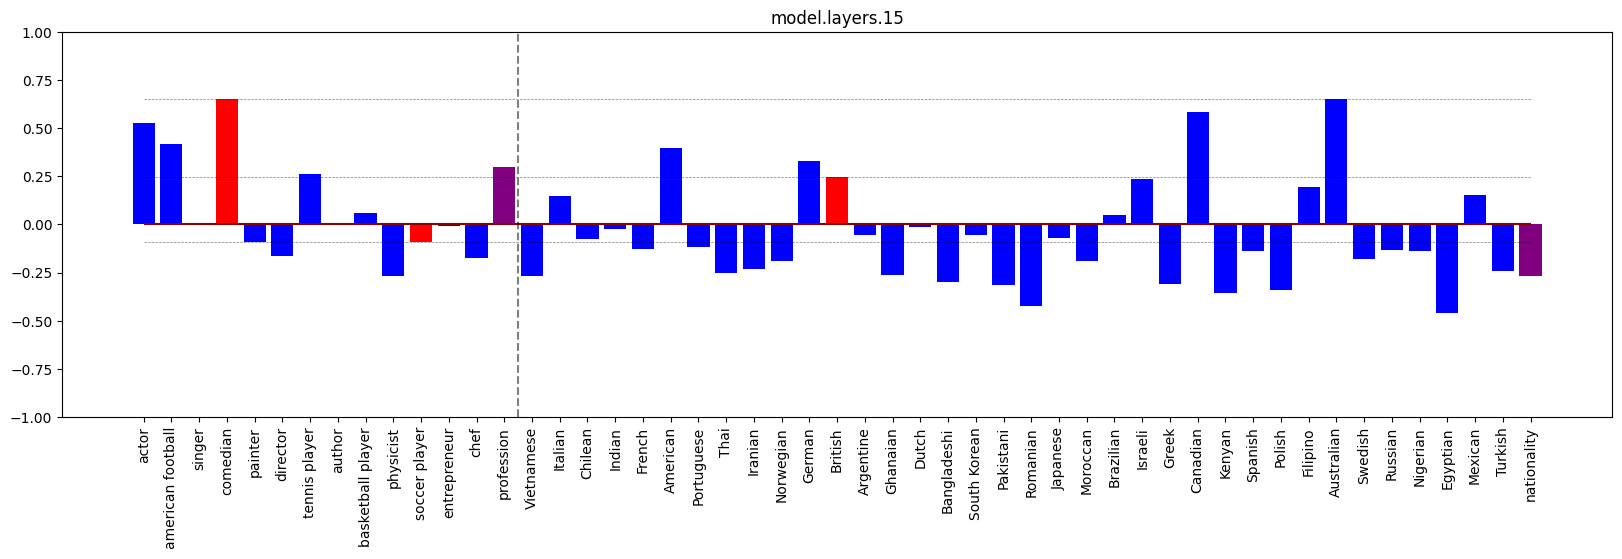

model.layers.15 => [('comedian', 0.65234375), ('Australian', 0.65234375), ('Canadian', 0.5859375), ('actor', 0.52734375), ('american football', 0.419921875), ('American', 0.396484375), ('German', 0.330078125), ('profession', 0.298828125), ('tennis player', 0.259765625), ('British', 0.244140625), ('Israeli', 0.23828125), ('Filipino', 0.193359375), ('Mexican', 0.150390625), ('Italian', 0.146484375), ('basketball player', 0.0595703125), ('Brazilian', 0.047119140625), ('singer', 0.005584716796875), ('author', 0.00457763671875), ('entrepreneur', -0.0068359375), ('Dutch', -0.01312255859375), ('Indian', -0.0228271484375), ('Argentine', -0.053955078125), ('South Korean', -0.054443359375), ('Japanese', -0.0693359375), ('Chilean', -0.07666015625), ('painter', -0.0908203125), ('soccer player', -0.09228515625), ('Portuguese', -0.11865234375), ('French', -0.1259765625), ('Russian', -0.1328125), ('Spanish', -0.1357421875), ('Nigerian', -0.140625), ('director', -0.1630859375), ('chef', -0.17578125), 

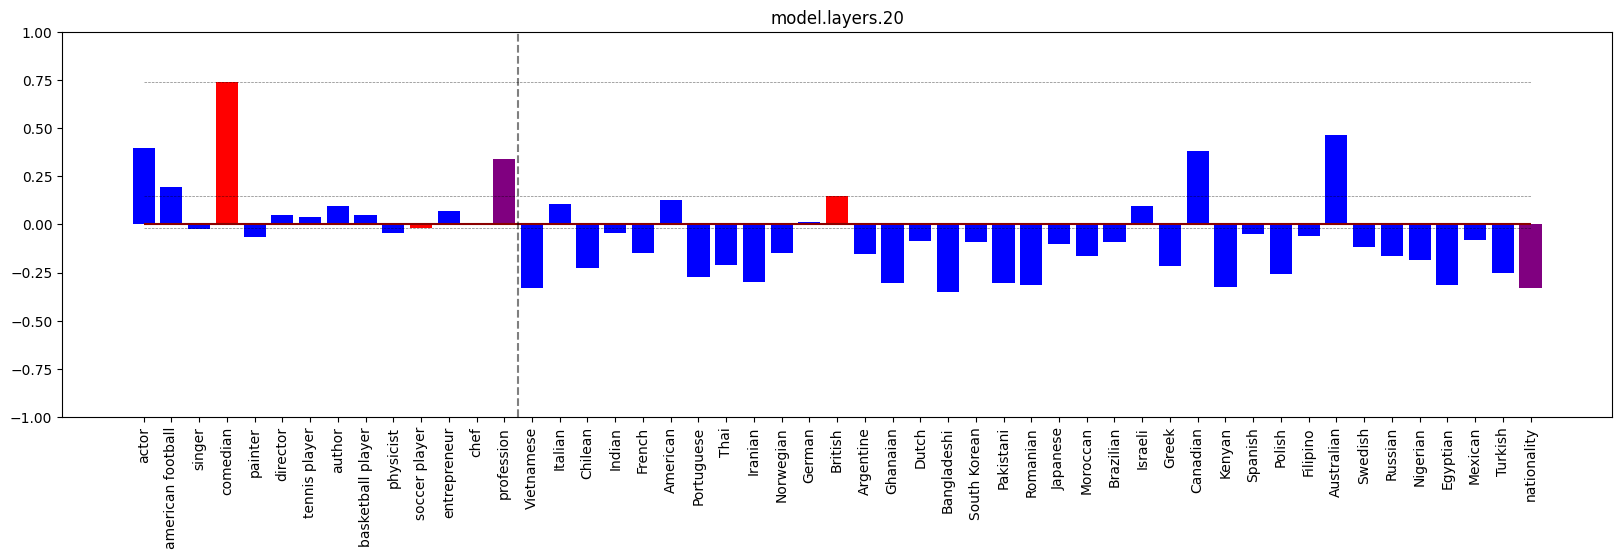

model.layers.20 => [('comedian', 0.7421875), ('Australian', 0.46484375), ('actor', 0.3984375), ('Canadian', 0.37890625), ('profession', 0.337890625), ('american football', 0.1943359375), ('British', 0.1484375), ('American', 0.125), ('Italian', 0.10595703125), ('author', 0.09765625), ('Israeli', 0.0966796875), ('entrepreneur', 0.06982421875), ('director', 0.051025390625), ('basketball player', 0.046630859375), ('tennis player', 0.03759765625), ('German', 0.01251220703125), ('chef', -0.001251220703125), ('soccer player', -0.0198974609375), ('singer', -0.025390625), ('physicist', -0.04345703125), ('Indian', -0.045166015625), ('Spanish', -0.048095703125), ('Filipino', -0.060546875), ('painter', -0.06591796875), ('Mexican', -0.0830078125), ('Dutch', -0.08544921875), ('Brazilian', -0.09033203125), ('South Korean', -0.0927734375), ('Japanese', -0.1025390625), ('Swedish', -0.1171875), ('French', -0.146484375), ('Norwegian', -0.1474609375), ('Argentine', -0.1513671875), ('Russian', -0.162109375

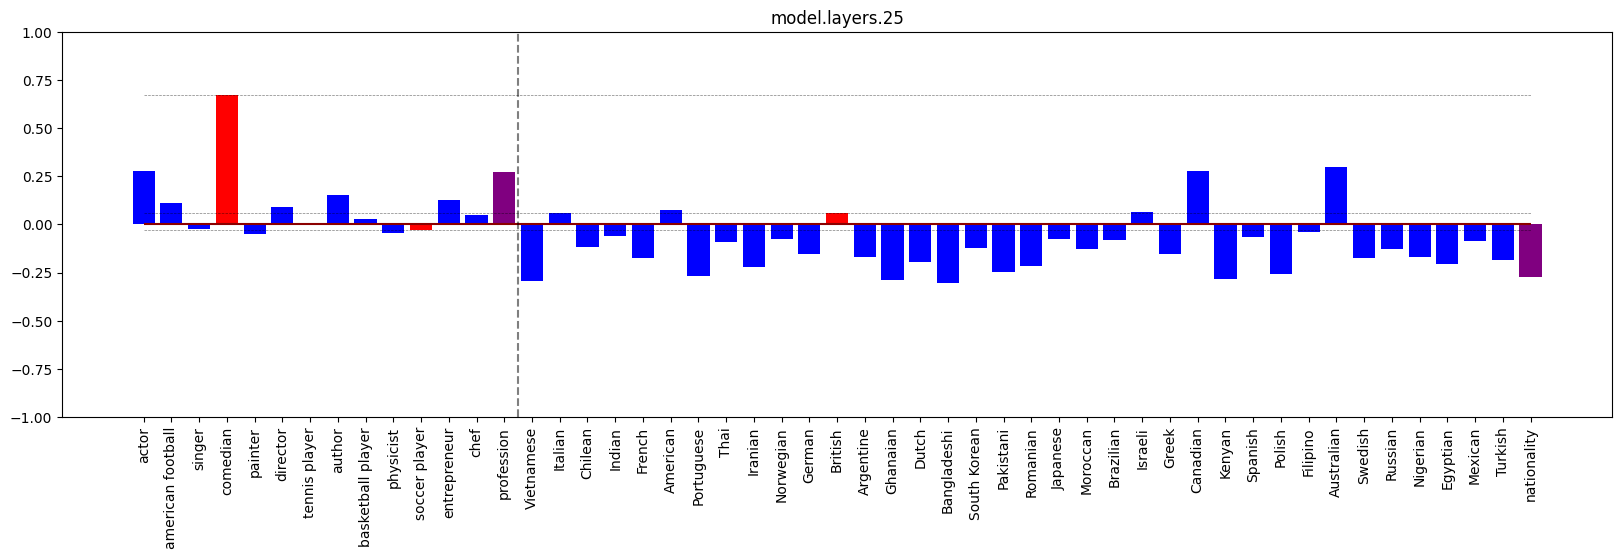

model.layers.25 => [('comedian', 0.671875), ('Australian', 0.298828125), ('actor', 0.279296875), ('Canadian', 0.27734375), ('profession', 0.2734375), ('author', 0.154296875), ('entrepreneur', 0.1279296875), ('american football', 0.111328125), ('director', 0.08837890625), ('American', 0.07470703125), ('Israeli', 0.06640625), ('Italian', 0.0595703125), ('British', 0.058837890625), ('chef', 0.05078125), ('basketball player', 0.0296630859375), ('tennis player', -0.004730224609375), ('singer', -0.021728515625), ('soccer player', -0.027587890625), ('Filipino', -0.037841796875), ('physicist', -0.042724609375), ('painter', -0.0517578125), ('Indian', -0.060546875), ('Spanish', -0.064453125), ('Japanese', -0.07470703125), ('Norwegian', -0.076171875), ('Brazilian', -0.08251953125), ('Mexican', -0.08740234375), ('Thai', -0.09326171875), ('Chilean', -0.1162109375), ('South Korean', -0.1201171875), ('Moroccan', -0.1259765625), ('Russian', -0.1279296875), ('German', -0.1513671875), ('Greek', -0.15527

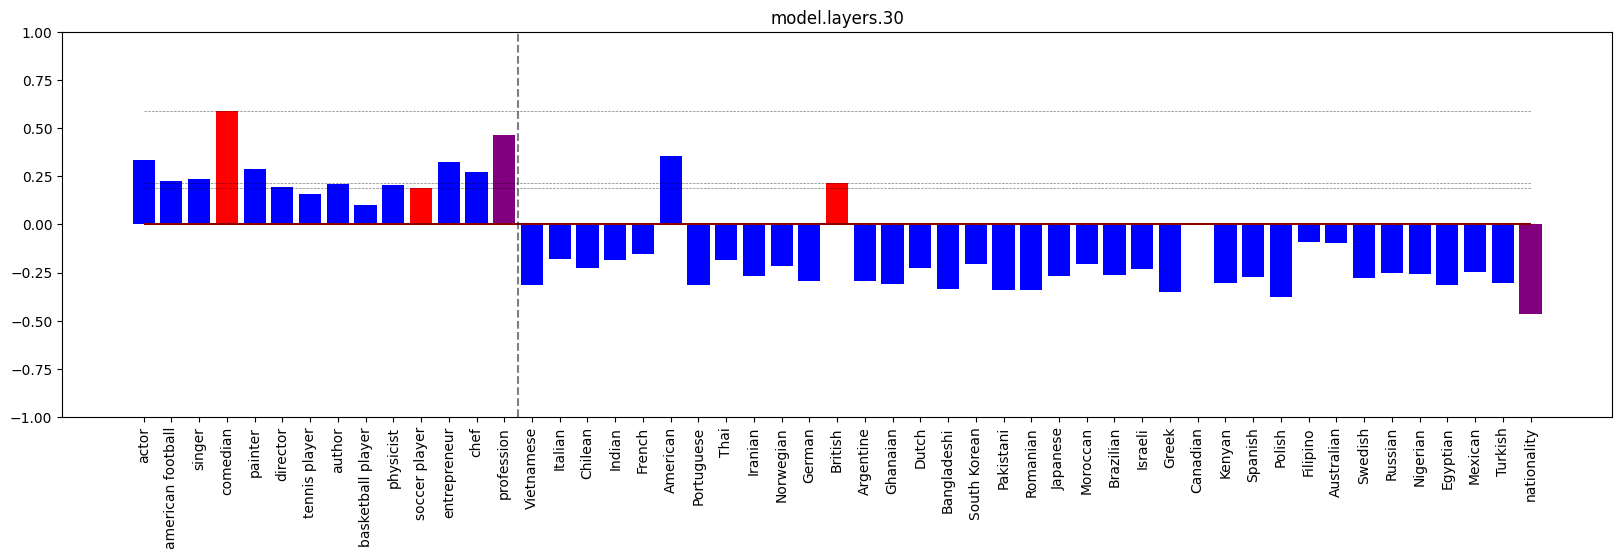

model.layers.30 => [('comedian', 0.58984375), ('profession', 0.46484375), ('American', 0.353515625), ('actor', 0.33203125), ('entrepreneur', 0.32421875), ('painter', 0.2890625), ('chef', 0.271484375), ('singer', 0.2333984375), ('american football', 0.224609375), ('British', 0.21484375), ('author', 0.2109375), ('physicist', 0.203125), ('director', 0.1953125), ('soccer player', 0.1875), ('tennis player', 0.1572265625), ('basketball player', 0.10302734375), ('Canadian', -0.005523681640625), ('Filipino', -0.08935546875), ('Australian', -0.095703125), ('French', -0.1552734375), ('Italian', -0.1796875), ('Indian', -0.1845703125), ('Thai', -0.1875), ('South Korean', -0.20703125), ('Moroccan', -0.2080078125), ('Norwegian', -0.2177734375), ('Chilean', -0.224609375), ('Dutch', -0.2255859375), ('Israeli', -0.2314453125), ('Mexican', -0.24609375), ('Russian', -0.25), ('Nigerian', -0.255859375), ('Brazilian', -0.26171875), ('Japanese', -0.267578125), ('Iranian', -0.26953125), ('Spanish', -0.2753906

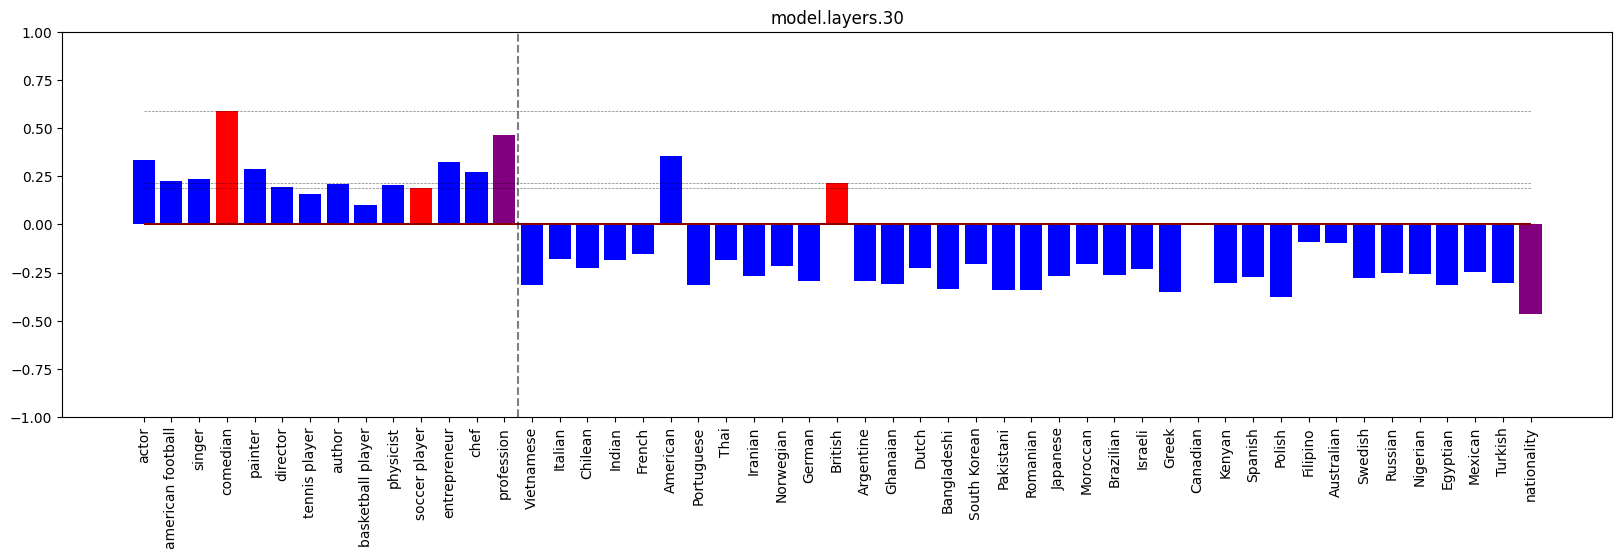

model.layers.30 => [('comedian', 0.58984375), ('profession', 0.46484375), ('American', 0.353515625), ('actor', 0.33203125), ('entrepreneur', 0.32421875), ('painter', 0.2890625), ('chef', 0.271484375), ('singer', 0.2333984375), ('american football', 0.224609375), ('British', 0.21484375), ('author', 0.2109375), ('physicist', 0.203125), ('director', 0.1953125), ('soccer player', 0.1875), ('tennis player', 0.1572265625), ('basketball player', 0.10302734375), ('Canadian', -0.005523681640625), ('Filipino', -0.08935546875), ('Australian', -0.095703125), ('French', -0.1552734375), ('Italian', -0.1796875), ('Indian', -0.1845703125), ('Thai', -0.1875), ('South Korean', -0.20703125), ('Moroccan', -0.2080078125), ('Norwegian', -0.2177734375), ('Chilean', -0.224609375), ('Dutch', -0.2255859375), ('Israeli', -0.2314453125), ('Mexican', -0.24609375), ('Russian', -0.25), ('Nigerian', -0.255859375), ('Brazilian', -0.26171875), ('Japanese', -0.267578125), ('Iranian', -0.26953125), ('Spanish', -0.2753906

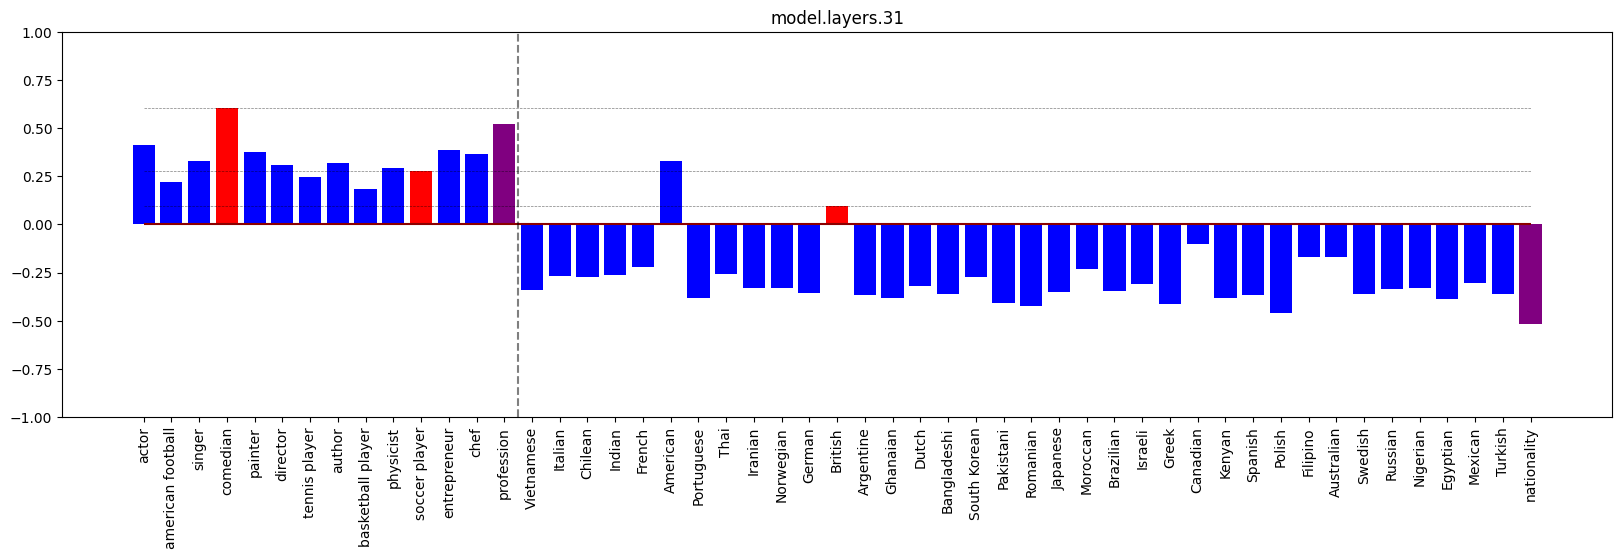

model.layers.31 => [('comedian', 0.60546875), ('profession', 0.51953125), ('actor', 0.4140625), ('entrepreneur', 0.38671875), ('painter', 0.375), ('chef', 0.365234375), ('singer', 0.330078125), ('American', 0.330078125), ('author', 0.318359375), ('director', 0.30859375), ('physicist', 0.29296875), ('soccer player', 0.279296875), ('tennis player', 0.248046875), ('american football', 0.21875), ('basketball player', 0.181640625), ('British', 0.09716796875), ('Canadian', -0.1015625), ('Filipino', -0.1669921875), ('Australian', -0.171875), ('French', -0.220703125), ('Moroccan', -0.2294921875), ('Thai', -0.259765625), ('Indian', -0.26171875), ('Italian', -0.26953125), ('Chilean', -0.275390625), ('South Korean', -0.275390625), ('Mexican', -0.302734375), ('Israeli', -0.310546875), ('Dutch', -0.3203125), ('Iranian', -0.328125), ('Norwegian', -0.328125), ('Nigerian', -0.33203125), ('Russian', -0.337890625), ('Vietnamese', -0.341796875), ('Brazilian', -0.34765625), ('Japanese', -0.3515625), ('Ger

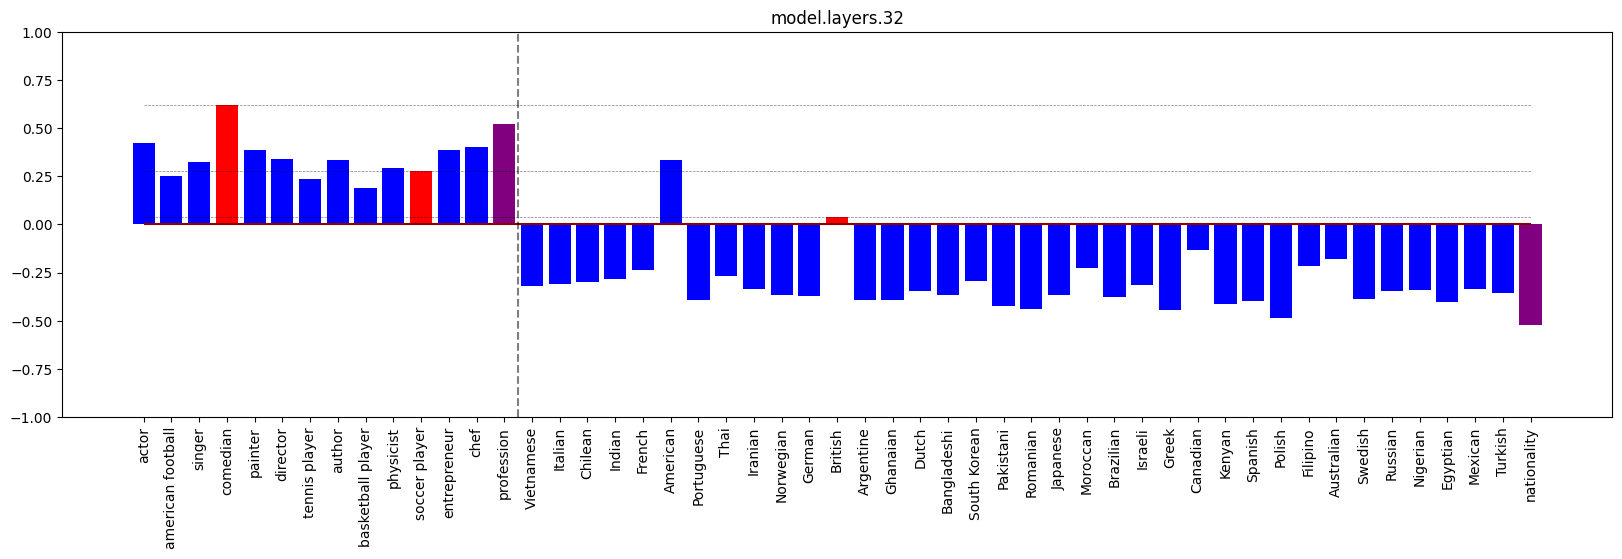

model.layers.32 => [('comedian', 0.62109375), ('profession', 0.5234375), ('actor', 0.421875), ('chef', 0.40234375), ('entrepreneur', 0.38671875), ('painter', 0.384765625), ('director', 0.341796875), ('author', 0.333984375), ('American', 0.33203125), ('singer', 0.32421875), ('physicist', 0.294921875), ('soccer player', 0.27734375), ('american football', 0.251953125), ('tennis player', 0.23828125), ('basketball player', 0.1904296875), ('British', 0.039794921875), ('Canadian', -0.1318359375), ('Australian', -0.181640625), ('Filipino', -0.216796875), ('Moroccan', -0.224609375), ('French', -0.23828125), ('Thai', -0.26953125), ('Indian', -0.283203125), ('South Korean', -0.294921875), ('Chilean', -0.30078125), ('Italian', -0.30859375), ('Israeli', -0.3125), ('Vietnamese', -0.322265625), ('Iranian', -0.333984375), ('Mexican', -0.3359375), ('Nigerian', -0.33984375), ('Dutch', -0.34765625), ('Russian', -0.34765625), ('Turkish', -0.35546875), ('Bangladeshi', -0.3671875), ('Norwegian', -0.36914062

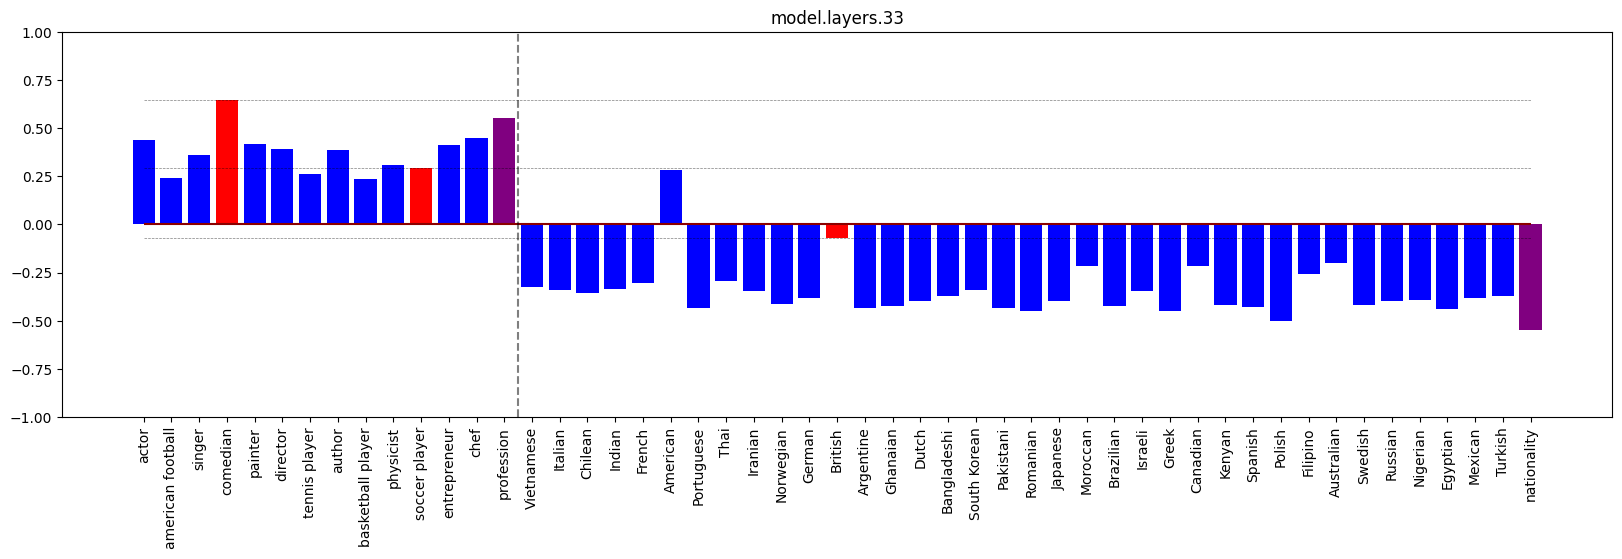

model.layers.33 => [('comedian', 0.6484375), ('profession', 0.55078125), ('chef', 0.447265625), ('actor', 0.439453125), ('painter', 0.419921875), ('entrepreneur', 0.4140625), ('director', 0.390625), ('author', 0.388671875), ('singer', 0.359375), ('physicist', 0.310546875), ('soccer player', 0.291015625), ('American', 0.283203125), ('tennis player', 0.259765625), ('american football', 0.2412109375), ('basketball player', 0.23828125), ('British', -0.07275390625), ('Australian', -0.2001953125), ('Moroccan', -0.2158203125), ('Canadian', -0.216796875), ('Filipino', -0.2578125), ('Thai', -0.294921875), ('French', -0.302734375), ('Vietnamese', -0.326171875), ('Indian', -0.337890625), ('Italian', -0.33984375), ('South Korean', -0.341796875), ('Israeli', -0.34375), ('Iranian', -0.34765625), ('Chilean', -0.35546875), ('Bangladeshi', -0.37109375), ('Turkish', -0.37109375), ('Mexican', -0.3828125), ('German', -0.384765625), ('Nigerian', -0.392578125), ('Dutch', -0.3984375), ('Russian', -0.3984375)

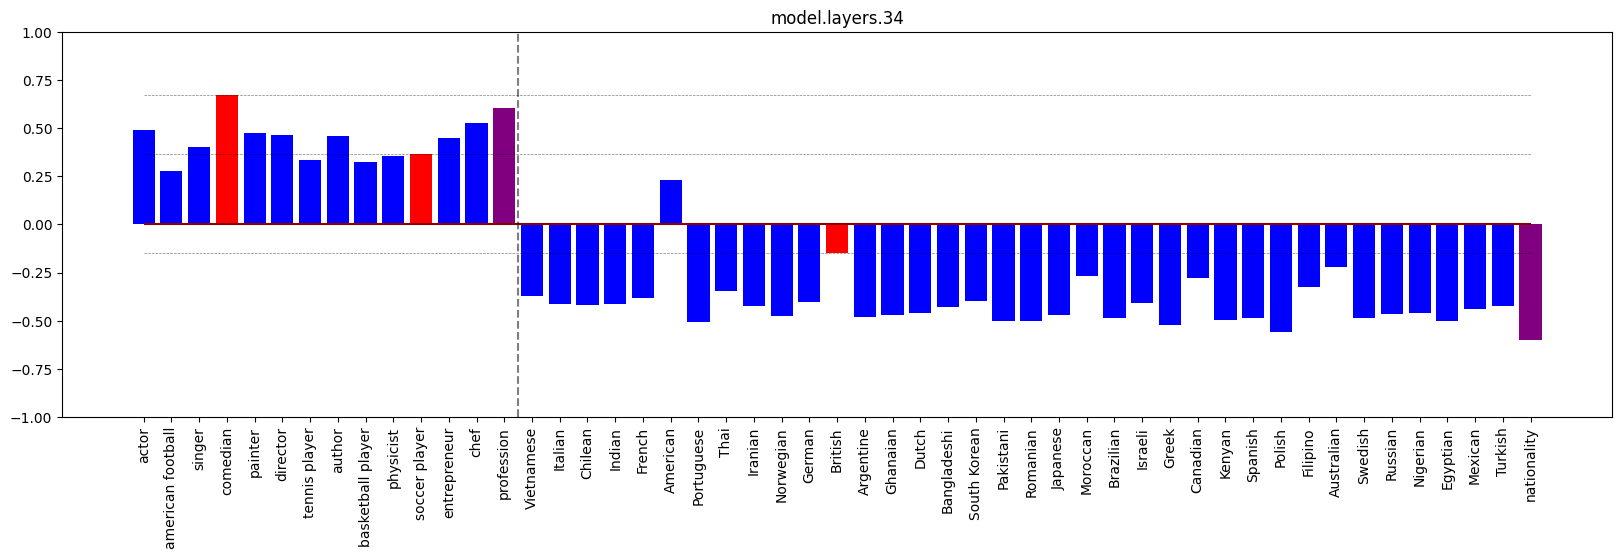

model.layers.34 => [('comedian', 0.671875), ('profession', 0.60546875), ('chef', 0.52734375), ('actor', 0.4921875), ('painter', 0.47265625), ('director', 0.466796875), ('author', 0.458984375), ('entrepreneur', 0.44921875), ('singer', 0.40234375), ('soccer player', 0.365234375), ('physicist', 0.35546875), ('tennis player', 0.3359375), ('basketball player', 0.32421875), ('american football', 0.27734375), ('American', 0.228515625), ('British', -0.150390625), ('Australian', -0.2216796875), ('Moroccan', -0.265625), ('Canadian', -0.27734375), ('Filipino', -0.326171875), ('Thai', -0.345703125), ('Vietnamese', -0.37109375), ('French', -0.380859375), ('South Korean', -0.400390625), ('German', -0.40234375), ('Israeli', -0.408203125), ('Italian', -0.412109375), ('Indian', -0.4140625), ('Chilean', -0.419921875), ('Turkish', -0.421875), ('Iranian', -0.42578125), ('Bangladeshi', -0.431640625), ('Mexican', -0.44140625), ('Dutch', -0.458984375), ('Nigerian', -0.458984375), ('Russian', -0.466796875), (

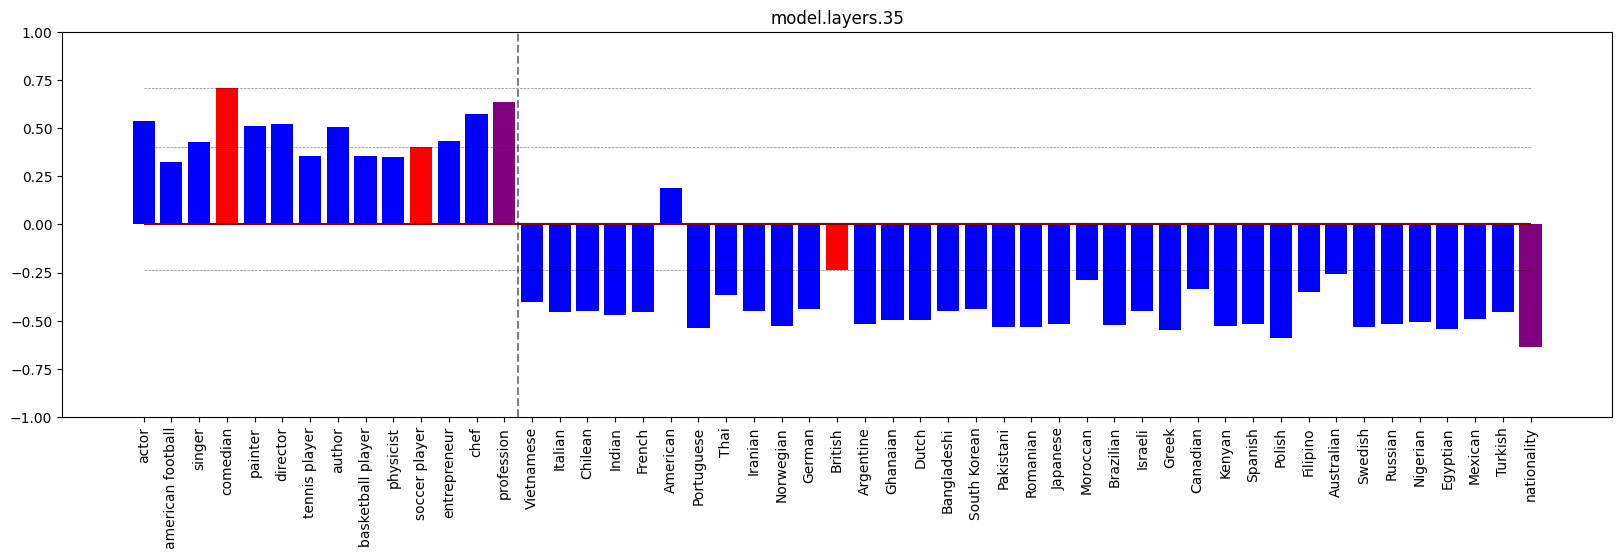

model.layers.35 => [('comedian', 0.7109375), ('profession', 0.63671875), ('chef', 0.57421875), ('actor', 0.53515625), ('director', 0.5234375), ('painter', 0.51171875), ('author', 0.5078125), ('entrepreneur', 0.435546875), ('singer', 0.4296875), ('soccer player', 0.404296875), ('basketball player', 0.357421875), ('tennis player', 0.35546875), ('physicist', 0.3515625), ('american football', 0.326171875), ('American', 0.189453125), ('British', -0.236328125), ('Australian', -0.255859375), ('Moroccan', -0.2890625), ('Canadian', -0.333984375), ('Filipino', -0.349609375), ('Thai', -0.365234375), ('Vietnamese', -0.404296875), ('German', -0.4375), ('South Korean', -0.439453125), ('Chilean', -0.447265625), ('Bangladeshi', -0.447265625), ('Iranian', -0.451171875), ('Israeli', -0.451171875), ('Italian', -0.45703125), ('French', -0.45703125), ('Turkish', -0.45703125), ('Indian', -0.470703125), ('Mexican', -0.4921875), ('Ghanaian', -0.494140625), ('Dutch', -0.498046875), ('Nigerian', -0.5078125), ('

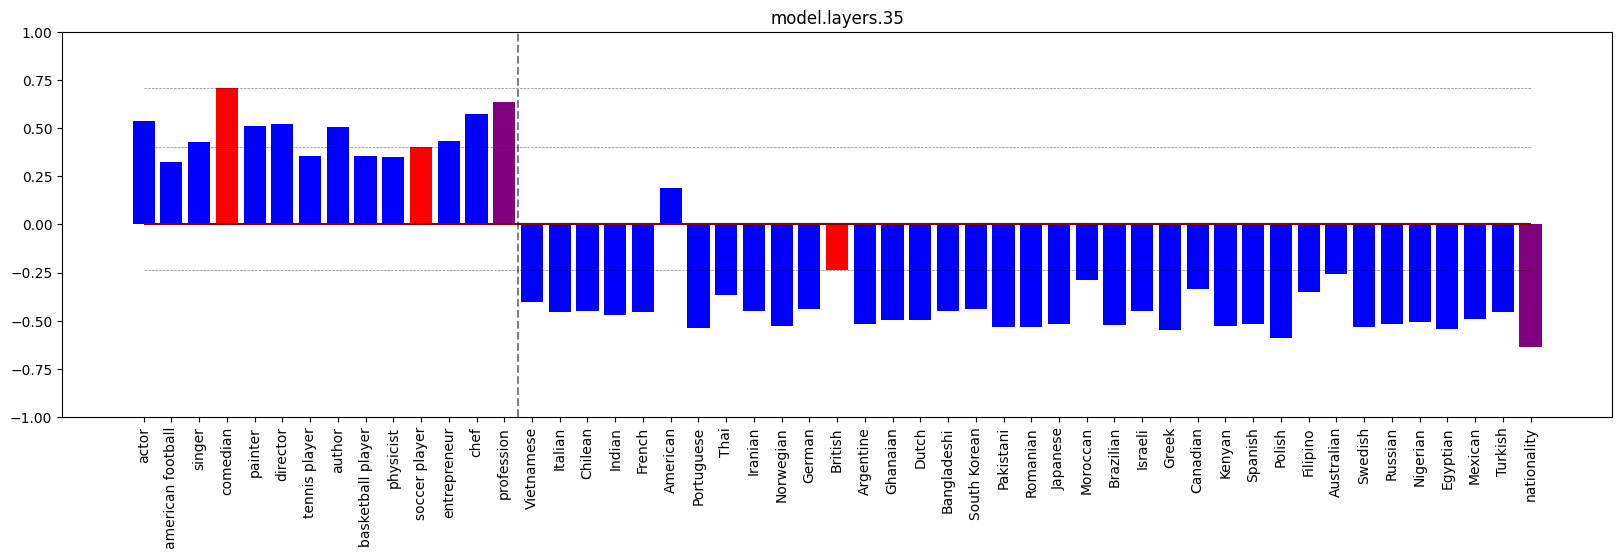

model.layers.35 => [('comedian', 0.7109375), ('profession', 0.63671875), ('chef', 0.57421875), ('actor', 0.53515625), ('director', 0.5234375), ('painter', 0.51171875), ('author', 0.5078125), ('entrepreneur', 0.435546875), ('singer', 0.4296875), ('soccer player', 0.404296875), ('basketball player', 0.357421875), ('tennis player', 0.35546875), ('physicist', 0.3515625), ('american football', 0.326171875), ('American', 0.189453125), ('British', -0.236328125), ('Australian', -0.255859375), ('Moroccan', -0.2890625), ('Canadian', -0.333984375), ('Filipino', -0.349609375), ('Thai', -0.365234375), ('Vietnamese', -0.404296875), ('German', -0.4375), ('South Korean', -0.439453125), ('Chilean', -0.447265625), ('Bangladeshi', -0.447265625), ('Iranian', -0.451171875), ('Israeli', -0.451171875), ('Italian', -0.45703125), ('French', -0.45703125), ('Turkish', -0.45703125), ('Indian', -0.470703125), ('Mexican', -0.4921875), ('Ghanaian', -0.494140625), ('Dutch', -0.498046875), ('Nigerian', -0.5078125), ('

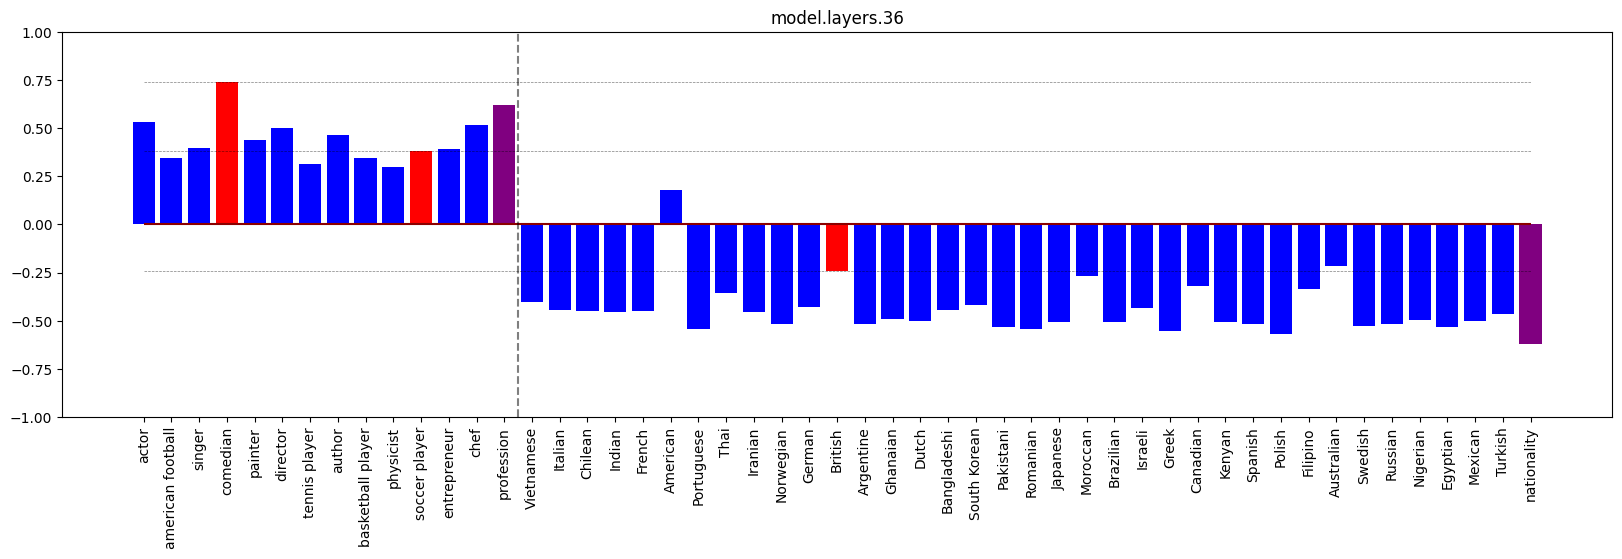

model.layers.36 => [('comedian', 0.7421875), ('profession', 0.62109375), ('actor', 0.53125), ('chef', 0.515625), ('director', 0.5), ('author', 0.462890625), ('painter', 0.4375), ('singer', 0.396484375), ('entrepreneur', 0.390625), ('soccer player', 0.380859375), ('basketball player', 0.345703125), ('american football', 0.34375), ('tennis player', 0.3125), ('physicist', 0.296875), ('American', 0.1806640625), ('Australian', -0.216796875), ('British', -0.2412109375), ('Moroccan', -0.267578125), ('Canadian', -0.322265625), ('Filipino', -0.337890625), ('Thai', -0.357421875), ('Vietnamese', -0.40234375), ('South Korean', -0.41796875), ('German', -0.427734375), ('Israeli', -0.435546875), ('Italian', -0.443359375), ('Bangladeshi', -0.4453125), ('Chilean', -0.447265625), ('French', -0.451171875), ('Indian', -0.455078125), ('Iranian', -0.45703125), ('Turkish', -0.466796875), ('Ghanaian', -0.490234375), ('Nigerian', -0.498046875), ('Dutch', -0.50390625), ('Mexican', -0.50390625), ('Japanese', -0.

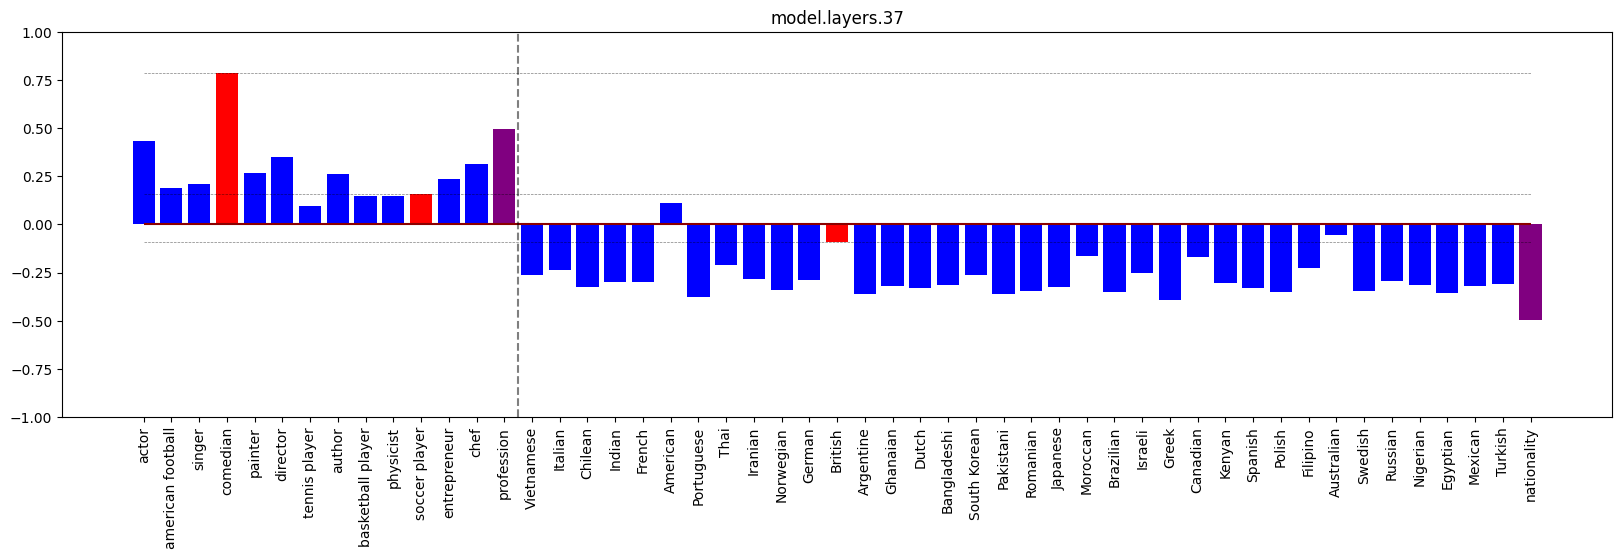

model.layers.37 => [('comedian', 0.7890625), ('profession', 0.49609375), ('actor', 0.43359375), ('director', 0.349609375), ('chef', 0.314453125), ('painter', 0.265625), ('author', 0.26171875), ('entrepreneur', 0.236328125), ('singer', 0.208984375), ('american football', 0.1865234375), ('soccer player', 0.16015625), ('physicist', 0.1494140625), ('basketball player', 0.146484375), ('American', 0.11328125), ('tennis player', 0.0947265625), ('Australian', -0.05712890625), ('British', -0.09228515625), ('Moroccan', -0.1640625), ('Canadian', -0.1669921875), ('Thai', -0.212890625), ('Filipino', -0.224609375), ('Italian', -0.2373046875), ('Israeli', -0.25), ('Vietnamese', -0.263671875), ('South Korean', -0.263671875), ('Iranian', -0.283203125), ('German', -0.2890625), ('Russian', -0.294921875), ('Indian', -0.298828125), ('French', -0.30078125), ('Kenyan', -0.302734375), ('Turkish', -0.310546875), ('Nigerian', -0.314453125), ('Bangladeshi', -0.31640625), ('Mexican', -0.3203125), ('Ghanaian', -0.

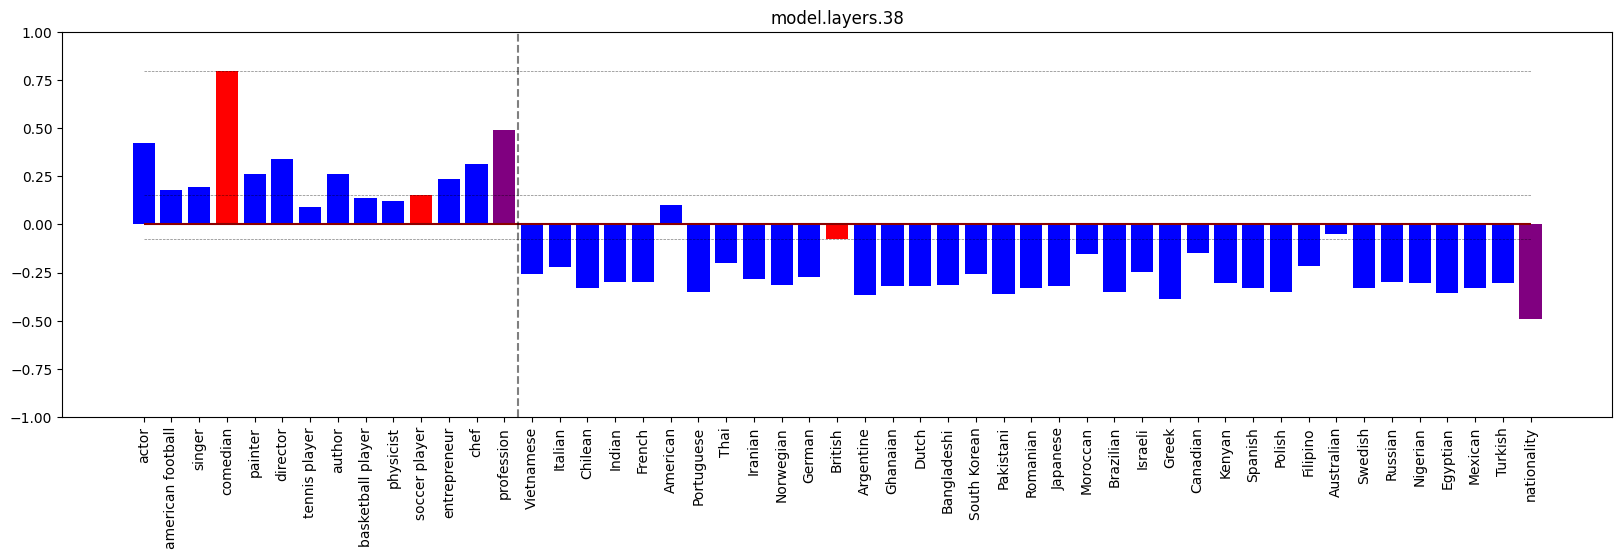

model.layers.38 => [('comedian', 0.796875), ('profession', 0.490234375), ('actor', 0.423828125), ('director', 0.341796875), ('chef', 0.314453125), ('author', 0.26171875), ('painter', 0.259765625), ('entrepreneur', 0.2353515625), ('singer', 0.1953125), ('american football', 0.1767578125), ('soccer player', 0.150390625), ('basketball player', 0.134765625), ('physicist', 0.12158203125), ('American', 0.10009765625), ('tennis player', 0.08837890625), ('Australian', -0.048828125), ('British', -0.07763671875), ('Canadian', -0.1484375), ('Moroccan', -0.1533203125), ('Thai', -0.2001953125), ('Filipino', -0.2158203125), ('Italian', -0.2216796875), ('Israeli', -0.24609375), ('Vietnamese', -0.255859375), ('South Korean', -0.2578125), ('German', -0.2734375), ('Iranian', -0.283203125), ('Russian', -0.298828125), ('Indian', -0.30078125), ('French', -0.30078125), ('Kenyan', -0.302734375), ('Nigerian', -0.302734375), ('Turkish', -0.3046875), ('Bangladeshi', -0.3125), ('Norwegian', -0.31640625), ('Ghana

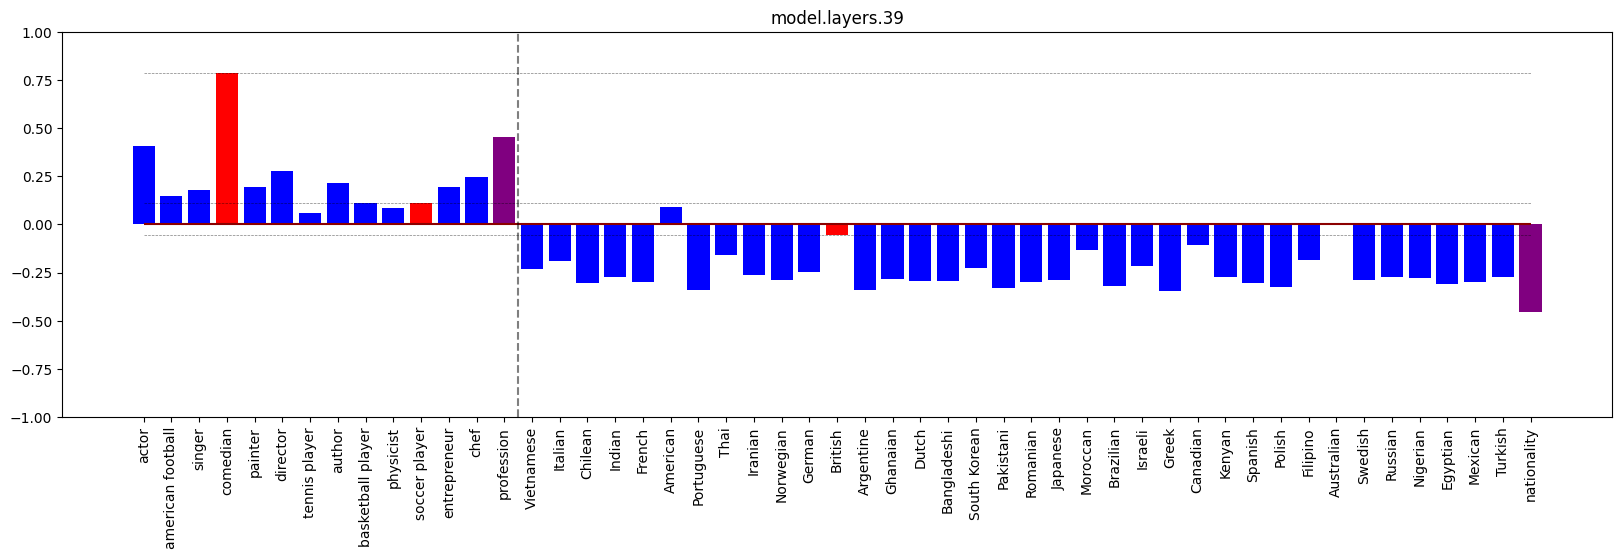

model.layers.39 => [('comedian', 0.78515625), ('profession', 0.453125), ('actor', 0.40625), ('director', 0.275390625), ('chef', 0.24609375), ('author', 0.212890625), ('painter', 0.193359375), ('entrepreneur', 0.193359375), ('singer', 0.1796875), ('american football', 0.146484375), ('soccer player', 0.11328125), ('basketball player', 0.11181640625), ('American', 0.0927734375), ('physicist', 0.08544921875), ('tennis player', 0.060302734375), ('Australian', -0.002899169921875), ('British', -0.055908203125), ('Canadian', -0.1064453125), ('Moroccan', -0.130859375), ('Thai', -0.1591796875), ('Filipino', -0.1875), ('Italian', -0.1884765625), ('Israeli', -0.2138671875), ('South Korean', -0.228515625), ('Vietnamese', -0.2333984375), ('German', -0.2451171875), ('Iranian', -0.26171875), ('Indian', -0.271484375), ('Russian', -0.2734375), ('Turkish', -0.2734375), ('Kenyan', -0.275390625), ('Nigerian', -0.279296875), ('Ghanaian', -0.28125), ('Japanese', -0.287109375), ('Norwegian', -0.291015625), ('

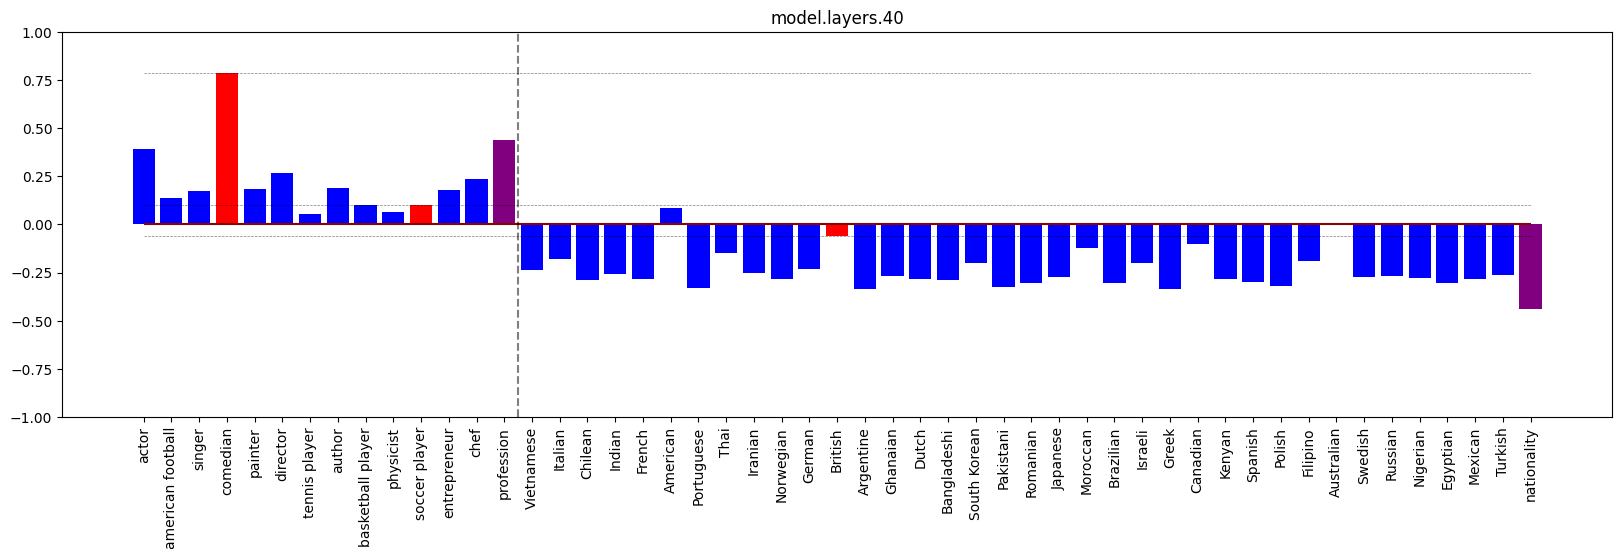

model.layers.40 => [('comedian', 0.78515625), ('profession', 0.439453125), ('actor', 0.392578125), ('director', 0.26953125), ('chef', 0.23828125), ('author', 0.189453125), ('painter', 0.185546875), ('entrepreneur', 0.177734375), ('singer', 0.171875), ('american football', 0.134765625), ('soccer player', 0.1025390625), ('basketball player', 0.09912109375), ('American', 0.0869140625), ('physicist', 0.06201171875), ('tennis player', 0.052490234375), ('Australian', -0.0003261566162109375), ('British', -0.058837890625), ('Canadian', -0.099609375), ('Moroccan', -0.12451171875), ('Thai', -0.1494140625), ('Italian', -0.1787109375), ('Filipino', -0.189453125), ('South Korean', -0.19921875), ('Israeli', -0.2021484375), ('German', -0.23046875), ('Vietnamese', -0.236328125), ('Iranian', -0.251953125), ('Indian', -0.2578125), ('Turkish', -0.26171875), ('Ghanaian', -0.267578125), ('Russian', -0.267578125), ('Japanese', -0.271484375), ('Swedish', -0.275390625), ('Nigerian', -0.279296875), ('French', 

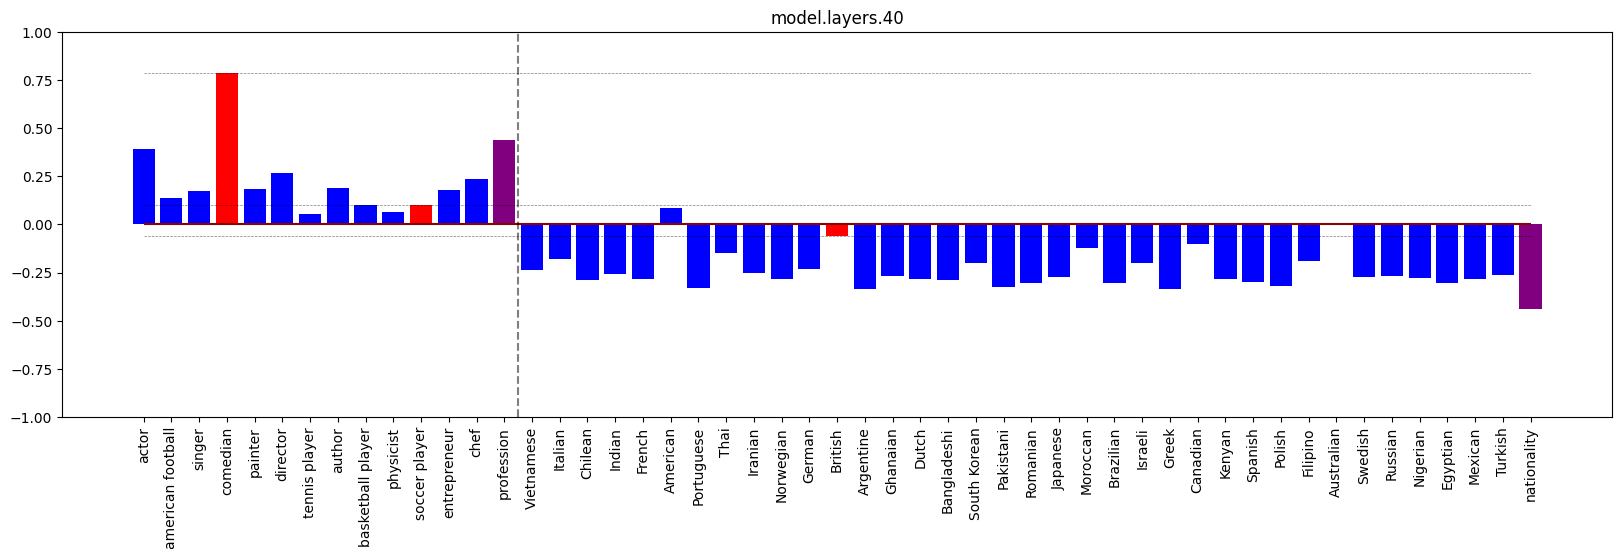

model.layers.40 => [('comedian', 0.78515625), ('profession', 0.439453125), ('actor', 0.392578125), ('director', 0.26953125), ('chef', 0.23828125), ('author', 0.189453125), ('painter', 0.185546875), ('entrepreneur', 0.177734375), ('singer', 0.171875), ('american football', 0.134765625), ('soccer player', 0.1025390625), ('basketball player', 0.09912109375), ('American', 0.0869140625), ('physicist', 0.06201171875), ('tennis player', 0.052490234375), ('Australian', -0.0003261566162109375), ('British', -0.058837890625), ('Canadian', -0.099609375), ('Moroccan', -0.12451171875), ('Thai', -0.1494140625), ('Italian', -0.1787109375), ('Filipino', -0.189453125), ('South Korean', -0.19921875), ('Israeli', -0.2021484375), ('German', -0.23046875), ('Vietnamese', -0.236328125), ('Iranian', -0.251953125), ('Indian', -0.2578125), ('Turkish', -0.26171875), ('Ghanaian', -0.267578125), ('Russian', -0.267578125), ('Japanese', -0.271484375), ('Swedish', -0.275390625), ('Nigerian', -0.279296875), ('French', 

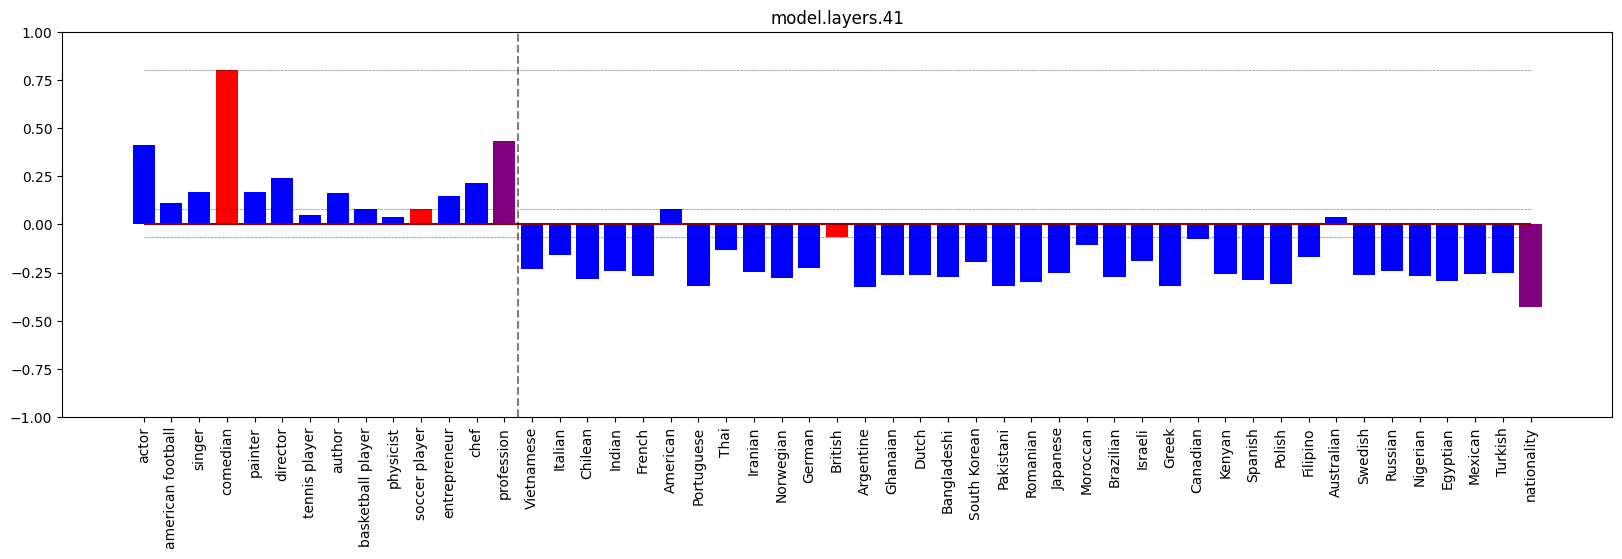

model.layers.41 => [('comedian', 0.80078125), ('profession', 0.431640625), ('actor', 0.41015625), ('director', 0.2421875), ('chef', 0.212890625), ('painter', 0.1689453125), ('singer', 0.16796875), ('author', 0.162109375), ('entrepreneur', 0.1484375), ('american football', 0.1123046875), ('soccer player', 0.08203125), ('basketball player', 0.08154296875), ('American', 0.07958984375), ('tennis player', 0.050537109375), ('physicist', 0.03955078125), ('Australian', 0.038330078125), ('British', -0.06298828125), ('Canadian', -0.07470703125), ('Moroccan', -0.10888671875), ('Thai', -0.1337890625), ('Italian', -0.1572265625), ('Filipino', -0.16796875), ('Israeli', -0.189453125), ('South Korean', -0.1953125), ('German', -0.2275390625), ('Vietnamese', -0.2294921875), ('Indian', -0.240234375), ('Russian', -0.2431640625), ('Iranian', -0.2490234375), ('Japanese', -0.251953125), ('Turkish', -0.251953125), ('Mexican', -0.255859375), ('Kenyan', -0.2578125), ('Ghanaian', -0.26171875), ('Dutch', -0.26367

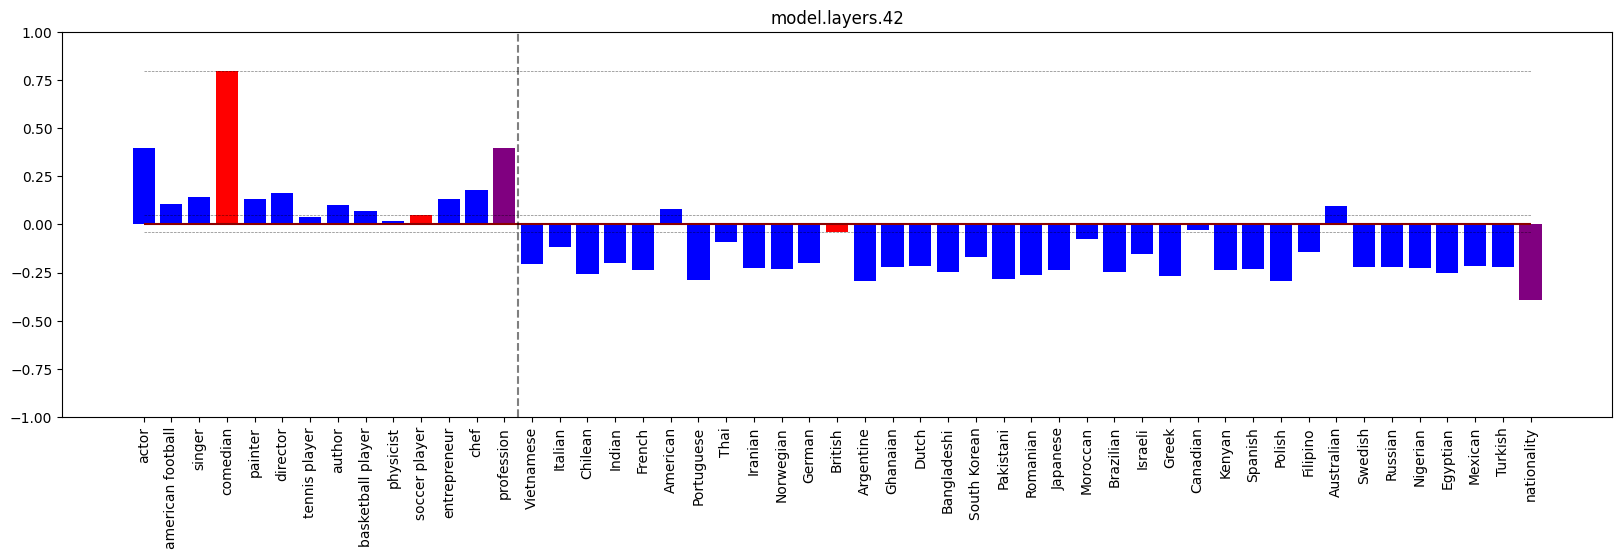

model.layers.42 => [('comedian', 0.796875), ('actor', 0.396484375), ('profession', 0.39453125), ('chef', 0.1787109375), ('director', 0.1630859375), ('singer', 0.1416015625), ('entrepreneur', 0.1318359375), ('painter', 0.1298828125), ('american football', 0.1064453125), ('author', 0.10107421875), ('Australian', 0.09423828125), ('American', 0.08056640625), ('basketball player', 0.0693359375), ('soccer player', 0.050048828125), ('tennis player', 0.041015625), ('physicist', 0.0164794921875), ('Canadian', -0.029541015625), ('British', -0.040283203125), ('Moroccan', -0.07470703125), ('Thai', -0.09033203125), ('Italian', -0.11962890625), ('Filipino', -0.1455078125), ('Israeli', -0.1533203125), ('South Korean', -0.1708984375), ('Indian', -0.1982421875), ('German', -0.2021484375), ('Vietnamese', -0.2080078125), ('Mexican', -0.2158203125), ('Dutch', -0.2177734375), ('Swedish', -0.2197265625), ('Russian', -0.2197265625), ('Turkish', -0.2197265625), ('Ghanaian', -0.22265625), ('Nigerian', -0.22558

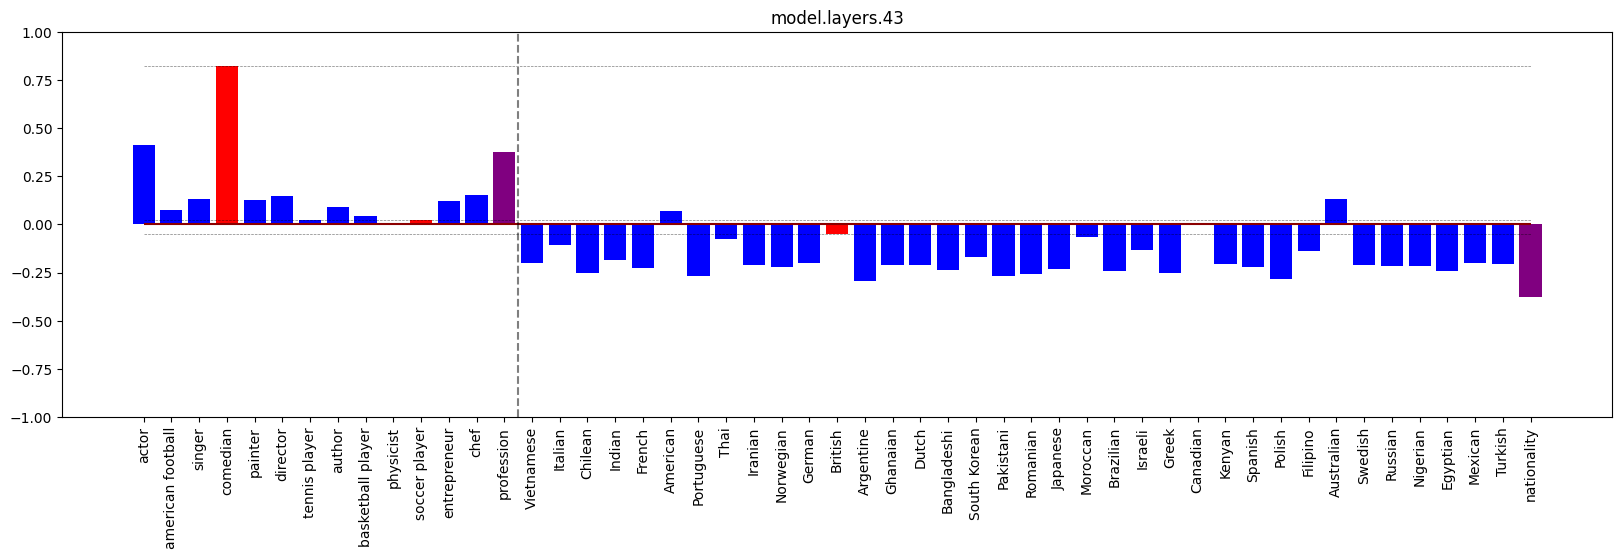

model.layers.43 => [('comedian', 0.8203125), ('actor', 0.41015625), ('profession', 0.376953125), ('chef', 0.150390625), ('director', 0.146484375), ('singer', 0.130859375), ('Australian', 0.1298828125), ('painter', 0.1259765625), ('entrepreneur', 0.12158203125), ('author', 0.0908203125), ('american football', 0.076171875), ('American', 0.068359375), ('basketball player', 0.04248046875), ('tennis player', 0.0238037109375), ('soccer player', 0.02197265625), ('physicist', -0.0023345947265625), ('Canadian', -0.004791259765625), ('British', -0.048583984375), ('Moroccan', -0.06396484375), ('Thai', -0.07421875), ('Italian', -0.107421875), ('Israeli', -0.1318359375), ('Filipino', -0.140625), ('South Korean', -0.16796875), ('Indian', -0.18359375), ('Vietnamese', -0.19921875), ('German', -0.2001953125), ('Mexican', -0.2001953125), ('Kenyan', -0.2080078125), ('Turkish', -0.2080078125), ('Ghanaian', -0.2119140625), ('Swedish', -0.2119140625), ('Iranian', -0.212890625), ('Dutch', -0.212890625), ('Ru

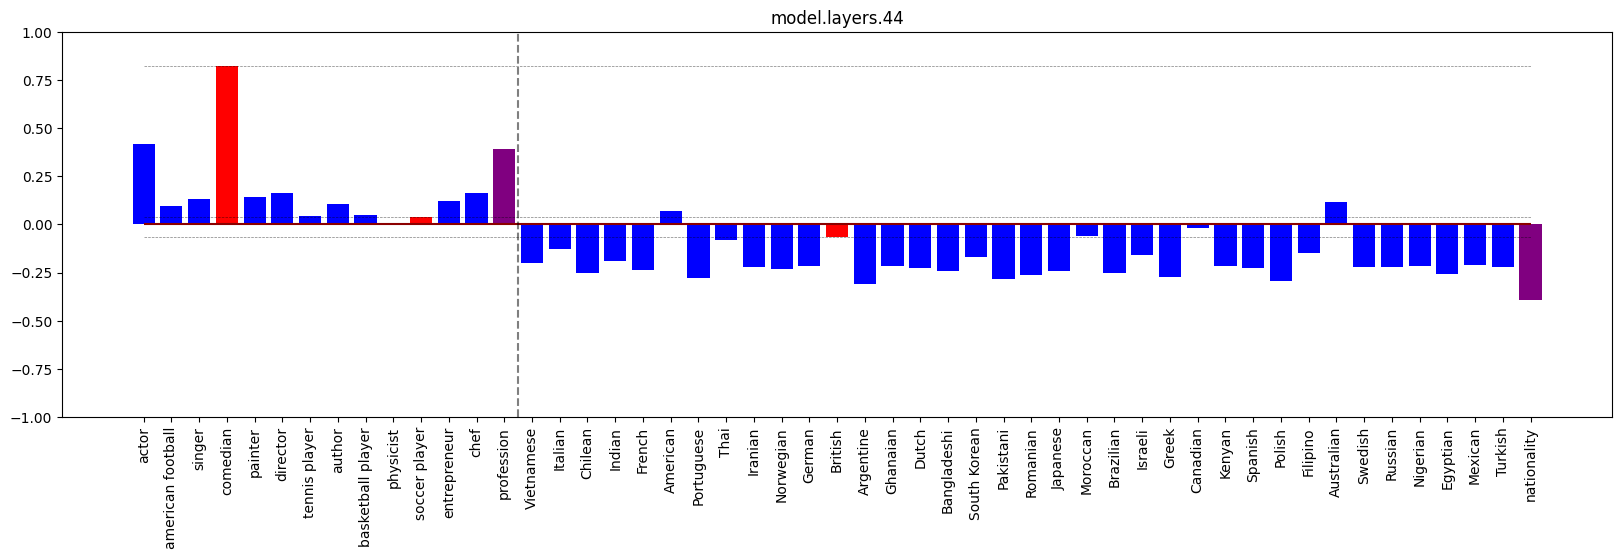

model.layers.44 => [('comedian', 0.8203125), ('actor', 0.41796875), ('profession', 0.390625), ('director', 0.1640625), ('chef', 0.1630859375), ('painter', 0.140625), ('singer', 0.1337890625), ('entrepreneur', 0.123046875), ('Australian', 0.11865234375), ('author', 0.10693359375), ('american football', 0.09765625), ('American', 0.0703125), ('basketball player', 0.047119140625), ('tennis player', 0.04296875), ('soccer player', 0.038330078125), ('physicist', -2.7418136596679688e-05), ('Canadian', -0.0211181640625), ('Moroccan', -0.059814453125), ('British', -0.06640625), ('Thai', -0.08154296875), ('Italian', -0.1279296875), ('Filipino', -0.1474609375), ('Israeli', -0.158203125), ('South Korean', -0.171875), ('Indian', -0.1904296875), ('Vietnamese', -0.19921875), ('Mexican', -0.212890625), ('Kenyan', -0.21484375), ('German', -0.2158203125), ('Nigerian', -0.2158203125), ('Ghanaian', -0.2177734375), ('Iranian', -0.21875), ('Swedish', -0.2197265625), ('Turkish', -0.2197265625), ('Russian', -0

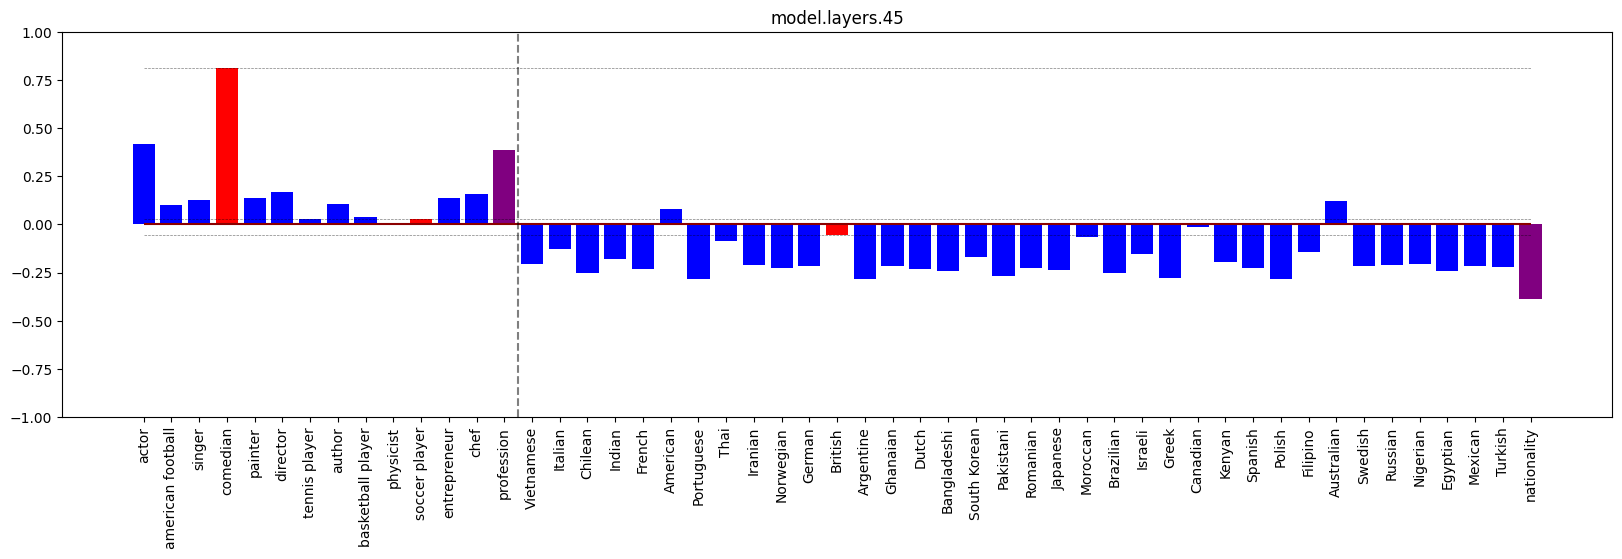

model.layers.45 => [('comedian', 0.8125), ('actor', 0.416015625), ('profession', 0.388671875), ('director', 0.166015625), ('chef', 0.158203125), ('painter', 0.13671875), ('entrepreneur', 0.134765625), ('singer', 0.125), ('Australian', 0.123046875), ('author', 0.10693359375), ('american football', 0.099609375), ('American', 0.08056640625), ('basketball player', 0.038818359375), ('tennis player', 0.0286865234375), ('soccer player', 0.0263671875), ('physicist', 0.00933837890625), ('Canadian', -0.0113525390625), ('British', -0.053466796875), ('Moroccan', -0.064453125), ('Thai', -0.08544921875), ('Italian', -0.1279296875), ('Filipino', -0.142578125), ('Israeli', -0.15625), ('South Korean', -0.1689453125), ('Indian', -0.1796875), ('Kenyan', -0.1953125), ('Nigerian', -0.2041015625), ('Vietnamese', -0.20703125), ('Iranian', -0.2109375), ('Russian', -0.2119140625), ('Ghanaian', -0.2138671875), ('Mexican', -0.21484375), ('German', -0.216796875), ('Swedish', -0.216796875), ('Turkish', -0.22070312

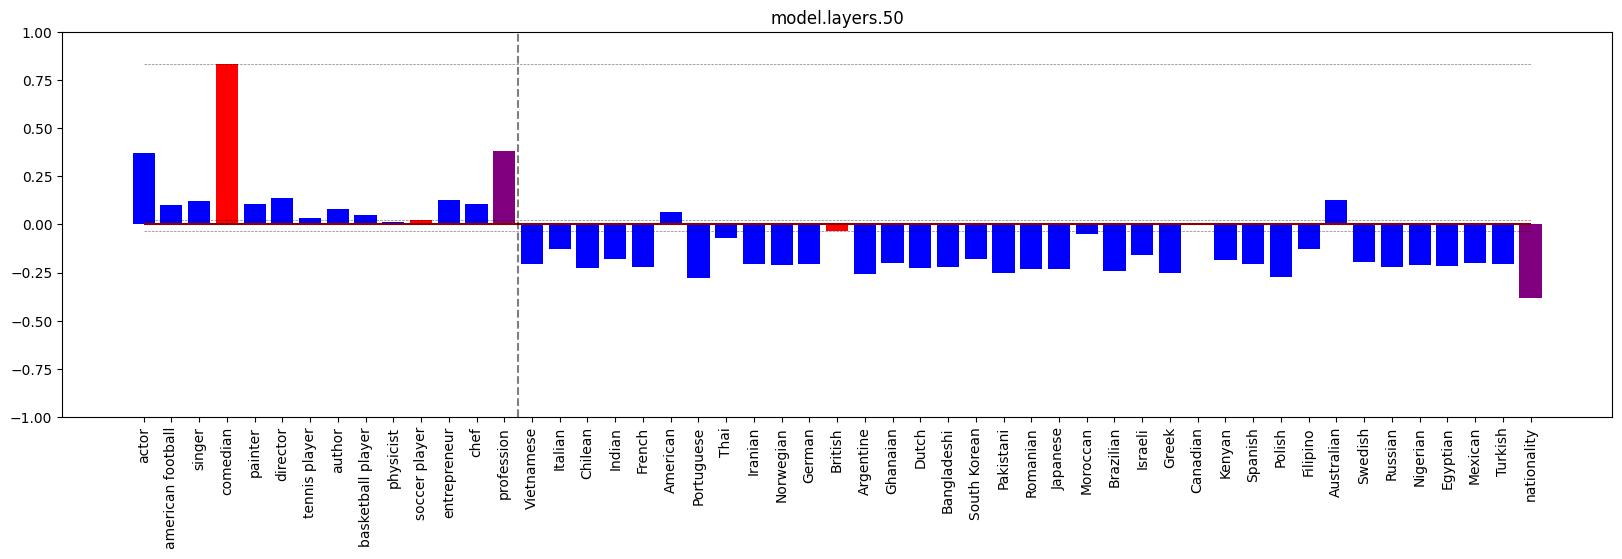

model.layers.50 => [('comedian', 0.83203125), ('profession', 0.3828125), ('actor', 0.373046875), ('director', 0.1396484375), ('entrepreneur', 0.1259765625), ('Australian', 0.12451171875), ('singer', 0.12158203125), ('painter', 0.1083984375), ('chef', 0.103515625), ('american football', 0.0986328125), ('author', 0.08203125), ('American', 0.06494140625), ('basketball player', 0.0478515625), ('tennis player', 0.032470703125), ('soccer player', 0.0220947265625), ('physicist', 0.010498046875), ('Canadian', -0.0024566650390625), ('British', -0.033203125), ('Moroccan', -0.04833984375), ('Thai', -0.068359375), ('Italian', -0.1298828125), ('Filipino', -0.1298828125), ('Israeli', -0.1591796875), ('South Korean', -0.1787109375), ('Indian', -0.181640625), ('Kenyan', -0.18359375), ('Swedish', -0.1962890625), ('Ghanaian', -0.1982421875), ('Mexican', -0.2021484375), ('Spanish', -0.2041015625), ('Turkish', -0.2041015625), ('Iranian', -0.205078125), ('Vietnamese', -0.2080078125), ('German', -0.20800781

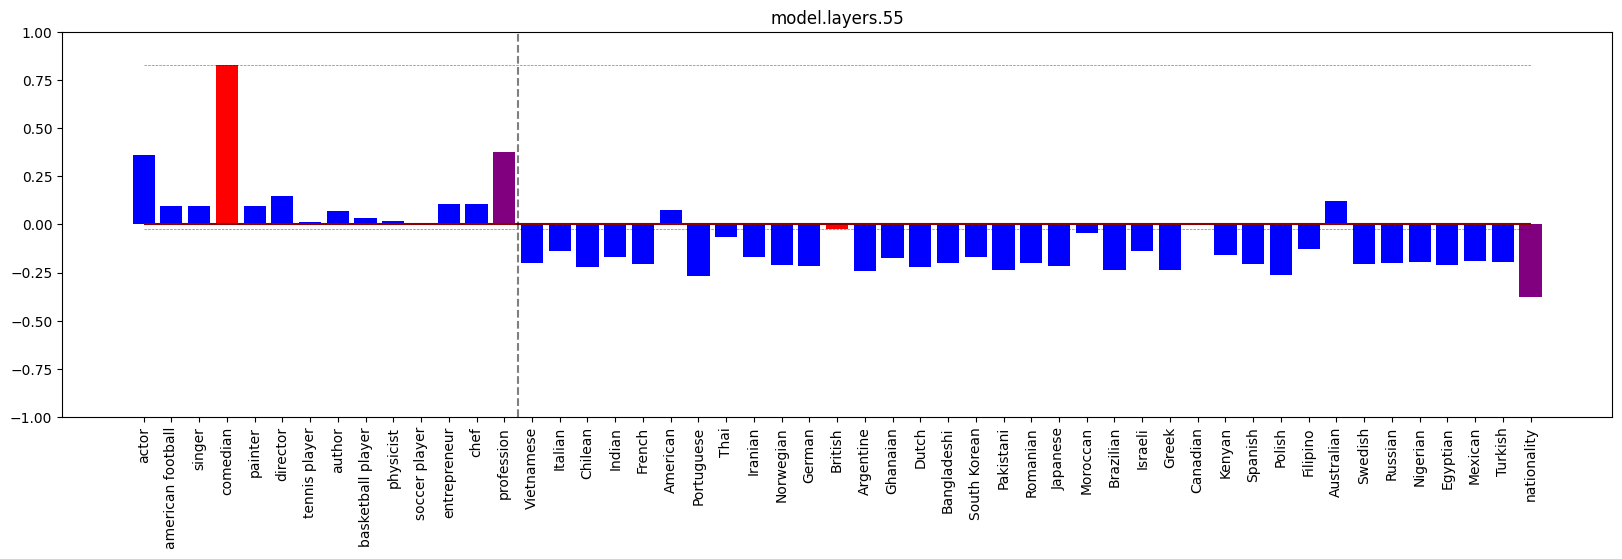

model.layers.55 => [('comedian', 0.828125), ('profession', 0.376953125), ('actor', 0.361328125), ('director', 0.1484375), ('Australian', 0.1220703125), ('chef', 0.1083984375), ('entrepreneur', 0.10400390625), ('singer', 0.09716796875), ('painter', 0.0966796875), ('american football', 0.09521484375), ('American', 0.07568359375), ('author', 0.0712890625), ('basketball player', 0.03564453125), ('physicist', 0.0167236328125), ('tennis player', 0.01422119140625), ('soccer player', 0.0034332275390625), ('Canadian', 0.00323486328125), ('British', -0.0225830078125), ('Moroccan', -0.043212890625), ('Thai', -0.06640625), ('Filipino', -0.1279296875), ('Italian', -0.13671875), ('Israeli', -0.13671875), ('Kenyan', -0.158203125), ('Indian', -0.1669921875), ('South Korean', -0.16796875), ('Iranian', -0.1689453125), ('Ghanaian', -0.1748046875), ('Mexican', -0.1884765625), ('Turkish', -0.1953125), ('Nigerian', -0.197265625), ('Russian', -0.2001953125), ('Vietnamese', -0.2021484375), ('Bangladeshi', -0.

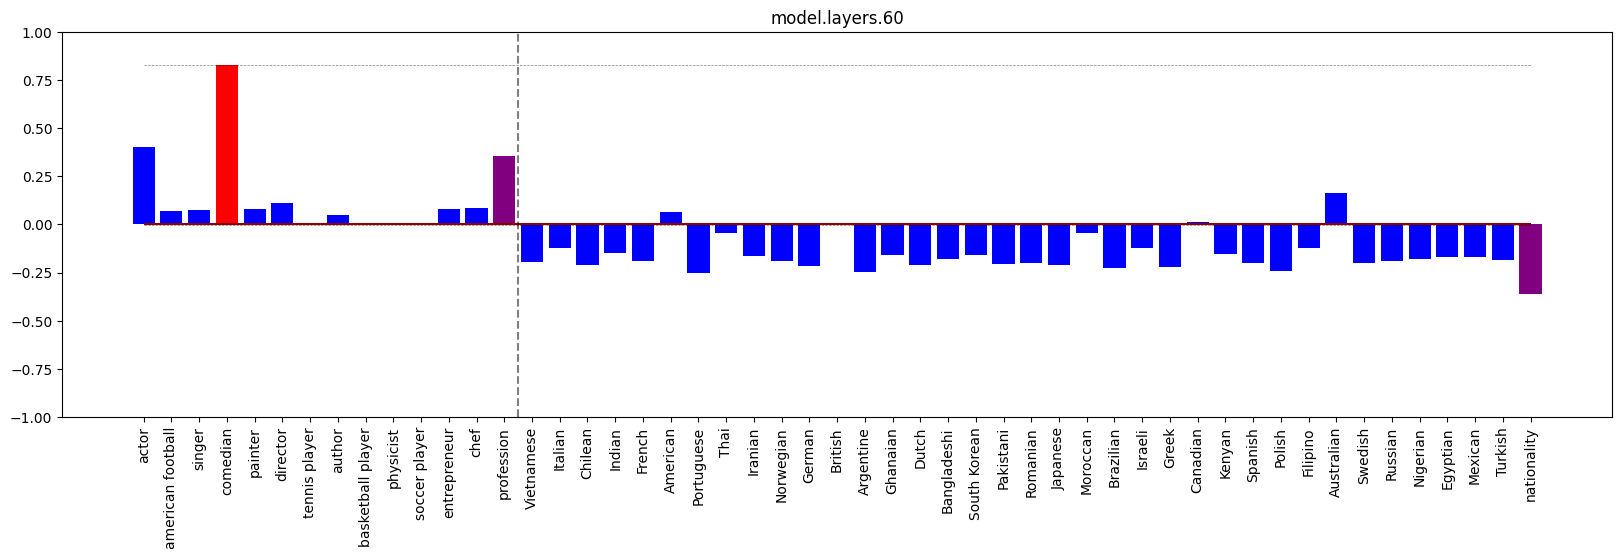

model.layers.60 => [('comedian', 0.828125), ('actor', 0.40234375), ('profession', 0.357421875), ('Australian', 0.1630859375), ('director', 0.10888671875), ('chef', 0.08740234375), ('painter', 0.08056640625), ('entrepreneur', 0.080078125), ('singer', 0.076171875), ('american football', 0.06884765625), ('American', 0.06689453125), ('author', 0.048095703125), ('Canadian', 0.01348876953125), ('basketball player', 0.00848388671875), ('tennis player', 0.00628662109375), ('physicist', 0.00592041015625), ('British', 0.005462646484375), ('soccer player', -0.004791259765625), ('Moroccan', -0.04345703125), ('Thai', -0.0458984375), ('Italian', -0.12060546875), ('Filipino', -0.12060546875), ('Israeli', -0.12255859375), ('Indian', -0.146484375), ('Kenyan', -0.1533203125), ('South Korean', -0.158203125), ('Ghanaian', -0.1611328125), ('Iranian', -0.162109375), ('Mexican', -0.1708984375), ('Egyptian', -0.171875), ('Bangladeshi', -0.1796875), ('Nigerian', -0.1796875), ('Turkish', -0.185546875), ('Norweg

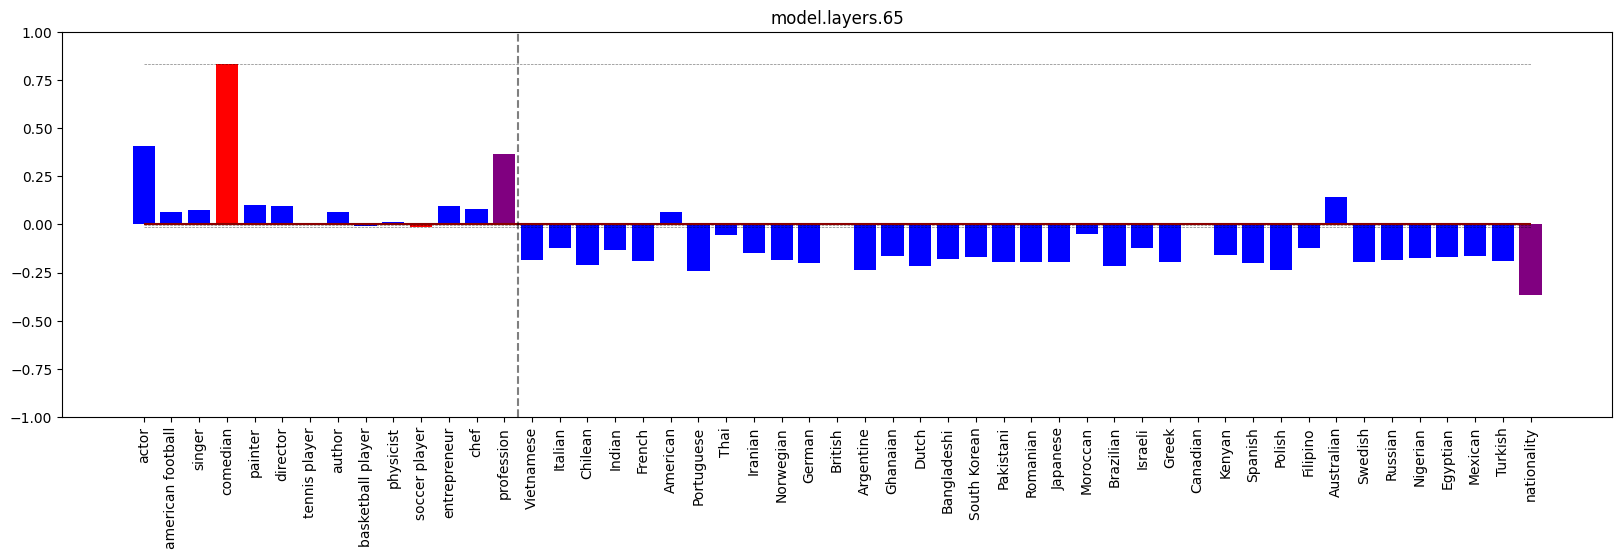

model.layers.65 => [('comedian', 0.83203125), ('actor', 0.408203125), ('profession', 0.365234375), ('Australian', 0.1416015625), ('painter', 0.10009765625), ('entrepreneur', 0.09716796875), ('director', 0.09423828125), ('chef', 0.0791015625), ('singer', 0.07421875), ('author', 0.06689453125), ('american football', 0.06591796875), ('American', 0.0654296875), ('physicist', 0.0150146484375), ('tennis player', 0.00555419921875), ('Canadian', 0.0028076171875), ('British', -0.00110626220703125), ('basketball player', -0.00958251953125), ('soccer player', -0.01422119140625), ('Moroccan', -0.051025390625), ('Thai', -0.052978515625), ('Italian', -0.12060546875), ('Filipino', -0.123046875), ('Israeli', -0.12353515625), ('Indian', -0.130859375), ('Iranian', -0.150390625), ('Kenyan', -0.1611328125), ('Ghanaian', -0.162109375), ('Mexican', -0.1650390625), ('South Korean', -0.1689453125), ('Egyptian', -0.1708984375), ('Nigerian', -0.1748046875), ('Bangladeshi', -0.1806640625), ('Norwegian', -0.18457

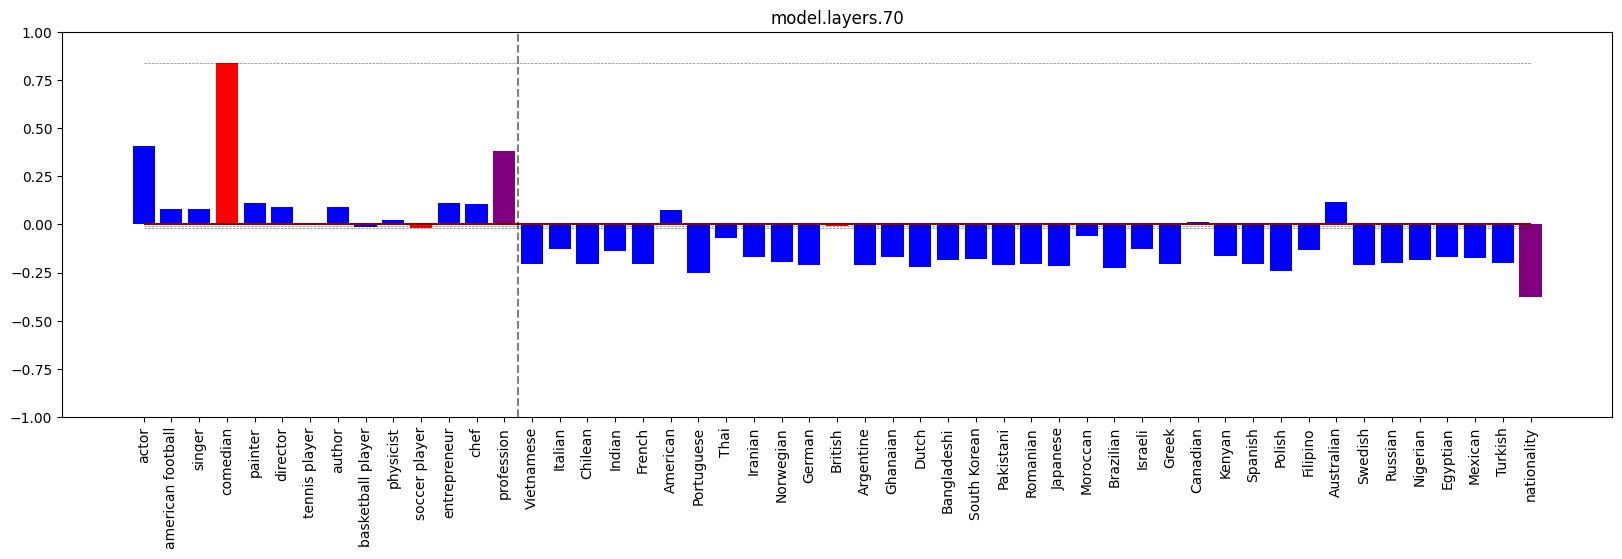

model.layers.70 => [('comedian', 0.8359375), ('actor', 0.408203125), ('profession', 0.37890625), ('Australian', 0.1171875), ('entrepreneur', 0.11328125), ('painter', 0.109375), ('chef', 0.10498046875), ('director', 0.091796875), ('author', 0.09033203125), ('singer', 0.08203125), ('american football', 0.08056640625), ('American', 0.076171875), ('physicist', 0.0213623046875), ('Canadian', 0.010986328125), ('tennis player', 0.00177001953125), ('British', -0.00994873046875), ('basketball player', -0.012939453125), ('soccer player', -0.0166015625), ('Moroccan', -0.060546875), ('Thai', -0.072265625), ('Israeli', -0.1259765625), ('Italian', -0.1279296875), ('Filipino', -0.1328125), ('Indian', -0.140625), ('Kenyan', -0.1650390625), ('Ghanaian', -0.1669921875), ('Iranian', -0.16796875), ('Egyptian', -0.171875), ('Mexican', -0.1728515625), ('South Korean', -0.1806640625), ('Bangladeshi', -0.1826171875), ('Nigerian', -0.1865234375), ('Norwegian', -0.193359375), ('Turkish', -0.2001953125), ('Russi

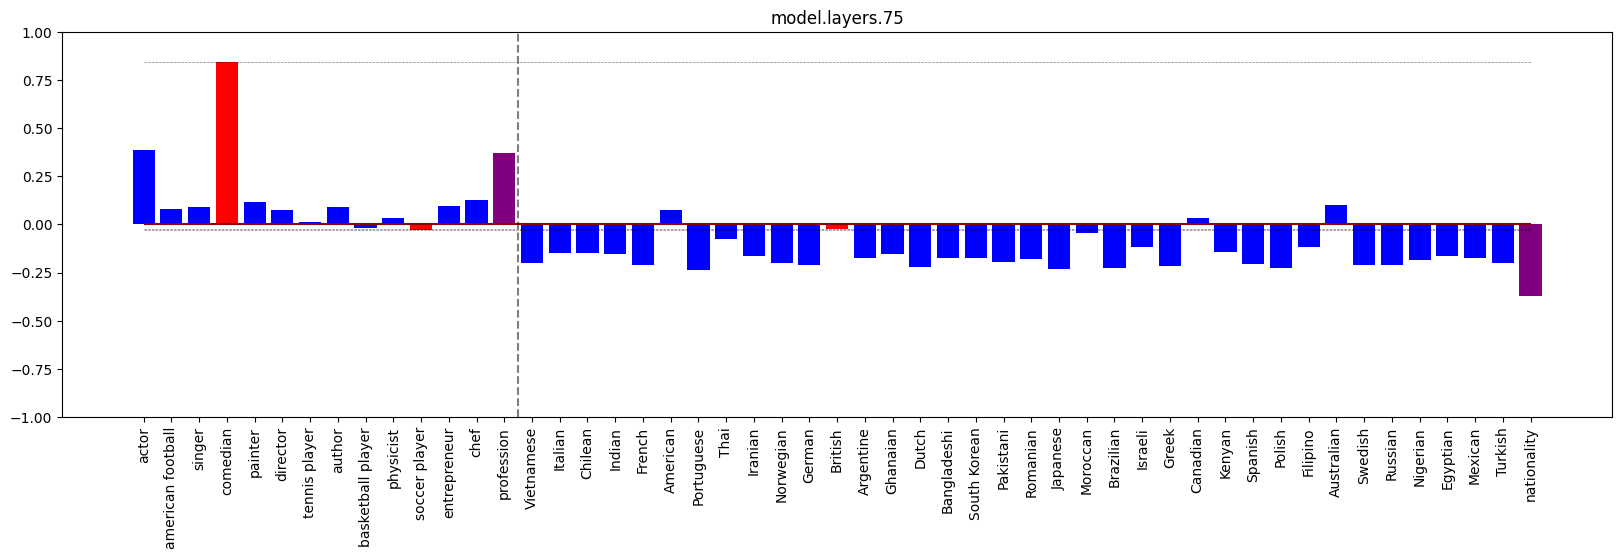

model.layers.75 => [('comedian', 0.84375), ('actor', 0.38671875), ('profession', 0.373046875), ('chef', 0.12890625), ('painter', 0.11767578125), ('Australian', 0.10107421875), ('entrepreneur', 0.09765625), ('author', 0.09033203125), ('singer', 0.087890625), ('american football', 0.07763671875), ('American', 0.07568359375), ('director', 0.07373046875), ('Canadian', 0.03515625), ('physicist', 0.032470703125), ('tennis player', 0.01129150390625), ('basketball player', -0.01953125), ('British', -0.0260009765625), ('soccer player', -0.029052734375), ('Moroccan', -0.046875), ('Thai', -0.0732421875), ('Filipino', -0.11572265625), ('Israeli', -0.119140625), ('Kenyan', -0.142578125), ('Chilean', -0.1474609375), ('Italian', -0.1484375), ('Ghanaian', -0.1513671875), ('Indian', -0.154296875), ('Iranian', -0.1650390625), ('Egyptian', -0.1650390625), ('Argentine', -0.1728515625), ('Bangladeshi', -0.1748046875), ('South Korean', -0.1767578125), ('Mexican', -0.1767578125), ('Romanian', -0.1806640625),

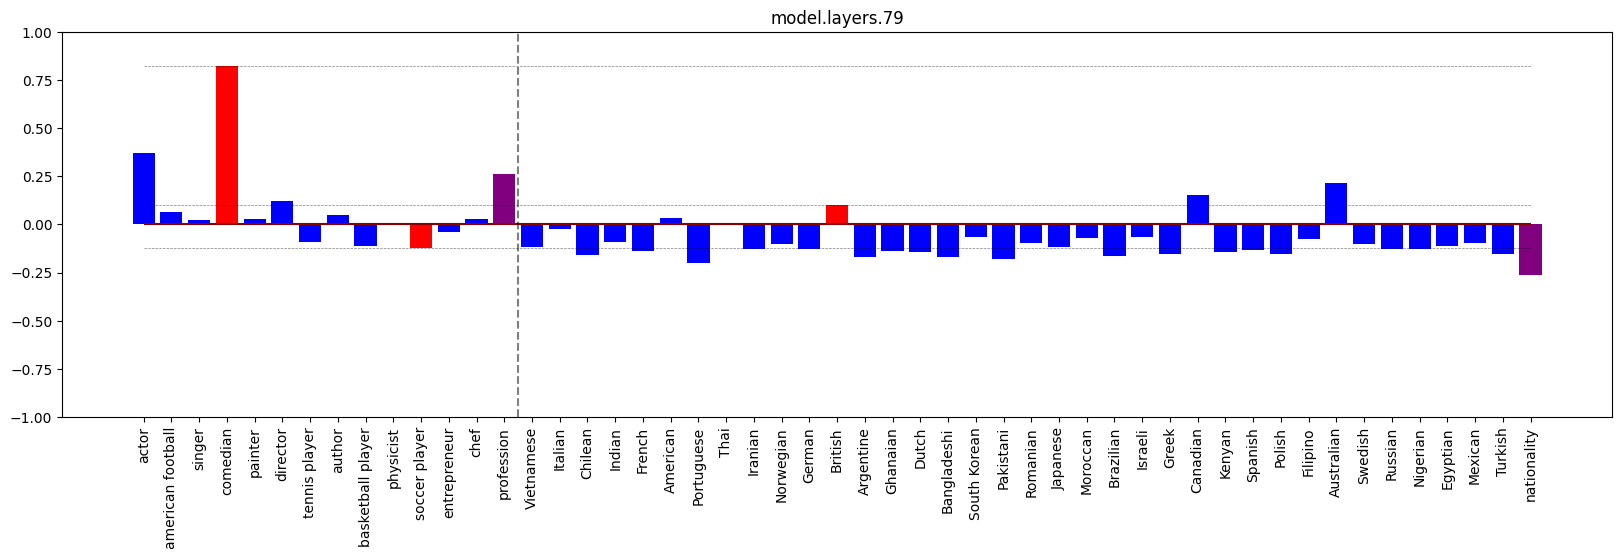

model.layers.79 => [('comedian', 0.8203125), ('actor', 0.373046875), ('profession', 0.26171875), ('Australian', 0.2158203125), ('Canadian', 0.154296875), ('director', 0.1201171875), ('British', 0.10302734375), ('american football', 0.0634765625), ('author', 0.048828125), ('American', 0.03271484375), ('painter', 0.0277099609375), ('chef', 0.02734375), ('singer', 0.02490234375), ('physicist', 0.0007171630859375), ('Thai', -0.00164031982421875), ('Italian', -0.0255126953125), ('entrepreneur', -0.037841796875), ('Israeli', -0.06396484375), ('South Korean', -0.06640625), ('Moroccan', -0.07177734375), ('Filipino', -0.0771484375), ('tennis player', -0.08935546875), ('Indian', -0.09326171875), ('Mexican', -0.0947265625), ('Romanian', -0.09521484375), ('Norwegian', -0.103515625), ('Swedish', -0.10400390625), ('basketball player', -0.11083984375), ('Egyptian', -0.1142578125), ('Vietnamese', -0.115234375), ('Japanese', -0.11767578125), ('soccer player', -0.125), ('Iranian', -0.1259765625), ('Germ

In [28]:
from matplotlib import pyplot as plt

# highlight_concepts = ["basketball player", "singer"]
# highlight_concepts = ["physicist", "soccar player"]
# highlight_concepts = ["author", "director"]
# highlight_concepts = ["director", "entrepreneur"]
# highlight_concepts = ["artist", "Spanish"]
# highlight_concepts = ["artist", "Spanish", "French"]
# highlight_concepts = ["artist", "actress", "Spanish"]
# highlight_concepts = ["artist", "soccer player", "French"]
# highlight_concepts = ["artist", "Spanish", "French"]
# highlight_concepts = ["singer", "American", "Canadian"]
# highlight_concepts = ["singer", "actress", "Canadian"]
# highlight_concepts = ["author", "French", "Nigerian"]
# highlight_concepts = ["Mexican", "Indian"]
# highlight_concepts = ["musician", "Canadian"]
# highlight_concepts = ["comedian", "American", "British"]
highlight_concepts = ["British", "comedian", "soccer player"]
# highlight_concepts = ["soccer player", "painter", "French"]
# highlight_concepts = ["artist", "Mexican", "Indian"]
# highlight_concepts = ["singer", "Argentine", "American"]
# highlight_concepts = ["British", "author", "comedian"]
# highlight_concepts = ["painter", "Spanish"]
# highlight_concepts = ["singer", "Canadian"]
# highlight_concepts = ["author", 'French', 'Nigerian']
# highlight_concepts = ["actor", "South Korean", "Israeli"]
# highlight_concepts = ["Egyptian"]
# highlight_concepts = ["Australian"]


layers = list(range(0, mt.n_layer, 5)) + list(range(30, 45))
if mt.n_layer - 1 not in layers:
    layers.append(mt.n_layer - 1)

layers = sorted(layers)
layers = [mt.layer_names[layer] for layer in layers]

for layer_name in layers:
    avg = average_direction[layer_name]
    h = hs[(layer_name, -1)].cuda()
    # h = h - avg
    # remove avg info from h
    h = h - torch.dot(h, avg) / avg.norm()**2 * avg
    similarity_track = []
    for attribute in attributes:
        for shared_attr, probe in probe_directions[attribute].items():
            d = probe.directions[layer_name].to(mt.dtype).to(mt.device)
            # d = d - avg
            d = d - torch.dot(d, avg) / avg.norm()**2 * avg
            cos_sim = torch.nn.functional.cosine_similarity(
                h.unsqueeze(0), d.unsqueeze(0)
            )
            similarity_track.append((shared_attr, cos_sim.item()))

    plt.figure(figsize=(20, 5))
    plt.title(f"{layer_name}")
    plt.bar(
        [x[0] for x in similarity_track],
        [x[1] for x in similarity_track],
        label=layer_name,
        color="blue",
    )
    for highlight in highlight_concepts:
        if highlight in [x[0] for x in similarity_track]:
            plt.bar(
                highlight,
                [x[1] for x in similarity_track if x[0] == highlight],
                color="red",
            )
            plt.hlines(
                y=[x[1] for x in similarity_track if x[0] == highlight][0],
                xmin=0,
                xmax=len(similarity_track) - 1,
                colors="black",
                linestyles="dashed",
                alpha=0.5,
                linewidth=.5,
            )
    
    for attribute in attributes:
        if attribute in [x[0] for x in similarity_track]:
            plt.bar(
                attribute,
                [x[1] for x in similarity_track if x[0] == attribute],
                color="purple",
            )

    plt.hlines(
        y=0,
        xmin=0,
        xmax=len(similarity_track) - 1,
        colors="darkred",
        # linestyles="dashed",
    )
    plt.vlines(
        x = len(probe_directions["profession"])
        - 0.5,  # Adjusted to center the line between the two attributes
        ymin=-1,
        ymax=1,
        colors="black",
        alpha=0.5,
        linestyles="dashed",
    )

    plt.ylim(-1, 1)

    plt.xticks(rotation=90)
    plt.show()
    
    similarity_track = sorted(similarity_track, key=lambda x: x[1], reverse=True)
    print(f"{layer_name} => {similarity_track}")

### Control Attribute-*Type* Selection

#### Steering

In [40]:
# promote_concept = ("profession", "painter")
# suppress_concept = ("nationality", "Spanish")

# promote_concept = ("profession", "singer")
# suppress_concept = ("nationality", "Canadian")

# general direction
promote_concept = ("profession", "profession")
suppress_concept = ("nationality", "nationality")
# promote_concept, suppress_concept = suppress_concept, promote_concept

promote_directions = probe_directions[promote_concept[0]][promote_concept[1]].directions
suppress_directions = probe_directions[suppress_concept[0]][suppress_concept[1]].directions
beta = 1

patch_hs = []
for layer_name in mt.layer_names[31 : 35]:
# for layer_name in mt.layer_names[55 : 60]:
    promote_direction = promote_directions[layer_name].to(mt.dtype).to(mt.device)
    suppress_direction = suppress_directions[layer_name].to(mt.dtype).to(mt.device)

    orig_h = hs[(layer_name, -1)].to(mt.dtype).to(mt.device)

    # patch_h = orig_h + beta * (promote_direction - suppress_direction)
    h_suppress = torch.dot(orig_h, suppress_direction) / suppress_direction.norm()**2 * suppress_direction
    h_promote = torch.dot(orig_h, promote_direction) / promote_direction.norm()**2 * promote_direction
    patch_h = orig_h + beta * (h_promote - h_suppress)

    patch_hs.append(PatchSpec(
        location=(layer_name, -1),
        patch=patch_h.to(mt.dtype).to(mt.device)
    ))

_, patched_pred, patch_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=probing_input.tokenized),
    patches=patch_hs,
    ans_tokens=[next_probs[0].token_id],
    generate_full_ans=False,
    metric=METRIC,
    k=15,
)

patched_pred

[PredictedToken(token=' Singer', prob=0.86328125, logit=24.5, token_id=55770, metadata=None),
 PredictedToken(token=' Music', prob=0.08056640625, logit=22.125, token_id=10948, metadata=None),
 PredictedToken(token=' singer', prob=0.033447265625, logit=21.25, token_id=23597, metadata=None),
 PredictedToken(token=' Canadian', prob=0.01397705078125, logit=20.375, token_id=12152, metadata=None),
 PredictedToken(token=' Sing', prob=0.0024261474609375, logit=18.625, token_id=11070, metadata=None),
 PredictedToken(token=' musician', prob=0.0012969970703125, logit=18.0, token_id=39844, metadata=None),
 PredictedToken(token=' National', prob=0.0004787445068359375, logit=17.0, token_id=5165, metadata=None),
 PredictedToken(token=' singers', prob=0.0004787445068359375, logit=17.0, token_id=68141, metadata=None),
 PredictedToken(token=' Vocal', prob=0.0003719329833984375, logit=16.75, token_id=98403, metadata=None),
 PredictedToken(token=' music', prob=0.0002899169921875, logit=16.5, token_id=4731

#### Patching

In [ ]:
def cache_biassociation_states(
    entity_pair: tuple[str, str],
    mt: ModelandTokenizer,
    locations: list[tuple[str, int]],
    patches: list[PatchSpec] = [],
    prefix: str | None = prefix,
    prefix_generator: BiAssociationPrefix = prefix_generator,
    answer_prefix: str = " Yes -",
    generate_full_ans: bool = False,
) -> dict[tuple[str, int], torch.Tensor]:
    prefix = (
        prefix_generator.get_prefix(
            n_valid=10,
            n_none=1,
        )
        if prefix is None
        else prefix
    )

    probing_input = prepare_probing_input(
        mt=mt,
        entities=entity_pair,
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        answer_prefix=answer_prefix,
    )

    if generate_full_ans:
        answer = generate_with_patch(
            mt=mt,
            inputs=TokenizerOutput(data=probing_input.tokenized),
            n_gen_per_prompt=1,
            max_new_tokens=30,
            do_sample=False,
            patches=patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=False,  # don't need to
            # patch_at_all_generations=True,    # will give the same result
            # use_cache = False,
        )
        logger.info(f'Generation = "{answer[0]}"')


    return get_hs(
        mt = mt,
        input=TokenizerOutput(data=probing_input.tokenized),
        locations=locations,
        patches=patches,
        return_dict=True,
    )

############################################################################
locations = [(layer_name, -1) for layer_name in mt.layer_names]
lm_head_state = (mt.lm_head_name, -1)
locations += [lm_head_state]
############################################################################

In [97]:
############################################################################
#! Same profession, different Nationality
patch_entities = ["Celine Dion", "Taylor Swift"]

#! Different profession, same Nationality
# patch_entities = ["Celine Dion", "Rachel McAdams"]
############################################################################

patch_hs = cache_biassociation_states(
    entity_pair=patch_entities,
    mt=mt,
    locations=locations,
    generate_full_ans=True,
)

logits = patch_hs[(mt.lm_head_name, -1)]
next_probs = interpret_logits(
    tokenizer=mt,
    logits=logits,
    k=15,
)
print(f"{patch_entities} | => {next_probs[0]}")
next_probs

2025-07-08 13:17:26 __main__ INFO     Generation = " Singer - they are both singers."
['Celine Dion', 'Taylor Swift'] | => " Singer"[55770] (p=0.859, logit=24.625)


[PredictedToken(token=' Singer', prob=0.859375, logit=24.625, token_id=55770, metadata=None),
 PredictedToken(token=' singer', prob=0.062255859375, logit=22.0, token_id=23597, metadata=None),
 PredictedToken(token=' Music', prob=0.062255859375, logit=22.0, token_id=10948, metadata=None),
 PredictedToken(token=' Sing', prob=0.005126953125, logit=19.5, token_id=11070, metadata=None),
 PredictedToken(token=' singers', prob=0.00188446044921875, logit=18.5, token_id=68141, metadata=None),
 PredictedToken(token=' musician', prob=0.0016632080078125, logit=18.375, token_id=39844, metadata=None),
 PredictedToken(token=' Canadian', prob=0.0012969970703125, logit=18.125, token_id=12152, metadata=None),
 PredictedToken(token=' Profession', prob=0.00069427490234375, logit=17.5, token_id=50311, metadata=None),
 PredictedToken(token=' American', prob=0.0006103515625, logit=17.375, token_id=3778, metadata=None),
 PredictedToken(token=' Song', prob=0.00041961669921875, logit=17.0, token_id=19508, metad

In [98]:
############################################################################
#! Same profession, Same Nationality
# clean_entities = ["Pablo Picasso", "Salvador Dalí"] # artist, *spanish*
# clean_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"]

#! Unexpected Cases
# clean_entities = ["Claude Monet", "Pablo Picasso"]
clean_entities = ["Issac Newton", "Emma Watson"]
############################################################################

clean_hs = cache_biassociation_states(
    entity_pair=clean_entities,
    mt=mt,
    locations=locations,
    generate_full_ans=True,
)

logits = clean_hs[(mt.lm_head_name, -1)]
next_probs = interpret_logits(
    tokenizer=mt,
    logits=logits,
    k=15,
)
print(f"{clean_entities} | => {next_probs[0]}")
next_probs

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-07-08 13:17:46 __main__ INFO     Generation = " British - they are both British."
['Issac Newton', 'Emma Watson'] | => " British"[8013] (p=0.742, logit=21.000)


[PredictedToken(token=' British', prob=0.7421875, logit=21.0, token_id=8013, metadata=None),
 PredictedToken(token=' English', prob=0.240234375, logit=19.875, token_id=6498, metadata=None),
 PredictedToken(token=' Scientist', prob=0.00439453125, logit=15.875, token_id=68409, metadata=None),
 PredictedToken(token=' nationality', prob=0.0020751953125, logit=15.125, token_id=59343, metadata=None),
 PredictedToken(token=' National', prob=0.00104522705078125, logit=14.4375, token_id=5165, metadata=None),
 PredictedToken(token=' ', prob=0.000675201416015625, logit=14.0, token_id=220, metadata=None),
 PredictedToken(token=' Professor', prob=0.000675201416015625, logit=14.0, token_id=17054, metadata=None),
 PredictedToken(token=' England', prob=0.0005950927734375, logit=13.875, token_id=9635, metadata=None),
 PredictedToken(token=' Mathematic', prob=0.0004634857177734375, logit=13.625, token_id=72140, metadata=None),
 PredictedToken(token=' Brit', prob=0.0004634857177734375, logit=13.625, toke

In [99]:
#################################################
intervention_locations = [(layer_name, -1) for layer_name in mt.layer_names[30:35]]
#################################################

int_hs = cache_biassociation_states(
    entity_pair=clean_entities,
    mt=mt,
    patches=[
        PatchSpec(
            location=location,
            patch=patch_hs[location],
        )
        for location in intervention_locations
    ],
    locations=locations,
    generate_full_ans=False,
)

logits = int_hs[(mt.lm_head_name, -1)]
next_probs = interpret_logits(
    tokenizer=mt,
    logits=logits,
    k=15,
)
print(f"{clean_entities} | => {next_probs[0]}")
next_probs

['Issac Newton', 'Emma Watson'] | => " Actress"[79539] (p=0.441, logit=19.625)


[PredictedToken(token=' Actress', prob=0.44140625, logit=19.625, token_id=79539, metadata=None),
 PredictedToken(token=' Actor', prob=0.236328125, logit=19.0, token_id=25749, metadata=None),
 PredictedToken(token=' British', prob=0.07666015625, logit=17.875, token_id=8013, metadata=None),
 PredictedToken(token=' English', prob=0.059814453125, logit=17.625, token_id=6498, metadata=None),
 PredictedToken(token=' actress', prob=0.0281982421875, logit=16.875, token_id=24577, metadata=None),
 PredictedToken(token=' Scientist', prob=0.02197265625, logit=16.625, token_id=68409, metadata=None),
 PredictedToken(token=' Actors', prob=0.02197265625, logit=16.625, token_id=82461, metadata=None),
 PredictedToken(token=' Phys', prob=0.0194091796875, logit=16.5, token_id=13101, metadata=None),
 PredictedToken(token=' actor', prob=0.0194091796875, logit=16.5, token_id=12360, metadata=None),
 PredictedToken(token=' Professor', prob=0.01336669921875, logit=16.125, token_id=17054, metadata=None),
 Predic

### Which module is making the decision what attribute-type to fetch?

1. Sample 2 opposing cases (safe prof, different nationality vs different prof and same nationality)
2. One position where the decision can be observed (layer 33?)
3. Patch blocking experiments
    * V1: (similar to ablation/corruption): 
        * On the clean run, patch from alternate run the ablate/corrupt the contributions of MLP or attention
        * Track if the decision starts favoring the clean run or the alternate run.

    * V2: (patching with freezing):
        * Patch a residual state from the alternate run, if the decision depends on this state, then patching should change the decision in favor of the alternate run (**verify first**)
        * Corrupting/ablating the MLPs/ATTNs to locate the modules responsible for the decision.